In [1]:
!pip install "/kaggle/input/autocorrect/autocorrect-2.6.1.tar"
!pip install /kaggle/input/textstat-pypi/Pyphen-0.9.3-py2.py3-none-any.whl
!pip install /kaggle/input/textstat-pypi/textstat-0.7.0-py3-none-any.whl

Processing /kaggle/input/autocorrect/autocorrect-2.6.1.tar
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=aa26ba9c51f88d445df4d002083092de3e92a31945ff2f343b0958f174e63da6
  Stored in directory: /root/.cache/pip/wheels/db/69/42/0fb0421d2fe70d195a04665edc760cfe5fd341d7bb8d8e0aaa
Successfully built autocorrect
Processing /kaggle/input/textstat-pypi/Pyphen-0.9.3-py2.py3-none-any.whl
Processing /kaggle/input/textstat-pypi/textstat-0.7.0-py3-none-any.whl


In [210]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
import os
import glob
from tqdm import tqdm
from joblib import Parallel, delayed
import gc

from sklearn.model_selection import train_test_split, KFold

from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import optuna
from optuna.samplers import TPESampler
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


import string
import pickle
import operator
from textblob import TextBlob

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from tqdm import tqdm
tqdm.pandas()
import warnings
warnings.filterwarnings("ignore")
import random
import textstat

In [211]:
train=pd.read_csv('../input/lgb-tuning/train_final_fe.csv')

In [212]:
train.columns

Index(['student_id', 'prompt_id', 'text', 'content', 'wording',
       'summary_length', 'fixed_summary_text', 'splling_err_num',
       'prompt_question', 'prompt_title', 'prompt_text', 'prompt_length',
       'length_ratio', 'word_overlap_count', 'bigram_overlap_count',
       'bigram_overlap_ratio', 'trigram_overlap_count',
       'trigram_overlap_ratio', 'quotes_count', 'fold', 'content_pred',
       'num_words', 'num_unique_words', 'num_chars', 'num_stopwords',
       'num_punctuations', 'num_words_upper', 'num_words_title',
       'mean_word_len', 'mean_num_unique_words', 'num_paragraphs', 'num_slash',
       'syntax_count', 'num_sentences', 'polarity', 'subjectivity', 'nn_count',
       'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count',
       'diff_emb_sb', 'diff_emb_qa', 'ch', 'rw', 'automated_readability_index',
       'coleman_liau_index', 'smog_index', 'flesch_reading_ease',
       'flesch_kincaid_grade', 'dale_chall_readability_score',
       'linsear_write_formul

In [213]:
no_features = ["student_id", "prompt_id", "prompt_question", "prompt_title", "prompt_text",'fold','fixed_summary_text','text']
target = ["content", "wording"]
fe_columns = [col for col in train.columns if col not in no_features + target]

corr = train[fe_columns + target].corr()
corr.style.background_gradient(cmap='coolwarm')

,summary_length,splling_err_num,prompt_length,length_ratio,word_overlap_count,bigram_overlap_count,bigram_overlap_ratio,trigram_overlap_count,trigram_overlap_ratio,quotes_count,content_pred,num_words,num_unique_words,num_chars,num_stopwords,num_punctuations,num_words_upper,num_words_title,mean_word_len,mean_num_unique_words,num_paragraphs,num_slash,syntax_count,num_sentences,polarity,subjectivity,nn_count,pr_count,vb_count,jj_count,uh_count,cd_count,diff_emb_sb,diff_emb_qa,ch,rw,automated_readability_index,coleman_liau_index,smog_index,flesch_reading_ease,flesch_kincaid_grade,dale_chall_readability_score,linsear_write_formula,gunning_fog,text_standard_float,spache_readability,rix,lix,cohesion,syntax,vocabulary,phraseology,grammar,conventions,wording_pred,content,wording
summary_length,1.000000,0.900955,0.030706,0.940968,0.813040,0.778061,0.130289,0.689296,0.199103,0.460188,0.903690,0.997188,0.982403,0.994672,0.979326,0.888061,0.157580,0.782267,0.122320,0.223653,0.004206,0.020700,0.775181,0.788657,0.002062,0.020938,0.951282,0.654686,0.951655,0.816780,0.149277,0.462702,0.766941,0.208959,0.055917,0.355376,0.186028,0.132044,0.511901,-0.139690,0.158594,0.092135,0.043072,0.150851,0.096363,0.143789,0.165289,0.182507,0.769760,0.659334,0.720299,0.661381,0.557595,0.496256,0.683027,0.790034,0.526730
splling_err_num,0.900955,1.000000,-0.054981,0.885750,0.654944,0.729154,0.153787,0.650443,0.215871,0.468423,0.808155,0.875466,0.888509,0.895922,0.832016,0.935500,0.182807,0.781887,0.270944,0.068078,0.010852,0.028182,0.833574,0.812023,0.053590,0.015943,0.902698,0.490221,0.820269,0.741134,0.174318,0.421747,0.770090,0.189401,0.048291,0.401417,0.121051,0.225753,0.470457,-0.097127,0.081394,0.130149,-0.022551,0.063821,0.065821,0.074944,0.145340,0.134720,0.655596,0.537783,0.592267,0.522660,0.420623,0.346512,0.573643,0.697481,0.422859
prompt_length,0.030706,-0.054981,1.000000,-0.243276,0.232746,0.200354,0.290629,0.221609,0.289079,0.137800,-0.034975,0.031657,0.027654,-0.020861,0.017766,0.042081,-0.084673,-0.192319,-0.470667,0.220235,-0.022077,-0.024819,0.090746,-0.108727,-0.282101,-0.159696,-0.095816,0.289170,0.058787,-0.079045,-0.022748,0.043355,-0.273286,0.232653,0.020497,-0.260455,0.109079,-0.433893,-0.150035,0.066971,0.099723,-0.363778,0.187017,0.133659,-0.025391,0.093579,-0.110049,0.002207,-0.028154,0.009457,0.017111,0.055076,0.111290,0.069451,-0.223090,-0.051055,-0.144804
length_ratio,0.940968,0.885750,-0.243276,1.000000,0.674184,0.661733,0.043640,0.565698,0.106698,0.398307,0.866133,0.936622,0.926007,0.956296,0.920321,0.838558,0.186668,0.830580,0.248610,0.131145,0.011161,0.026407,0.697339,0.809379,0.089553,0.048296,0.951349,0.527531,0.882908,0.791662,0.167418,0.423719,0.792958,0.145315,0.048985,0.398349,0.131769,0.242345,0.521042,-0.133354,0.106098,0.153361,-0.028734,0.087840,0.088156,0.091603,0.173861,0.154957,0.736726,0.620154,0.675389,0.607419,0.496011,0.449292,0.717851,0.769431,0.539348
word_overlap_count,0.813040,0.654944,0.232746,0.674184,1.000000,0.743079,0.282775,0.675284,0.335767,0.392129,0.791776,0.820559,0.852674,0.791082,0.834448,0.668761,0.084785,0.518386,-0.084610,0.385569,-0.001587,0.008324,0.629941,0.528095,-0.104697,0.029296,0.685661,0.641868,0.796253,0.651047,0.066470,0.401487,0.505675,0.207957,0.063510,0.216223,0.241759,-0.030247,0.454348,-0.164127,0.230066,0.046004,0.180109,0.250184,0.119314,0.219056,0.170989,0.219923,0.724748,0.660918,0.717783,0.695695,0.608133,0.527004,0.572858,0.692532,0.438935
bigram_overlap_count,0.778061,0.729154,0.200354,0.661733,0.743079,1.000000,0.603679,0.982964,0.650077,0.455886,0.644360,0.767700,0.780817,0.760552,0.742176,0.740358,0.055987,0.579103,0.068135,0.240440,0.049822,0.080337,0.744529,0.572936,-0.062266,-0.058071,0.742161,0.509719,0.729297,0.574230,0.075164,0.307486,0.637466,0.168810,0.041566,0.192762,0.178908,0.073684,0.332458,-0.099361,0.143998,0.045079,0.104975,0.147425,0.072104,0.144216,0.112235,0.161433,0.578389,0.517285,0.588095,0.549039,0.482329,0.422796,0.319050,0.482396,0.113495
bi

In [214]:
fe_columns

['summary_length',
 'splling_err_num',
 'prompt_length',
 'length_ratio',
 'word_overlap_count',
 'bigram_overlap_count',
 'bigram_overlap_ratio',
 'trigram_overlap_count',
 'trigram_overlap_ratio',
 'quotes_count',
 'content_pred',
 'num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_punctuations',
 'num_words_upper',
 'num_words_title',
 'mean_word_len',
 'mean_num_unique_words',
 'num_paragraphs',
 'num_slash',
 'syntax_count',
 'num_sentences',
 'polarity',
 'subjectivity',
 'nn_count',
 'pr_count',
 'vb_count',
 'jj_count',
 'uh_count',
 'cd_count',
 'diff_emb_sb',
 'diff_emb_qa',
 'ch',
 'rw',
 'automated_readability_index',
 'coleman_liau_index',
 'smog_index',
 'flesch_reading_ease',
 'flesch_kincaid_grade',
 'dale_chall_readability_score',
 'linsear_write_formula',
 'gunning_fog',
 'text_standard_float',
 'spache_readability',
 'rix',
 'lix',
 'cohesion',
 'syntax',
 'vocabulary',
 'phraseology',
 'grammar',
 'conventions',
 'wording_pred']

In [215]:
target = ["wording"]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004057 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9087
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 54
[LightGBM] [Info] Start training from score -0.031791
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

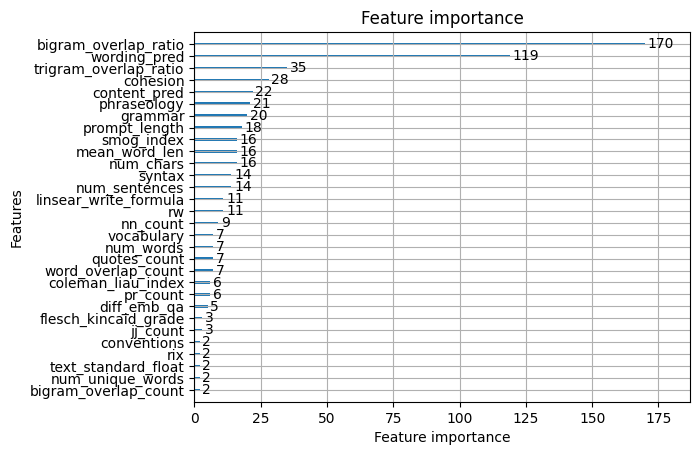

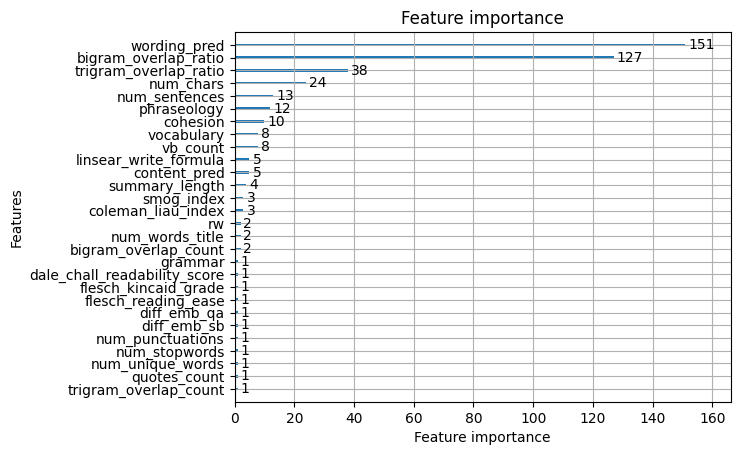

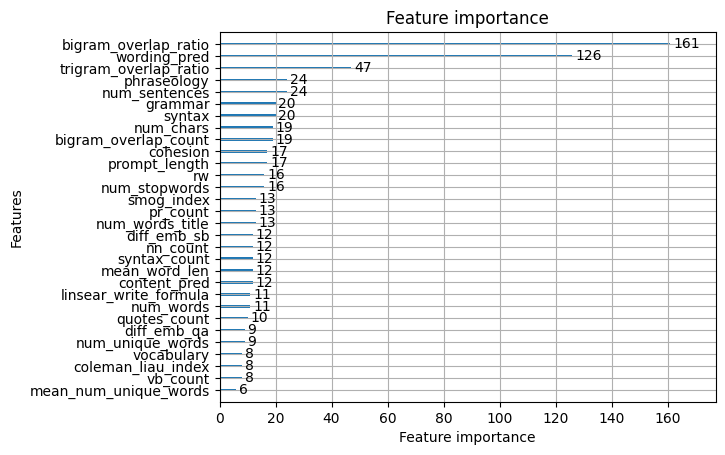

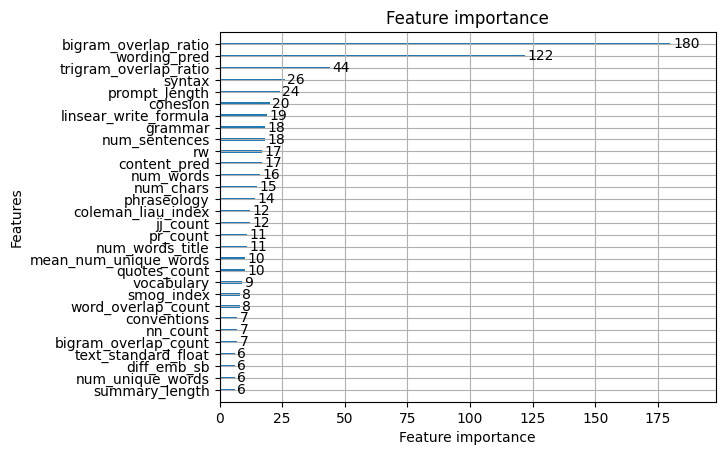

In [216]:
params = {
    'boosting_type': 'gbdt',
    'random_state': 42,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.048,
    'max_depth': 3,  
    'lambda_l1': 0.0,
    'lambda_l2': 0.011
}
models = []

for fold in range(4):

    X_train_cv = train[train["fold"] != fold][fe_columns]
    y_train_cv = train[train["fold"] != fold][target]

    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
    dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

    evaluation_results = {}
    model = lgb.train(params,
                      num_boost_round=10000,
                      valid_names=['train', 'valid'],
                      train_set=dtrain,
                      valid_sets=dval,
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=30, verbose=True),
                           lgb.log_evaluation(100),
                          lgb.callback.record_evaluation(evaluation_results)
                        ],
                      )
    print(lgb.plot_importance(model,max_num_features=30))
    models.append(model)
rmses = []
preds = []
trues = []
for fold, model in enumerate(models):
    print(fold)
    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    pred = model.predict(X_eval_cv)

    trues.extend(y_eval_cv.values)
    preds.extend(pred)

rmse = np.sqrt(mean_squared_error(trues, preds))
print(rmse)

In [218]:
rmse

0.5670942062580623

In [219]:
params = {
    'boosting_type': 'gbdt',
    'random_state': 42,
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.048,
    'max_depth': 3,  
    'lambda_l1': 0.0,
    'lambda_l2': 0.011
}
score = rmse
best_features = fe_columns.copy()
for i in fe_columns:
    preds = []
    trues = []
    features = [x for x in best_features if x not in [i]]
    print(features)
    print('Evaluating {} column'.format(i))
    for fold in range(4):
        X_train_cv = train[train["fold"] != fold][features]
        y_train_cv = train[train["fold"] != fold][target]

        X_eval_cv = train[train["fold"] == fold][features]
        y_eval_cv = train[train["fold"] == fold][target]

        dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
        dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)


        model = lgb.train(params,
                          num_boost_round=10000,
                          valid_names=['train', 'valid'],
                          train_set=dtrain,
                          valid_sets=dval,
                          callbacks=[
                          lgb.early_stopping(stopping_rounds=30, verbose=True),
                           lgb.log_evaluation(1000),
                          lgb.callback.record_evaluation(evaluation_results)]
                          
                          )
        pred = model.predict(X_eval_cv)
        trues.extend(y_eval_cv.values)
        preds.extend(pred)
    loss_score = np.sqrt(mean_squared_error(trues, preds))
    print(loss_score)
    print(score)
    print('loss_score is :', loss_score)
    if loss_score < score:
        print('Feature {} is useless'.format(i))
        best_features.remove(i)
        score = loss_score
    else:
        print('Feature {} is usefull'.format(i))
    gc.collect()
print('The best features are: ', best_features )

['splling_err_num', 'prompt_length', 'length_ratio', 'word_overlap_count', 'bigram_overlap_count', 'bigram_overlap_ratio', 'trigram_overlap_count', 'trigram_overlap_ratio', 'quotes_count', 'content_pred', 'num_words', 'num_unique_words', 'num_chars', 'num_stopwords', 'num_punctuations', 'num_words_upper', 'num_words_title', 'mean_word_len', 'mean_num_unique_words', 'num_paragraphs', 'num_slash', 'syntax_count', 'num_sentences', 'polarity', 'subjectivity', 'nn_count', 'pr_count', 'vb_count', 'jj_count', 'uh_count', 'cd_count', 'diff_emb_sb', 'diff_emb_qa', 'ch', 'rw', 'automated_readability_index', 'coleman_liau_index', 'smog_index', 'flesch_reading_ease', 'flesch_kincaid_grade', 'dale_chall_readability_score', 'linsear_write_formula', 'gunning_fog', 'text_standard_float', 'spache_readability', 'rix', 'lix', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'wording_pred']
Evaluating summary_length column
[LightGBM] [Warning] Auto-choosing row-wise multi-threa

In [220]:
print('The best features are: ', best_features )

The best features are:  ['summary_length', 'splling_err_num', 'prompt_length', 'length_ratio', 'word_overlap_count', 'bigram_overlap_count', 'bigram_overlap_ratio', 'trigram_overlap_ratio', 'quotes_count', 'content_pred', 'num_words', 'num_unique_words', 'num_chars', 'num_stopwords', 'num_words_upper', 'num_words_title', 'mean_word_len', 'mean_num_unique_words', 'num_paragraphs', 'num_slash', 'num_sentences', 'subjectivity', 'nn_count', 'pr_count', 'vb_count', 'uh_count', 'cd_count', 'diff_emb_sb', 'diff_emb_qa', 'ch', 'smog_index', 'flesch_reading_ease', 'flesch_kincaid_grade', 'dale_chall_readability_score', 'linsear_write_formula', 'text_standard_float', 'spache_readability', 'rix', 'lix', 'cohesion', 'syntax', 'vocabulary', 'phraseology', 'grammar', 'conventions', 'wording_pred']


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003163 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7541
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 45
[LightGBM] [Info] Start training from score -0.031791
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

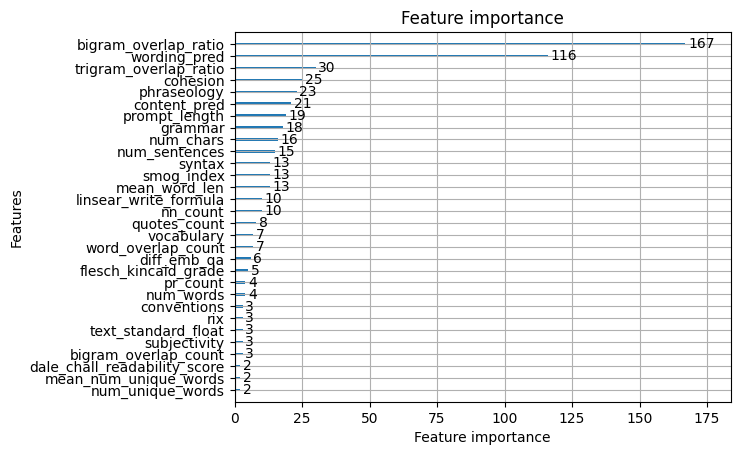

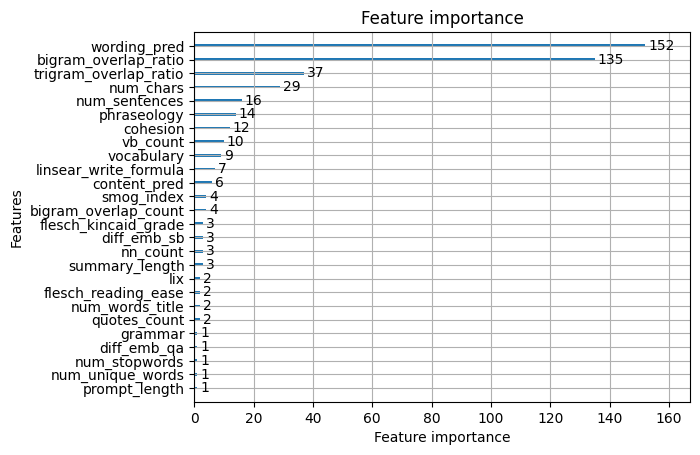

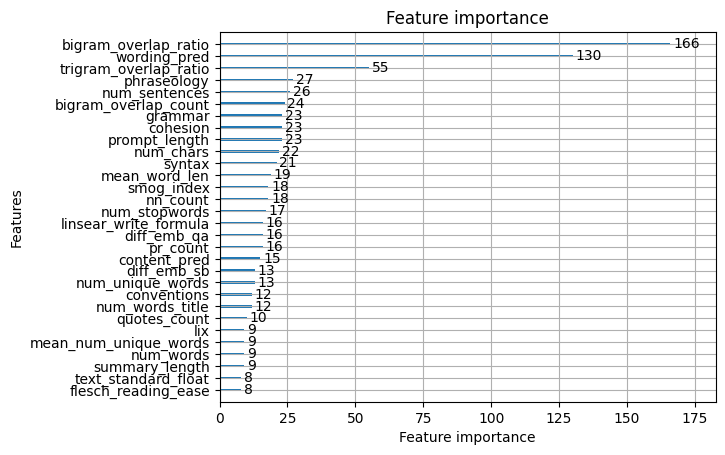

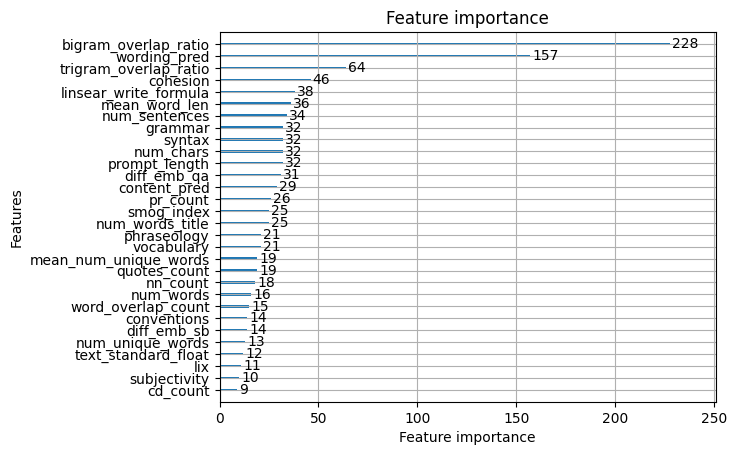

In [221]:
models = []

for fold in range(4):

    X_train_cv = train[train["fold"] != fold][best_features]
    y_train_cv = train[train["fold"] != fold][target]

    X_eval_cv = train[train["fold"] == fold][best_features]
    y_eval_cv = train[train["fold"] == fold][target]

    dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
    dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

    evaluation_results = {}
    model = lgb.train(params,
                      num_boost_round=10000,
                      valid_names=['train', 'valid'],
                      train_set=dtrain,
                      valid_sets=dval,
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=30, verbose=True),
                           lgb.log_evaluation(100),
                          lgb.callback.record_evaluation(evaluation_results)
                        ],
                      )
    print(lgb.plot_importance(model,max_num_features=30))
    models.append(model)

In [222]:
rmses = []
preds = []
trues = []
for fold, model in enumerate(models):
    print(fold)
    X_eval_cv = train[train["fold"] == fold][best_features]
    y_eval_cv = train[train["fold"] == fold][target]

    pred = model.predict(X_eval_cv)

    trues.extend(y_eval_cv.values)
    preds.extend(pred)

rmse = np.sqrt(mean_squared_error(trues, preds))
print(rmse)

0
1
2
3
0.5638385192926119


In [223]:
fe_columns=best_features

In [224]:
fe_columns

['summary_length',
 'splling_err_num',
 'prompt_length',
 'length_ratio',
 'word_overlap_count',
 'bigram_overlap_count',
 'bigram_overlap_ratio',
 'trigram_overlap_ratio',
 'quotes_count',
 'content_pred',
 'num_words',
 'num_unique_words',
 'num_chars',
 'num_stopwords',
 'num_words_upper',
 'num_words_title',
 'mean_word_len',
 'mean_num_unique_words',
 'num_paragraphs',
 'num_slash',
 'num_sentences',
 'subjectivity',
 'nn_count',
 'pr_count',
 'vb_count',
 'uh_count',
 'cd_count',
 'diff_emb_sb',
 'diff_emb_qa',
 'ch',
 'smog_index',
 'flesch_reading_ease',
 'flesch_kincaid_grade',
 'dale_chall_readability_score',
 'linsear_write_formula',
 'text_standard_float',
 'spache_readability',
 'rix',
 'lix',
 'cohesion',
 'syntax',
 'vocabulary',
 'phraseology',
 'grammar',
 'conventions',
 'wording_pred']

In [225]:
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        'random_state': 42,
         'objective': 'regression',
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True)}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [0,1,2,3]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()

In [226]:
study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True) 

[I 2023-09-11 10:53:20,220] A new study created in memory with name: no-name-9642e80e-6c0b-4775-bcb3-54cd46e39d52


[LightGBM] [Warning] lambda_l1 is set=1.1014197070296105e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1014197070296105e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.547830167354567e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.547830167354567e-08
Fold 0 | RMSE: 0.5250150530762194
[LightGBM] [Warning] lambda_l1 is set=1.1014197070296105e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1014197070296105e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.547830167354567e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.547830167354567e-08
Fold 1 | RMSE: 0.6429400676762141
[LightGBM] [Warning] lambda_l1 is set=1.1014197070296105e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1014197070296105e-08
[LightGBM] [W

[I 2023-09-11 10:53:24,941] Trial 0 finished with value: 0.5642505746457563 and parameters: {'learning_rate': 0.07795467510206452, 'max_depth': 8, 'lambda_l1': 1.1014197070296105e-08, 'lambda_l2': 2.547830167354567e-08}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6058148677038647
[LightGBM] [Warning] lambda_l1 is set=1.4387318197129795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4387318197129795
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.2120777477481161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2120777477481161
Fold 0 | RMSE: 0.6851857158092374
[LightGBM] [Warning] lambda_l1 is set=1.4387318197129795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4387318197129795
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.2120777477481161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2120777477481161
Fold 1 | RMSE: 0.7228739899705
[LightGBM] [Warning] lambda_l1 is set=1.4387318197129795, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4387318197129795
[LightGBM] [Warnin

[I 2023-09-11 10:53:30,385] Trial 1 finished with value: 0.7380183918603689 and parameters: {'learning_rate': 0.007043730149147401, 'max_depth': 13, 'lambda_l1': 1.4387318197129795, 'lambda_l2': 0.2120777477481161}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.8784037050117472
[LightGBM] [Warning] lambda_l1 is set=2.1219227582114945e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1219227582114945e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00034388344331444745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00034388344331444745
Fold 0 | RMSE: 0.5226327060077437
[LightGBM] [Warning] lambda_l1 is set=2.1219227582114945e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1219227582114945e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00034388344331444745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00034388344331444745
Fold 1 | RMSE: 0.6462124278704817
[LightGBM] [Warning] lambda_l1 is set=2.1219227582114945e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2023-09-11 10:53:35,674] Trial 2 finished with value: 0.5678761340692634 and parameters: {'learning_rate': 0.08913700806225286, 'max_depth': 11, 'lambda_l1': 2.1219227582114945e-08, 'lambda_l2': 0.00034388344331444745}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.615807845815216
[LightGBM] [Warning] lambda_l1 is set=0.16145015345393907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16145015345393907
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00045676177157105013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045676177157105013
Fold 0 | RMSE: 0.5285042233709375
[LightGBM] [Warning] lambda_l1 is set=0.16145015345393907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16145015345393907
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00045676177157105013, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045676177157105013
Fold 1 | RMSE: 0.6504630160044802
[LightGBM] [Warning] lambda_l1 is set=0.16145015345393907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.161450153453

[I 2023-09-11 10:53:41,992] Trial 3 finished with value: 0.5707398281760019 and parameters: {'learning_rate': 0.28343791961576037, 'max_depth': 11, 'lambda_l1': 0.16145015345393907, 'lambda_l2': 0.00045676177157105013}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6097592265410621
[LightGBM] [Warning] lambda_l1 is set=0.024694384202818175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024694384202818175
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.294907129196147e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.294907129196147e-07
Fold 0 | RMSE: 0.7928158109086954
[LightGBM] [Warning] lambda_l1 is set=0.024694384202818175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.024694384202818175
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.294907129196147e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.294907129196147e-07
Fold 1 | RMSE: 0.779575481259664
[LightGBM] [Warning] lambda_l1 is set=0.024694384202818175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02469438420

[I 2023-09-11 10:53:43,288] Trial 4 finished with value: 0.8271764221529136 and parameters: {'learning_rate': 0.009811948444680007, 'max_depth': 1, 'lambda_l1': 0.024694384202818175, 'lambda_l2': 3.294907129196147e-07}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 1.0060451671348358


[I 2023-09-11 10:53:43,754] Trial 5 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=2.438354156820377e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.438354156820377e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.7331583477593716e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7331583477593716e-08


[I 2023-09-11 10:53:44,276] Trial 6 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 10:53:44,809] Trial 7 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 10:53:45,256] Trial 8 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 10:53:45,710] Trial 9 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 10:53:46,244] Trial 10 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.5243122004202336
[LightGBM] [Warning] lambda_l1 is set=1.509757944614502e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.509757944614502e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1846307541795674e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1846307541795674e-05
Fold 1 | RMSE: 0.6492519137886426
[LightGBM] [Warning] lambda_l1 is set=1.509757944614502e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.509757944614502e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1846307541795674e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1846307541795674e-05
Fold 2 | RMSE: 0.48614991086418213
[LightGBM] [Warning] lambda_l1 is set=1.509757944614502e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.

[I 2023-09-11 10:53:52,109] Trial 11 finished with value: 0.5666711335132895 and parameters: {'learning_rate': 0.10090166262843869, 'max_depth': 15, 'lambda_l1': 1.509757944614502e-08, 'lambda_l2': 1.1846307541795674e-05}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6069705089800992
[LightGBM] [Warning] lambda_l1 is set=2.634307901129383e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.634307901129383e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.091453767770882e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.091453767770882e-06
Fold 0 | RMSE: 0.526443643606896
[LightGBM] [Warning] lambda_l1 is set=2.634307901129383e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.634307901129383e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.091453767770882e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.091453767770882e-06
Fold 1 | RMSE: 0.650849414593889
[LightGBM] [Warning] lambda_l1 is set=2.634307901129383e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6343079

[I 2023-09-11 10:53:57,829] Trial 12 finished with value: 0.5692350946303838 and parameters: {'learning_rate': 0.22368389649643466, 'max_depth': 16, 'lambda_l1': 2.634307901129383e-08, 'lambda_l2': 5.091453767770882e-06}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6123426379568531
[LightGBM] [Warning] lambda_l1 is set=3.6022067912469196e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6022067912469196e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.0618798510604417e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0618798510604417e-06


[I 2023-09-11 10:53:58,588] Trial 13 pruned. Trial was pruned at iteration 23.
[I 2023-09-11 10:53:59,115] Trial 14 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.5222173715148578
[LightGBM] [Warning] lambda_l1 is set=3.976339788486264e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.976339788486264e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.0430422995410282e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0430422995410282e-07
Fold 1 | RMSE: 0.640827670304662
[LightGBM] [Warning] lambda_l1 is set=3.976339788486264e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.976339788486264e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.0430422995410282e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0430422995410282e-07
Fold 2 | RMSE: 0.48603296194282447
[LightGBM] [Warning] lambda_l1 is set=3.976339788486264e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9

[I 2023-09-11 10:54:03,912] Trial 15 finished with value: 0.5645155894146997 and parameters: {'learning_rate': 0.10354050452451428, 'max_depth': 7, 'lambda_l1': 3.976339788486264e-05, 'lambda_l2': 2.0430422995410282e-07}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6089843538964544


[I 2023-09-11 10:54:04,443] Trial 16 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=4.617869836055937e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.617869836055937e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1070320691508183e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1070320691508183e-07


[I 2023-09-11 10:54:04,985] Trial 17 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.5259147383652371
[LightGBM] [Warning] lambda_l1 is set=9.1677116746263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.1677116746263e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3077549931379431e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3077549931379431e-08
Fold 1 | RMSE: 0.6457456531193617
[LightGBM] [Warning] lambda_l1 is set=9.1677116746263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.1677116746263e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3077549931379431e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3077549931379431e-08
Fold 2 | RMSE: 0.49079209451744593
[LightGBM] [Warning] lambda_l1 is set=9.1677116746263e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.1677116746

[I 2023-09-11 10:54:12,052] Trial 18 finished with value: 0.5666678253690791 and parameters: {'learning_rate': 0.1358620640123676, 'max_depth': -1, 'lambda_l1': 9.1677116746263e-06, 'lambda_l2': 1.3077549931379431e-08}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6042188154742716


[I 2023-09-11 10:54:12,584] Trial 19 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=2.2410522994576474e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2410522994576474e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.481647330327056e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.481647330327056e-07
Fold 0 | RMSE: 0.5284407241226079
[LightGBM] [Warning] lambda_l1 is set=0.00043031460577579563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00043031460577579563
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1506899796376733e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1506899796376733e-06
Fold 1 | RMSE: 0.6422794573476037
[LightGBM] [Warning] lambda_l1 is set=0.00043031460577579563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00043031460577579563
[LightGBM] 

[I 2023-09-11 10:54:16,190] Trial 20 finished with value: 0.5658802609587953 and parameters: {'learning_rate': 0.1569139814877476, 'max_depth': 5, 'lambda_l1': 0.00043031460577579563, 'lambda_l2': 1.1506899796376733e-06}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6083794558766603
[LightGBM] [Warning] lambda_l1 is set=0.0008343033802494274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008343033802494274
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.875848148021034e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.875848148021034e-07
Fold 0 | RMSE: 0.5268253260713867
[LightGBM] [Warning] lambda_l1 is set=0.0008343033802494274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008343033802494274
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.875848148021034e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.875848148021034e-07
Fold 1 | RMSE: 0.640975585199406
[LightGBM] [Warning] lambda_l1 is set=0.0008343033802494274, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000834

[I 2023-09-11 10:54:19,629] Trial 21 finished with value: 0.5645096827218332 and parameters: {'learning_rate': 0.15198051537621687, 'max_depth': 5, 'lambda_l1': 0.0008343033802494274, 'lambda_l2': 9.875848148021034e-07}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6090624249630886


[I 2023-09-11 10:54:20,107] Trial 22 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=9.088148907467301e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.088148907467301e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.712934638769586e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.712934638769586e-08
Fold 0 | RMSE: 0.5232047239535299
[LightGBM] [Warning] lambda_l1 is set=0.0017921279144868748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017921279144868748
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.590987279768893e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.590987279768893e-06
Fold 1 | RMSE: 0.6494214583206714
[LightGBM] [Warning] lambda_l1 is set=0.0017921279144868748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0017921279144868748
[LightGBM] [Warning

[I 2023-09-11 10:54:25,283] Trial 23 finished with value: 0.5670936933629318 and parameters: {'learning_rate': 0.13385696126008745, 'max_depth': 8, 'lambda_l1': 0.0017921279144868748, 'lambda_l2': 1.590987279768893e-06}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6119070379484199


[I 2023-09-11 10:54:25,833] Trial 24 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=8.284901856728573e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.284901856728573e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.878701975185073e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.878701975185073e-05
Fold 0 | RMSE: 0.5257676735462133
[LightGBM] [Warning] lambda_l1 is set=0.00028653886822358734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028653886822358734
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.2176726115085824e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2176726115085824e-08
Fold 1 | RMSE: 0.6480740381360242
[LightGBM] [Warning] lambda_l1 is set=0.00028653886822358734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00028653886822358734
[LightGBM] [W

[I 2023-09-11 10:54:29,250] Trial 25 finished with value: 0.5673306283835158 and parameters: {'learning_rate': 0.23201079019408902, 'max_depth': 5, 'lambda_l1': 0.00028653886822358734, 'lambda_l2': 4.2176726115085824e-08}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6069741707503356


[I 2023-09-11 10:54:29,781] Trial 26 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=1.671176100493686e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.671176100493686e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.900416236268728e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.900416236268728e-07


[I 2023-09-11 10:54:30,310] Trial 27 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 10:54:30,849] Trial 28 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.5247802140118197
[LightGBM] [Warning] lambda_l1 is set=7.931187295539839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.931187295539839
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.4412171820804257e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4412171820804257e-08
Fold 1 | RMSE: 0.6447522552324408
[LightGBM] [Warning] lambda_l1 is set=7.931187295539839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.931187295539839
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.4412171820804257e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4412171820804257e-08
Fold 2 | RMSE: 0.49186587457256026
[LightGBM] [Warning] lambda_l1 is set=7.931187295539839, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.931187295539839
[Lig

[I 2023-09-11 10:54:36,365] Trial 29 finished with value: 0.5693756772347163 and parameters: {'learning_rate': 0.16700444316059418, 'max_depth': 13, 'lambda_l1': 7.931187295539839, 'lambda_l2': 3.4412171820804257e-08}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6161043651220443


[I 2023-09-11 10:54:36,863] Trial 30 pruned. Trial was pruned at iteration 11.


[LightGBM] [Warning] lambda_l1 is set=1.9354419990571002e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9354419990571002e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.1251588047600656e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251588047600656e-06
Fold 0 | RMSE: 0.5256010314902607
[LightGBM] [Warning] lambda_l1 is set=0.0008096161729567141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008096161729567141
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.716732868371007e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.716732868371007e-07
Fold 1 | RMSE: 0.6425950958099541
[LightGBM] [Warning] lambda_l1 is set=0.0008096161729567141, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008096161729567141
[LightGBM] [War

[I 2023-09-11 10:54:41,611] Trial 31 finished with value: 0.5650855534059648 and parameters: {'learning_rate': 0.16419855704919728, 'max_depth': 5, 'lambda_l1': 0.0008096161729567141, 'lambda_l2': 5.716732868371007e-07}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6060605158774542
[LightGBM] [Warning] lambda_l1 is set=0.0016719554933287675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016719554933287675
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.9519256532331525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9519256532331525e-07
Fold 0 | RMSE: 0.5246837511317812
[LightGBM] [Warning] lambda_l1 is set=0.0016719554933287675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0016719554933287675
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.9519256532331525e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.9519256532331525e-07
Fold 1 | RMSE: 0.6500870280798113
[LightGBM] [Warning] lambda_l1 is set=0.0016719554933287675, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0

[I 2023-09-11 10:54:45,296] Trial 32 finished with value: 0.5707773475484675 and parameters: {'learning_rate': 0.26995277578110294, 'max_depth': 5, 'lambda_l1': 0.0016719554933287675, 'lambda_l2': 3.9519256532331525e-07}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6202114030178684


[I 2023-09-11 10:54:45,839] Trial 33 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.006325197328800586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006325197328800586
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1534053565299136e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1534053565299136e-08
Fold 0 | RMSE: 0.5246036922284842
[LightGBM] [Warning] lambda_l1 is set=0.00018956663373218672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018956663373218672
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.9731320136253103e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9731320136253103e-07
Fold 1 | RMSE: 0.6445181992364716
[LightGBM] [Warning] lambda_l1 is set=0.00018956663373218672, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00018956663373218672
[LightGBM] [W

[I 2023-09-11 10:54:50,085] Trial 34 finished with value: 0.5674526613006823 and parameters: {'learning_rate': 0.18307054093669609, 'max_depth': 6, 'lambda_l1': 0.00018956663373218672, 'lambda_l2': 1.9731320136253103e-07}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.612287074858311
[LightGBM] [Warning] lambda_l1 is set=0.022258161815348416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022258161815348416
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.725946609621841e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.725946609621841e-08
Fold 0 | RMSE: 0.5243352901633864
[LightGBM] [Warning] lambda_l1 is set=0.022258161815348416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022258161815348416
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.725946609621841e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.725946609621841e-08
Fold 1 | RMSE: 0.64749933701241
[LightGBM] [Warning] lambda_l1 is set=0.022258161815348416, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0222581618153

[I 2023-09-11 10:54:53,146] Trial 35 finished with value: 0.5659486043909517 and parameters: {'learning_rate': 0.3819946628578681, 'max_depth': 4, 'lambda_l1': 0.022258161815348416, 'lambda_l2': 4.725946609621841e-08}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.5971996591927086


[I 2023-09-11 10:54:53,691] Trial 36 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0007886122045360101, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007886122045360101
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.89415288042181e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.89415288042181e-07
Fold 0 | RMSE: 0.5252277872060568
[LightGBM] [Warning] lambda_l1 is set=0.13388185595164703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13388185595164703
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.503139263688164e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.503139263688164e-06
Fold 1 | RMSE: 0.6431928850327631
[LightGBM] [Warning] lambda_l1 is set=0.13388185595164703, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.13388185595164703
[LightGBM] [Warning] boosting

[I 2023-09-11 10:54:59,400] Trial 37 finished with value: 0.5676326100097258 and parameters: {'learning_rate': 0.19519603540735914, 'max_depth': 0, 'lambda_l1': 0.13388185595164703, 'lambda_l2': 3.503139263688164e-06}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6095408162729977
[LightGBM] [Warning] lambda_l1 is set=7.289846875273002e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.289846875273002e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.83596521690932e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.83596521690932e-05
Fold 0 | RMSE: 0.5293174579962748
[LightGBM] [Warning] lambda_l1 is set=7.289846875273002e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.289846875273002e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.83596521690932e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.83596521690932e-05
Fold 1 | RMSE: 0.6468176820564565
[LightGBM] [Warning] lambda_l1 is set=7.289846875273002e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.289846875

[I 2023-09-11 10:55:05,310] Trial 38 finished with value: 0.5722309645055667 and parameters: {'learning_rate': 0.3067450994156257, 'max_depth': 12, 'lambda_l1': 7.289846875273002e-08, 'lambda_l2': 4.83596521690932e-05}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6146592508095841


[I 2023-09-11 10:55:05,805] Trial 39 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=6.385623449150838e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.385623449150838e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.0540106534092735e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0540106534092735e-08
Fold 0 | RMSE: 0.5259120676484612
[LightGBM] [Warning] lambda_l1 is set=0.004048684954134957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004048684954134957
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.002295450462991607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002295450462991607
Fold 1 | RMSE: 0.6512894478609822
[LightGBM] [Warning] lambda_l1 is set=0.004048684954134957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004048684954134957
[LightGBM] [Warning] bo

[I 2023-09-11 10:55:10,698] Trial 40 finished with value: 0.5730782749239889 and parameters: {'learning_rate': 0.3036443939064009, 'max_depth': 8, 'lambda_l1': 0.004048684954134957, 'lambda_l2': 0.002295450462991607}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6201644673916935
[LightGBM] [Warning] lambda_l1 is set=0.00021434596172052164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021434596172052164
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2781230283140154e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2781230283140154e-06
Fold 0 | RMSE: 0.5255519066660506
[LightGBM] [Warning] lambda_l1 is set=0.00021434596172052164, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00021434596172052164
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2781230283140154e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2781230283140154e-06
Fold 1 | RMSE: 0.6413958123168013
[LightGBM] [Warning] lambda_l1 is set=0.00021434596172052164, reg_alpha=0.0 will be ignored. Current value: lambda_l

[I 2023-09-11 10:55:14,995] Trial 41 finished with value: 0.5652819648142171 and parameters: {'learning_rate': 0.16347868101155272, 'max_depth': 5, 'lambda_l1': 0.00021434596172052164, 'lambda_l2': 1.2781230283140154e-06}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6078136008939231
[LightGBM] [Warning] lambda_l1 is set=0.0004590526433734572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004590526433734572
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.934461818007401e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.934461818007401e-07
Fold 0 | RMSE: 0.5254252944213403
[LightGBM] [Warning] lambda_l1 is set=0.0004590526433734572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004590526433734572
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.934461818007401e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.934461818007401e-07
Fold 1 | RMSE: 0.6436864228766148
[LightGBM] [Warning] lambda_l1 is set=0.0004590526433734572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00045

[I 2023-09-11 10:55:19,353] Trial 42 finished with value: 0.5684503862663791 and parameters: {'learning_rate': 0.15980966934805316, 'max_depth': 6, 'lambda_l1': 0.0004590526433734572, 'lambda_l2': 7.934461818007401e-07}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6120362025337412


[I 2023-09-11 10:55:19,847] Trial 43 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0001187386263888289, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001187386263888289
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.156478588323462e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.156478588323462e-07


[I 2023-09-11 10:55:20,320] Trial 44 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 10:55:20,857] Trial 45 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 10:55:21,348] Trial 46 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.5277918597000902
[LightGBM] [Warning] lambda_l1 is set=0.0030098712221248254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030098712221248254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.5744414121580706e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5744414121580706e-08
Fold 1 | RMSE: 0.65086589304272
[LightGBM] [Warning] lambda_l1 is set=0.0030098712221248254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0030098712221248254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.5744414121580706e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5744414121580706e-08
Fold 2 | RMSE: 0.4874814572002339
[LightGBM] [Warning] lambda_l1 is set=0.0030098712221248254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.003

[I 2023-09-11 10:55:26,453] Trial 47 finished with value: 0.5689447114923634 and parameters: {'learning_rate': 0.22332227795143558, 'max_depth': 9, 'lambda_l1': 0.0030098712221248254, 'lambda_l2': 2.5744414121580706e-08}. Best is trial 0 with value: 0.5642505746457563.


Fold 3 | RMSE: 0.6096396360264092


[I 2023-09-11 10:55:26,983] Trial 48 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.001010359747506828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001010359747506828
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.721506364812143e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.721506364812143e-07


[I 2023-09-11 10:55:27,447] Trial 49 pruned. Trial was pruned at iteration 5.


In [227]:
optuna.visualization.plot_optimization_history(study)

In [228]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.07795467510206452,
 'max_depth': 8,
 'lambda_l1': 1.1014197070296105e-08,
 'lambda_l2': 2.547830167354567e-08}

In [229]:
params = {
    'boosting_type': 'gbdt',
    'random_state': 42,
    'objective': 'regression',
    'metric': 'rmse',
}
params['learning_rate']=best_lgbmparams['learning_rate']
params['max_depth']=best_lgbmparams['max_depth']
params['lambda_l1']=best_lgbmparams['lambda_l1']
params['lambda_l2']=best_lgbmparams['lambda_l2']

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004471 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7541
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 45
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -0.031791
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

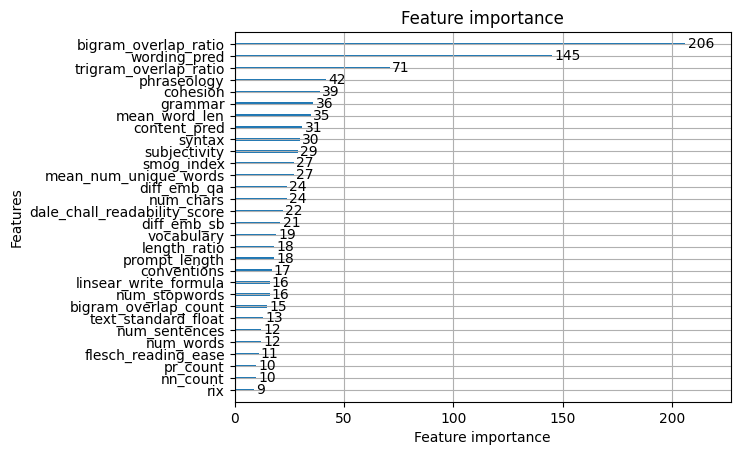

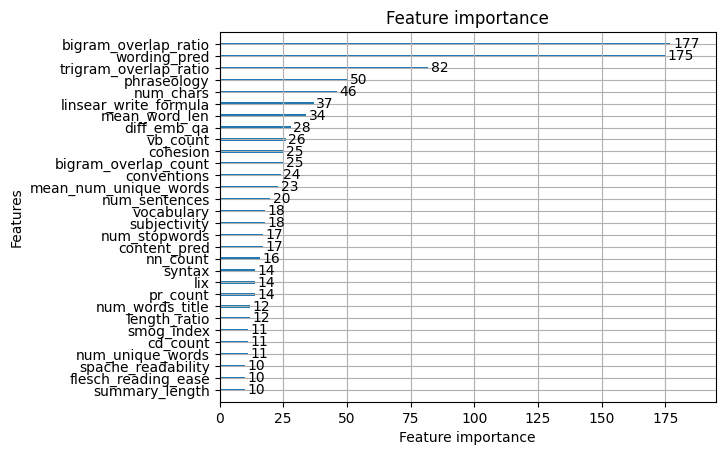

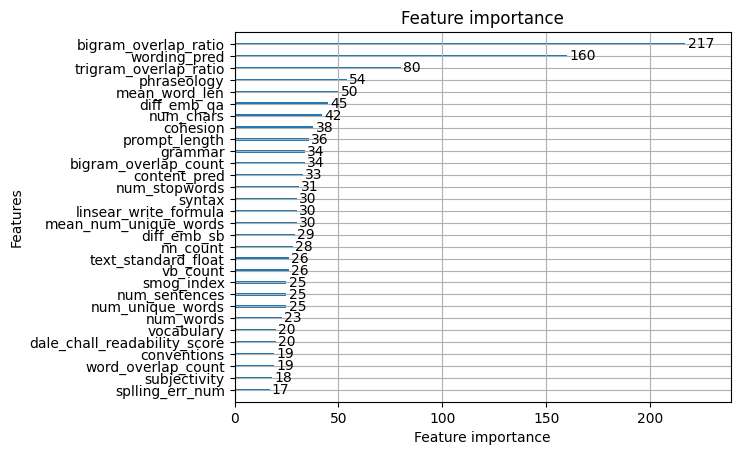

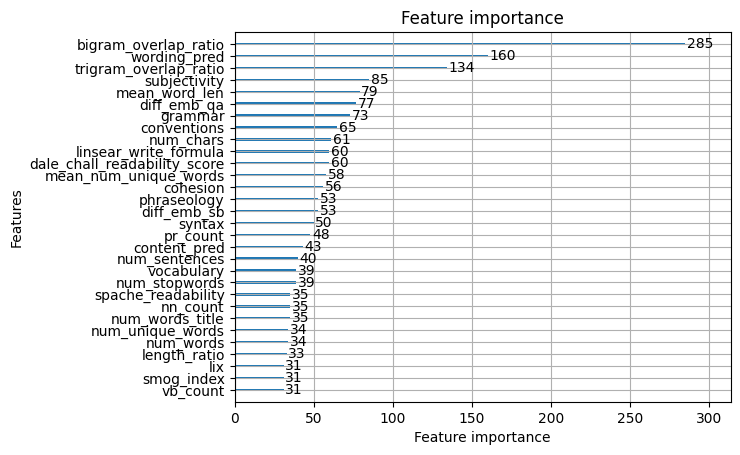

In [232]:
models = []

for fold in range(4):

    X_train_cv = train[train["fold"] != fold][fe_columns]
    y_train_cv = train[train["fold"] != fold][target]

    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
    dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

    evaluation_results = {}
    model = lgb.train(params,
                      num_boost_round=10000,
                      valid_names=['train', 'valid'],
                      train_set=dtrain,
                      valid_sets=dval,
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=30, verbose=True),
                           lgb.log_evaluation(100),
                          lgb.callback.record_evaluation(evaluation_results)
                        ],
                      )
    print(lgb.plot_importance(model,max_num_features=30))
    models.append(model)

In [233]:
rmses = []
preds = []
trues = []
for fold, model in enumerate(models):
    print(fold)
    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    pred = model.predict(X_eval_cv)

    trues.extend(y_eval_cv.values)
    preds.extend(pred)

rmse = np.sqrt(mean_squared_error(trues, preds))
print(rmse)

0
1
2
3
0.5626629038204431


In [234]:
#by fold
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        'random_state': 42,
         'objective': 'regression',
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True)}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [0]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()
study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True) 

[I 2023-09-11 11:03:28,129] A new study created in memory with name: no-name-67586306-4cd8-41e1-92f4-6433c2d08943


[LightGBM] [Warning] lambda_l1 is set=0.010791077479429909, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010791077479429909
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0026393305028075673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026393305028075673


[I 2023-09-11 11:03:28,415] Trial 0 finished with value: 0.53115878372441 and parameters: {'learning_rate': 0.0739823960149328, 'max_depth': 2, 'lambda_l1': 0.010791077479429909, 'lambda_l2': 0.0026393305028075673}. Best is trial 0 with value: 0.53115878372441.


Fold 0 | RMSE: 0.53115878372441
[LightGBM] [Warning] lambda_l1 is set=1.0430794232920195e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0430794232920195e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00035365082107025405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035365082107025405


[I 2023-09-11 11:03:30,122] Trial 1 finished with value: 0.5241239166142454 and parameters: {'learning_rate': 0.12894334695801932, 'max_depth': 16, 'lambda_l1': 1.0430794232920195e-07, 'lambda_l2': 0.00035365082107025405}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.5241239166142454
[LightGBM] [Warning] lambda_l1 is set=0.000213052015492272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000213052015492272
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0004979682596230257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004979682596230257


[I 2023-09-11 11:03:32,300] Trial 2 finished with value: 0.5309737669341509 and parameters: {'learning_rate': 0.4459240794363818, 'max_depth': 15, 'lambda_l1': 0.000213052015492272, 'lambda_l2': 0.0004979682596230257}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.5309737669341509
[LightGBM] [Warning] lambda_l1 is set=0.0019221367465034457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0019221367465034457
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.77420775085653e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.77420775085653e-06


[I 2023-09-11 11:03:33,071] Trial 3 finished with value: 0.6036373280189602 and parameters: {'learning_rate': 0.013346773921375482, 'max_depth': 3, 'lambda_l1': 0.0019221367465034457, 'lambda_l2': 2.77420775085653e-06}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.6036373280189602
[LightGBM] [Warning] lambda_l1 is set=0.02414932367030435, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02414932367030435
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.07479400547657135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07479400547657135


[I 2023-09-11 11:03:34,864] Trial 4 finished with value: 0.8439415269989224 and parameters: {'learning_rate': 0.0031105610546105734, 'max_depth': 15, 'lambda_l1': 0.02414932367030435, 'lambda_l2': 0.07479400547657135}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.8439415269989224


[I 2023-09-11 11:03:35,348] Trial 5 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.909023011996111, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.909023011996111
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.5011956509688875e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5011956509688875e-05


[I 2023-09-11 11:03:36,884] Trial 6 finished with value: 0.5274648202083955 and parameters: {'learning_rate': 0.37778023532820015, 'max_depth': 8, 'lambda_l1': 1.9874228234747518e-08, 'lambda_l2': 3.155256869537891e-07}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.5274648202083955


[I 2023-09-11 11:03:37,373] Trial 7 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=7.181510299980326e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.181510299980326e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.011149127379058639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011149127379058639


[I 2023-09-11 11:03:38,946] Trial 8 finished with value: 0.5252303943230339 and parameters: {'learning_rate': 0.2886332209097575, 'max_depth': 17, 'lambda_l1': 2.1114449995339193, 'lambda_l2': 0.028382421558275847}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.5252303943230339


[I 2023-09-11 11:03:39,387] Trial 9 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=1.0790987828980864e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0790987828980864e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.2869587866893011, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2869587866893011


[I 2023-09-11 11:03:39,921] Trial 10 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:03:40,425] Trial 11 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:03:42,175] Trial 12 finished with value: 0.5251872517827351 and parameters: {'learning_rate': 0.14529162923828912, 'max_depth': 14, 'lambda_l1': 6.699469075520953e-06, 'lambda_l2': 0.0002576607340012505}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.5251872517827351


[I 2023-09-11 11:03:42,712] Trial 13 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=2.602713959669654e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.602713959669654e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.6087641332558452e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6087641332558452e-08


[I 2023-09-11 11:03:43,244] Trial 14 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:03:43,779] Trial 15 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:03:44,323] Trial 16 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:03:46,083] Trial 17 finished with value: 0.5252422599192669 and parameters: {'learning_rate': 0.1931614181875659, 'max_depth': 16, 'lambda_l1': 1.976627066140531e-05, 'lambda_l2': 1.4984267015621987e-05}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.5252422599192669
[LightGBM] [Warning] lambda_l1 is set=4.82163578224785e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.82163578224785e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.656208989196452e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.656208989196452e-07


[I 2023-09-11 11:03:47,702] Trial 18 finished with value: 0.5338133901261729 and parameters: {'learning_rate': 0.4817547774833101, 'max_depth': 20, 'lambda_l1': 4.82163578224785e-07, 'lambda_l2': 9.656208989196452e-07}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.5338133901261729
[LightGBM] [Warning] lambda_l1 is set=2.6206839454770686e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6206839454770686e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.404205361919586e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.404205361919586e-05


[I 2023-09-11 11:03:49,312] Trial 19 finished with value: 0.5274899642239335 and parameters: {'learning_rate': 0.20206871187586964, 'max_depth': 14, 'lambda_l1': 2.6206839454770686e-05, 'lambda_l2': 4.404205361919586e-05}. Best is trial 1 with value: 0.5241239166142454.


Fold 0 | RMSE: 0.5274899642239335


[I 2023-09-11 11:03:49,833] Trial 20 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=8.278735042686711e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.278735042686711e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0015917338170593335, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015917338170593335


[I 2023-09-11 11:03:51,459] Trial 21 finished with value: 0.5227700820153965 and parameters: {'learning_rate': 0.2045715973916119, 'max_depth': 17, 'lambda_l1': 0.0010003486432422742, 'lambda_l2': 0.021948303673137763}. Best is trial 21 with value: 0.5227700820153965.


Fold 0 | RMSE: 0.5227700820153965


[I 2023-09-11 11:03:51,996] Trial 22 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=6.2534892777406264e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2534892777406264e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.005309846044895714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005309846044895714


[I 2023-09-11 11:03:53,654] Trial 23 finished with value: 0.5255841047234868 and parameters: {'learning_rate': 0.20164899222692562, 'max_depth': 13, 'lambda_l1': 0.0003728970197769362, 'lambda_l2': 0.0004623523457914701}. Best is trial 21 with value: 0.5227700820153965.


Fold 0 | RMSE: 0.5255841047234868


[I 2023-09-11 11:03:54,183] Trial 24 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=1.1596260544782197e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1596260544782197e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.04997025497460818, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04997025497460818


[I 2023-09-11 11:03:55,852] Trial 25 finished with value: 0.5291405803839231 and parameters: {'learning_rate': 0.24554088634342097, 'max_depth': 10, 'lambda_l1': 1.0869475307330345e-05, 'lambda_l2': 0.0007591517443345695}. Best is trial 21 with value: 0.5227700820153965.


Fold 0 | RMSE: 0.5291405803839231


[I 2023-09-11 11:03:56,388] Trial 26 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=7.269050486219961e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.269050486219961e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.006612188941118458, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006612188941118458


[I 2023-09-11 11:03:58,006] Trial 27 finished with value: 0.5307095086365061 and parameters: {'learning_rate': 0.3476440041240672, 'max_depth': 14, 'lambda_l1': 5.2000486829732443e-08, 'lambda_l2': 6.902242045892564e-05}. Best is trial 21 with value: 0.5227700820153965.


Fold 0 | RMSE: 0.5307095086365061


[I 2023-09-11 11:03:58,535] Trial 28 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=2.746834674508255e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.746834674508255e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.1607438620233988, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1607438620233988


[I 2023-09-11 11:03:59,062] Trial 29 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:03:59,721] Trial 30 pruned. Trial was pruned at iteration 13.
[I 2023-09-11 11:04:01,665] Trial 31 finished with value: 0.5312690801545795 and parameters: {'learning_rate': 0.3011401380322181, 'max_depth': 16, 'lambda_l1': 0.03387188012342922, 'lambda_l2': 0.015101499550521355}. Best is trial 21 with value: 0.5227700820153965.


Fold 0 | RMSE: 0.5312690801545795
[LightGBM] [Warning] lambda_l1 is set=0.002859273719726967, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002859273719726967
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0009230812524852216, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009230812524852216


[I 2023-09-11 11:04:03,866] Trial 32 finished with value: 0.5258086091543293 and parameters: {'learning_rate': 0.26309742321470514, 'max_depth': 17, 'lambda_l1': 0.002859273719726967, 'lambda_l2': 0.0009230812524852216}. Best is trial 21 with value: 0.5227700820153965.


Fold 0 | RMSE: 0.5258086091543293


[I 2023-09-11 11:04:04,405] Trial 33 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.1556198426230791, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1556198426230791
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00019057378543035997, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019057378543035997


[I 2023-09-11 11:04:06,139] Trial 34 finished with value: 0.5217438004998676 and parameters: {'learning_rate': 0.31806587509401246, 'max_depth': 15, 'lambda_l1': 0.000502194701076074, 'lambda_l2': 0.034636659071898966}. Best is trial 34 with value: 0.5217438004998676.


Fold 0 | RMSE: 0.5217438004998676


[I 2023-09-11 11:04:06,686] Trial 35 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0006808828587610855, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006808828587610855
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.003093379664311005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003093379664311005


[I 2023-09-11 11:04:08,267] Trial 36 finished with value: 0.529569892496314 and parameters: {'learning_rate': 0.37488082595329003, 'max_depth': 11, 'lambda_l1': 0.0015117268098152597, 'lambda_l2': 0.31968573819120266}. Best is trial 34 with value: 0.5217438004998676.


Fold 0 | RMSE: 0.529569892496314


[I 2023-09-11 11:04:08,802] Trial 37 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0002814276744984031, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002814276744984031
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.032219977909336284, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.032219977909336284


[I 2023-09-11 11:04:09,336] Trial 38 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:04:10,997] Trial 39 finished with value: 0.5290305662057231 and parameters: {'learning_rate': 0.35947963648645714, 'max_depth': 19, 'lambda_l1': 3.5803216285046584e-05, 'lambda_l2': 0.10384468320309422}. Best is trial 34 with value: 0.5217438004998676.


Fold 0 | RMSE: 0.5290305662057231


[I 2023-09-11 11:04:11,537] Trial 40 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.005063137815349387, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005063137815349387
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.019137118590760782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019137118590760782


[I 2023-09-11 11:04:13,205] Trial 41 finished with value: 0.5306891382732343 and parameters: {'learning_rate': 0.2841835732850806, 'max_depth': 17, 'lambda_l1': 0.019098323154539087, 'lambda_l2': 0.03804628892311816}. Best is trial 34 with value: 0.5217438004998676.


Fold 0 | RMSE: 0.5306891382732343


[I 2023-09-11 11:04:13,738] Trial 42 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0008434406538493848, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008434406538493848
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.104905481857934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.104905481857934


[I 2023-09-11 11:04:15,372] Trial 43 finished with value: 0.528874829291758 and parameters: {'learning_rate': 0.40756752197080137, 'max_depth': 14, 'lambda_l1': 0.005609195276781323, 'lambda_l2': 0.004952901547837459}. Best is trial 34 with value: 0.5217438004998676.


Fold 0 | RMSE: 0.528874829291758


[I 2023-09-11 11:04:15,926] Trial 44 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.00010576290739089852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010576290739089852
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.01091244860951609, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01091244860951609


[I 2023-09-11 11:04:16,446] Trial 45 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:04:18,050] Trial 46 finished with value: 0.5215484317138507 and parameters: {'learning_rate': 0.2990898903419071, 'max_depth': 15, 'lambda_l1': 0.10071730844690853, 'lambda_l2': 0.017067305949060953}. Best is trial 46 with value: 0.5215484317138507.


Fold 0 | RMSE: 0.5215484317138507
[LightGBM] [Warning] lambda_l1 is set=0.00024017465977100167, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00024017465977100167
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0015584540958710653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015584540958710653


[I 2023-09-11 11:04:19,707] Trial 47 finished with value: 0.5250988756710653 and parameters: {'learning_rate': 0.32078590705246235, 'max_depth': 13, 'lambda_l1': 0.00024017465977100167, 'lambda_l2': 0.0015584540958710653}. Best is trial 46 with value: 0.5215484317138507.


Fold 0 | RMSE: 0.5250988756710653
[LightGBM] [Warning] lambda_l1 is set=0.18132924052567637, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.18132924052567637
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.003446382532814129, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003446382532814129


[I 2023-09-11 11:04:21,228] Trial 48 finished with value: 0.530416008935581 and parameters: {'learning_rate': 0.3363578024311418, 'max_depth': 8, 'lambda_l1': 0.18132924052567637, 'lambda_l2': 0.003446382532814129}. Best is trial 46 with value: 0.5215484317138507.


Fold 0 | RMSE: 0.530416008935581


[I 2023-09-11 11:04:21,763] Trial 49 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.00029291269976120665, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029291269976120665
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.01929063214185702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01929063214185702


In [235]:
optuna.visualization.plot_optimization_history(study)

In [237]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.2990898903419071,
 'max_depth': 15,
 'lambda_l1': 0.10071730844690853,
 'lambda_l2': 0.017067305949060953}

In [238]:
param0 = {
    'boosting_type': 'gbdt',
    'random_state': 42,
    'objective': 'regression',
    'metric': 'rmse',
}
param0['learning_rate']=best_lgbmparams['learning_rate']
param0['max_depth']=best_lgbmparams['max_depth']
param0['lambda_l1']=best_lgbmparams['lambda_l1']
param0['lambda_l2']=best_lgbmparams['lambda_l2']

In [239]:
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        'random_state': 42,
         'objective': 'regression',
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True)}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [1]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()
study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True) 

[I 2023-09-11 11:05:28,543] A new study created in memory with name: no-name-2921580e-2e99-4c22-bc6e-78585835ec5c
[I 2023-09-11 11:05:29,971] Trial 0 finished with value: 0.8558034385495192 and parameters: {'learning_rate': 0.0020335253158529736, 'max_depth': 10, 'lambda_l1': 0.006969611598015441, 'lambda_l2': 0.03351900900226892}. Best is trial 0 with value: 0.8558034385495192.


Fold 1 | RMSE: 0.8558034385495192
[LightGBM] [Warning] lambda_l1 is set=7.903539362743272e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.903539362743272e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.5716756735824373e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.5716756735824373e-08


[I 2023-09-11 11:05:31,712] Trial 1 finished with value: 0.8741215569229622 and parameters: {'learning_rate': 0.001578363620769521, 'max_depth': 15, 'lambda_l1': 7.903539362743272e-08, 'lambda_l2': 2.5716756735824373e-08}. Best is trial 0 with value: 0.8558034385495192.


Fold 1 | RMSE: 0.8741215569229622
[LightGBM] [Warning] lambda_l1 is set=0.04232084488747256, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.04232084488747256
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.2500678089865029, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2500678089865029


[I 2023-09-11 11:05:33,396] Trial 2 finished with value: 0.6451741006242347 and parameters: {'learning_rate': 0.026500756802646463, 'max_depth': 17, 'lambda_l1': 0.04232084488747256, 'lambda_l2': 0.2500678089865029}. Best is trial 2 with value: 0.6451741006242347.


Fold 1 | RMSE: 0.6451741006242347
[LightGBM] [Warning] lambda_l1 is set=7.022572524237727e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.022572524237727e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.3799417464182301, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3799417464182301


[I 2023-09-11 11:05:35,042] Trial 3 finished with value: 0.6436503648890245 and parameters: {'learning_rate': 0.03199326333861807, 'max_depth': 12, 'lambda_l1': 7.022572524237727e-05, 'lambda_l2': 0.3799417464182301}. Best is trial 3 with value: 0.6436503648890245.


Fold 1 | RMSE: 0.6436503648890245
[LightGBM] [Warning] lambda_l1 is set=6.329771052260415e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.329771052260415e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.234510407473356e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.234510407473356e-06


[I 2023-09-11 11:05:37,813] Trial 4 finished with value: 0.8963587651934319 and parameters: {'learning_rate': 0.0010843522449274536, 'max_depth': 14, 'lambda_l1': 6.329771052260415e-05, 'lambda_l2': 7.234510407473356e-06}. Best is trial 3 with value: 0.6436503648890245.


Fold 1 | RMSE: 0.8963587651934319
[LightGBM] [Warning] lambda_l1 is set=1.720040821956361e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.720040821956361e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1699231381820772, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1699231381820772


[I 2023-09-11 11:05:39,348] Trial 5 finished with value: 0.6438928140873869 and parameters: {'learning_rate': 0.13690204283543592, 'max_depth': 15, 'lambda_l1': 1.720040821956361e-07, 'lambda_l2': 1.1699231381820772}. Best is trial 3 with value: 0.6436503648890245.


Fold 1 | RMSE: 0.6438928140873869
[LightGBM] [Warning] lambda_l1 is set=4.186096955113354e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.186096955113354e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.9606649943903508e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9606649943903508e-05


[I 2023-09-11 11:05:40,978] Trial 6 finished with value: 0.6426584193248888 and parameters: {'learning_rate': 0.17787771877741568, 'max_depth': 17, 'lambda_l1': 4.186096955113354e-05, 'lambda_l2': 1.9606649943903508e-05}. Best is trial 6 with value: 0.6426584193248888.


Fold 1 | RMSE: 0.6426584193248888


[I 2023-09-11 11:05:41,470] Trial 7 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=1.1172112018519821e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1172112018519821e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0385436313601497, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0385436313601497


[I 2023-09-11 11:05:41,995] Trial 8 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:05:43,577] Trial 9 finished with value: 0.6491640750599837 and parameters: {'learning_rate': 0.33718589427277534, 'max_depth': 11, 'lambda_l1': 0.3771202093641381, 'lambda_l2': 8.321442509267313e-08}. Best is trial 6 with value: 0.6426584193248888.


Fold 1 | RMSE: 0.6491640750599837
[LightGBM] [Warning] lambda_l1 is set=1.7431762026611433, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7431762026611433
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00018737395981716171, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018737395981716171


[I 2023-09-11 11:05:45,205] Trial 10 finished with value: 0.6410583485241158 and parameters: {'learning_rate': 0.10048350617108988, 'max_depth': 20, 'lambda_l1': 1.7431762026611433, 'lambda_l2': 0.00018737395981716171}. Best is trial 10 with value: 0.6410583485241158.


Fold 1 | RMSE: 0.6410583485241158
[LightGBM] [Warning] lambda_l1 is set=1.2101076614589872, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2101076614589872
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00016269041770424763, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016269041770424763


[I 2023-09-11 11:05:46,751] Trial 11 finished with value: 0.6387912901283228 and parameters: {'learning_rate': 0.10904062652279095, 'max_depth': 20, 'lambda_l1': 1.2101076614589872, 'lambda_l2': 0.00016269041770424763}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6387912901283228
[LightGBM] [Warning] lambda_l1 is set=9.938210929268303, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.938210929268303
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.000808744152519018, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000808744152519018


[I 2023-09-11 11:05:48,158] Trial 12 finished with value: 0.648156398894271 and parameters: {'learning_rate': 0.07814643991588853, 'max_depth': 20, 'lambda_l1': 9.938210929268303, 'lambda_l2': 0.000808744152519018}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.648156398894271


[I 2023-09-11 11:05:48,620] Trial 13 pruned. Trial was pruned at iteration 9.


[LightGBM] [Warning] lambda_l1 is set=9.988002002439671, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.988002002439671
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0008044184536385954, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008044184536385954


[I 2023-09-11 11:05:49,137] Trial 14 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:05:49,658] Trial 15 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:05:50,591] Trial 16 finished with value: 0.6457138190772909 and parameters: {'learning_rate': 0.08020719090552526, 'max_depth': 4, 'lambda_l1': 0.6806684745524456, 'lambda_l2': 0.002942775182687173}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6457138190772909
[LightGBM] [Warning] lambda_l1 is set=0.03212227774927929, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03212227774927929
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.216775345464369e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.216775345464369e-07


[I 2023-09-11 11:05:52,227] Trial 17 finished with value: 0.6498028974426026 and parameters: {'learning_rate': 0.19967790688981937, 'max_depth': 17, 'lambda_l1': 0.03212227774927929, 'lambda_l2': 7.216775345464369e-07}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6498028974426026


[I 2023-09-11 11:05:52,759] Trial 18 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0009932786228103688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0009932786228103688
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.139766980955984e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.139766980955984e-05


[I 2023-09-11 11:05:53,276] Trial 19 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:05:54,916] Trial 20 finished with value: 0.6438935563211033 and parameters: {'learning_rate': 0.12334730397744635, 'max_depth': -1, 'lambda_l1': 0.0438917580854137, 'lambda_l2': 0.00014191360563207663}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6438935563211033
[LightGBM] [Warning] lambda_l1 is set=9.833863245420422e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.833863245420422e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.706313890910903e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.706313890910903e-05


[I 2023-09-11 11:05:56,569] Trial 21 finished with value: 0.6484985490672013 and parameters: {'learning_rate': 0.23030601014095275, 'max_depth': 18, 'lambda_l1': 9.833863245420422e-05, 'lambda_l2': 1.706313890910903e-05}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6484985490672013
[LightGBM] [Warning] lambda_l1 is set=1.3782508318754015e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3782508318754015e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.2239313684556935e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2239313684556935e-05


[I 2023-09-11 11:05:58,147] Trial 22 finished with value: 0.6487729519579442 and parameters: {'learning_rate': 0.14635481880852863, 'max_depth': 13, 'lambda_l1': 1.3782508318754015e-05, 'lambda_l2': 2.2239313684556935e-05}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6487729519579442
[LightGBM] [Warning] lambda_l1 is set=0.00044569049744100673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00044569049744100673
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0003045854717650035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003045854717650035


[I 2023-09-11 11:05:59,706] Trial 23 finished with value: 0.6505837879502951 and parameters: {'learning_rate': 0.2917794509931157, 'max_depth': 16, 'lambda_l1': 0.00044569049744100673, 'lambda_l2': 0.0003045854717650035}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6505837879502951
[LightGBM] [Warning] lambda_l1 is set=0.004602860943889646, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004602860943889646
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.9699585495941907e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9699585495941907e-06


[I 2023-09-11 11:06:01,450] Trial 24 finished with value: 0.6438274529713489 and parameters: {'learning_rate': 0.11501465867894352, 'max_depth': 19, 'lambda_l1': 0.004602860943889646, 'lambda_l2': 1.9699585495941907e-06}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6438274529713489
[LightGBM] [Warning] lambda_l1 is set=3.7775620065190746e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7775620065190746e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0030106322442804163, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0030106322442804163


[I 2023-09-11 11:06:02,984] Trial 25 finished with value: 0.6458684005080332 and parameters: {'learning_rate': 0.20752148195507394, 'max_depth': 18, 'lambda_l1': 3.7775620065190746e-06, 'lambda_l2': 0.0030106322442804163}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6458684005080332


[I 2023-09-11 11:06:03,493] Trial 26 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0002616152153494152, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002616152153494152
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.457776978469955e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.457776978469955e-05


[I 2023-09-11 11:06:03,993] Trial 27 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:06:05,587] Trial 28 finished with value: 0.6487354347609254 and parameters: {'learning_rate': 0.49423897367282443, 'max_depth': 13, 'lambda_l1': 0.08703031534874173, 'lambda_l2': 4.040851056937491e-07}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6487354347609254
[LightGBM] [Warning] lambda_l1 is set=0.009263614079302785, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009263614079302785
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00015959567854098672, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015959567854098672


[I 2023-09-11 11:06:08,120] Trial 29 finished with value: 0.6414343887022896 and parameters: {'learning_rate': 0.1773076890926579, 'max_depth': 18, 'lambda_l1': 0.009263614079302785, 'lambda_l2': 0.00015959567854098672}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6414343887022896


[I 2023-09-11 11:06:08,640] Trial 30 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0106208990839368, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0106208990839368
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.006807702921954927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006807702921954927


[I 2023-09-11 11:06:10,305] Trial 31 finished with value: 0.6486942243593794 and parameters: {'learning_rate': 0.17343765490748028, 'max_depth': 16, 'lambda_l1': 0.007216632802943315, 'lambda_l2': 9.020234135432267e-05}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6486942243593794
[LightGBM] [Warning] lambda_l1 is set=0.1293125313367339, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1293125313367339
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00039265243497117985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039265243497117985


[I 2023-09-11 11:06:12,205] Trial 32 finished with value: 0.6459170747290081 and parameters: {'learning_rate': 0.26527455412489975, 'max_depth': 19, 'lambda_l1': 0.1293125313367339, 'lambda_l2': 0.00039265243497117985}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6459170747290081


[I 2023-09-11 11:06:12,745] Trial 33 pruned. Trial was pruned at iteration 7.


[LightGBM] [Warning] lambda_l1 is set=2.6193265620885304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6193265620885304
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00021796136897498432, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021796136897498432


[I 2023-09-11 11:06:13,284] Trial 34 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:06:13,882] Trial 35 pruned. Trial was pruned at iteration 11.
[I 2023-09-11 11:06:14,420] Trial 36 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:06:14,951] Trial 37 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:06:16,576] Trial 38 finished with value: 0.639427958529193 and parameters: {'learning_rate': 0.19294376412033243, 'max_depth': 11, 'lambda_l1': 0.19107048642112456, 'lambda_l2': 3.739791659602261e-05}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.639427958529193


[I 2023-09-11 11:06:17,057] Trial 39 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.16544033174644482, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.16544033174644482
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0002832483570204066, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002832483570204066


[I 2023-09-11 11:06:17,580] Trial 40 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:06:19,265] Trial 41 finished with value: 0.6448595798984005 and parameters: {'learning_rate': 0.16492323881235815, 'max_depth': 11, 'lambda_l1': 0.2186082415633349, 'lambda_l2': 5.568032477332777e-06}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6448595798984005
[LightGBM] [Warning] lambda_l1 is set=3.604786216654234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.604786216654234
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.1251567631650668e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1251567631650668e-05


[I 2023-09-11 11:06:20,882] Trial 42 finished with value: 0.6404659599311862 and parameters: {'learning_rate': 0.19222608703011612, 'max_depth': 19, 'lambda_l1': 3.604786216654234, 'lambda_l2': 2.1251567631650668e-05}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6404659599311862
[LightGBM] [Warning] lambda_l1 is set=3.4224830805998927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4224830805998927
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.411457744395699e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.411457744395699e-05


[I 2023-09-11 11:06:22,481] Trial 43 finished with value: 0.6465942251359181 and parameters: {'learning_rate': 0.21977120904205238, 'max_depth': 19, 'lambda_l1': 3.4224830805998927, 'lambda_l2': 8.411457744395699e-05}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6465942251359181


[I 2023-09-11 11:06:23,003] Trial 44 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.6275347282686358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6275347282686358
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.9786331236220482e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9786331236220482e-05


[I 2023-09-11 11:06:23,504] Trial 45 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:06:24,001] Trial 46 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:06:25,682] Trial 47 finished with value: 0.6476842873239164 and parameters: {'learning_rate': 0.34732346946748316, 'max_depth': 19, 'lambda_l1': 0.37828034987778564, 'lambda_l2': 5.950064157371274e-06}. Best is trial 11 with value: 0.6387912901283228.


Fold 1 | RMSE: 0.6476842873239164


[I 2023-09-11 11:06:26,204] Trial 48 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.09035934164876776, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.09035934164876776
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=5.942489794226171e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.942489794226171e-05


[I 2023-09-11 11:06:26,712] Trial 49 pruned. Trial was pruned at iteration 5.


In [240]:
optuna.visualization.plot_optimization_history(study)

In [242]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.10904062652279095,
 'max_depth': 20,
 'lambda_l1': 1.2101076614589872,
 'lambda_l2': 0.00016269041770424763}

In [243]:
param1 = {
    'boosting_type': 'gbdt',
    'random_state': 42,
    'objective': 'regression',
    'metric': 'rmse',
}
param1['learning_rate']=best_lgbmparams['learning_rate']
param1['max_depth']=best_lgbmparams['max_depth']
param1['lambda_l1']=best_lgbmparams['lambda_l1']
param1['lambda_l2']=best_lgbmparams['lambda_l2']

In [244]:
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        'random_state': 42,
         'objective': 'regression',
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True)}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [2]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()

In [245]:
study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True)

[I 2023-09-11 11:09:19,624] A new study created in memory with name: no-name-c5220938-39da-4338-a9ab-84c541e60837
[I 2023-09-11 11:09:20,915] Trial 0 finished with value: 0.5778005809880986 and parameters: {'learning_rate': 0.01133945158802273, 'max_depth': 11, 'lambda_l1': 1.5527589578136398, 'lambda_l2': 2.7456766008300013e-06}. Best is trial 0 with value: 0.5778005809880986.


Fold 2 | RMSE: 0.5778005809880986
[LightGBM] [Warning] lambda_l1 is set=8.422140090774891e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.422140090774891e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1143030880681895e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1143030880681895e-07


[I 2023-09-11 11:09:22,512] Trial 1 finished with value: 0.4871872695616181 and parameters: {'learning_rate': 0.13656784467024957, 'max_depth': 17, 'lambda_l1': 8.422140090774891e-06, 'lambda_l2': 1.1143030880681895e-07}. Best is trial 1 with value: 0.4871872695616181.


Fold 2 | RMSE: 0.4871872695616181
[LightGBM] [Warning] lambda_l1 is set=0.00032714906667030084, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00032714906667030084
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.14315382349905542, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14315382349905542


[I 2023-09-11 11:09:24,252] Trial 2 finished with value: 0.6326029259398162 and parameters: {'learning_rate': 0.008493620398508171, 'max_depth': 18, 'lambda_l1': 0.00032714906667030084, 'lambda_l2': 0.14315382349905542}. Best is trial 1 with value: 0.4871872695616181.


Fold 2 | RMSE: 0.6326029259398162
[LightGBM] [Warning] lambda_l1 is set=0.46689749139518727, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.46689749139518727
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.899648935872951e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.899648935872951e-05


[I 2023-09-11 11:09:25,832] Trial 3 finished with value: 0.4908317505122358 and parameters: {'learning_rate': 0.24132222267922984, 'max_depth': 12, 'lambda_l1': 0.46689749139518727, 'lambda_l2': 7.899648935872951e-05}. Best is trial 1 with value: 0.4871872695616181.


Fold 2 | RMSE: 0.4908317505122358
[LightGBM] [Warning] lambda_l1 is set=1.179699553296374e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.179699553296374e-07
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.238201686494391e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.238201686494391e-07


[I 2023-09-11 11:09:27,567] Trial 4 finished with value: 0.6185456537485188 and parameters: {'learning_rate': 0.009122483366225165, 'max_depth': 14, 'lambda_l1': 1.179699553296374e-07, 'lambda_l2': 1.238201686494391e-07}. Best is trial 1 with value: 0.4871872695616181.


Fold 2 | RMSE: 0.6185456537485188
[LightGBM] [Warning] lambda_l1 is set=2.0780635162797293e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0780635162797293e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.5929876275692985, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5929876275692985


[I 2023-09-11 11:09:29,279] Trial 5 finished with value: 0.5257318523316374 and parameters: {'learning_rate': 0.01651062851588417, 'max_depth': 8, 'lambda_l1': 2.0780635162797293e-08, 'lambda_l2': 1.5929876275692985}. Best is trial 1 with value: 0.4871872695616181.


Fold 2 | RMSE: 0.5257318523316374
[LightGBM] [Warning] lambda_l1 is set=3.6458709175602566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6458709175602566
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00029401872037359823, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029401872037359823


[I 2023-09-11 11:09:30,848] Trial 6 finished with value: 0.49063465244110305 and parameters: {'learning_rate': 0.12501330747157005, 'max_depth': 9, 'lambda_l1': 3.6458709175602566, 'lambda_l2': 0.00029401872037359823}. Best is trial 1 with value: 0.4871872695616181.


Fold 2 | RMSE: 0.49063465244110305
[LightGBM] [Warning] lambda_l1 is set=6.829403014089566, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.829403014089566
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.011671220736785745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011671220736785745


[I 2023-09-11 11:09:32,269] Trial 7 finished with value: 0.4902071984675646 and parameters: {'learning_rate': 0.0402694435689431, 'max_depth': 7, 'lambda_l1': 6.829403014089566, 'lambda_l2': 0.011671220736785745}. Best is trial 1 with value: 0.4871872695616181.


Fold 2 | RMSE: 0.4902071984675646
[LightGBM] [Warning] lambda_l1 is set=1.3026121979384093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3026121979384093
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.015569295864037734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015569295864037734


[I 2023-09-11 11:09:33,934] Trial 8 finished with value: 0.49102569706428 and parameters: {'learning_rate': 0.0278197317995061, 'max_depth': 20, 'lambda_l1': 1.3026121979384093, 'lambda_l2': 0.015569295864037734}. Best is trial 1 with value: 0.4871872695616181.


Fold 2 | RMSE: 0.49102569706428


[I 2023-09-11 11:09:34,366] Trial 9 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=1.6668085226780536, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6668085226780536
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.0012814077638307316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012814077638307316


[I 2023-09-11 11:09:34,889] Trial 10 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:09:36,120] Trial 11 finished with value: 0.4835795375635301 and parameters: {'learning_rate': 0.0803375944889583, 'max_depth': 5, 'lambda_l1': 0.005445346544815562, 'lambda_l2': 4.25503167753138e-06}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4835795375635301
[LightGBM] [Warning] lambda_l1 is set=0.0012649344992939188, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0012649344992939188
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.5755588024358618e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5755588024358618e-06


[I 2023-09-11 11:09:37,064] Trial 12 finished with value: 0.4901673957941825 and parameters: {'learning_rate': 0.3081647555752376, 'max_depth': 4, 'lambda_l1': 0.0012649344992939188, 'lambda_l2': 1.5755588024358618e-06}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4901673957941825
[LightGBM] [Warning] lambda_l1 is set=0.010698638213423496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010698638213423496
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.978697368324519e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.978697368324519e-06


[I 2023-09-11 11:09:38,795] Trial 13 finished with value: 0.4845447767611143 and parameters: {'learning_rate': 0.09323128826914168, 'max_depth': 16, 'lambda_l1': 0.010698638213423496, 'lambda_l2': 4.978697368324519e-06}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4845447767611143
[LightGBM] [Warning] lambda_l1 is set=0.017598930152853874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.017598930152853874
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.8438511670516736e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8438511670516736e-05


[I 2023-09-11 11:09:40,564] Trial 14 finished with value: 0.4847025888442466 and parameters: {'learning_rate': 0.06383233690357107, 'max_depth': 15, 'lambda_l1': 0.017598930152853874, 'lambda_l2': 1.8438511670516736e-05}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4847025888442466
[LightGBM] [Warning] lambda_l1 is set=0.02176457674242125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02176457674242125
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1279327320012352e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1279327320012352e-05


[I 2023-09-11 11:09:41,716] Trial 15 finished with value: 0.4965735240319088 and parameters: {'learning_rate': 0.4450994052024542, 'max_depth': 5, 'lambda_l1': 0.02176457674242125, 'lambda_l2': 1.1279327320012352e-05}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4965735240319088
[LightGBM] [Warning] lambda_l1 is set=0.07779689374285183, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07779689374285183
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.82063934877947e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.82063934877947e-07


[I 2023-09-11 11:09:43,488] Trial 16 finished with value: 0.4843867966039561 and parameters: {'learning_rate': 0.08125793922137561, 'max_depth': 0, 'lambda_l1': 0.07779689374285183, 'lambda_l2': 7.82063934877947e-07}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4843867966039561


[I 2023-09-11 11:09:44,026] Trial 17 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.11800582380372564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.11800582380372564
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.665866763279349e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.665866763279349e-07


[I 2023-09-11 11:09:44,771] Trial 18 finished with value: 0.49355555576481797 and parameters: {'learning_rate': 0.18829319504782316, 'max_depth': 2, 'lambda_l1': 0.0019945163986545005, 'lambda_l2': 1.2934577507794884e-08}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.49355555576481797


[I 2023-09-11 11:09:45,328] Trial 19 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.12139024970237104, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12139024970237104
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.424095948420833e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.424095948420833e-05


[I 2023-09-11 11:09:46,475] Trial 20 pruned. Trial was pruned at iteration 27.
[I 2023-09-11 11:09:46,932] Trial 21 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:09:48,545] Trial 22 finished with value: 0.48716193992193246 and parameters: {'learning_rate': 0.12769964739400938, 'max_depth': 11, 'lambda_l1': 0.14213401356929092, 'lambda_l2': 2.021897096115931e-05}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.48716193992193246


[I 2023-09-11 11:09:49,040] Trial 23 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.00563152980853598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00563152980853598
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.573709329576485e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.573709329576485e-07


[I 2023-09-11 11:09:49,753] Trial 24 pruned. Trial was pruned at iteration 19.
[I 2023-09-11 11:09:50,227] Trial 25 pruned. Trial was pruned at iteration 14.
[I 2023-09-11 11:09:50,739] Trial 26 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:09:51,205] Trial 27 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:09:51,722] Trial 28 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:09:53,459] Trial 29 finished with value: 0.485216452273867 and parameters: {'learning_rate': 0.11252554269320221, 'max_depth': 17, 'lambda_l1': 0.0007784497463949486, 'lambda_l2': 2.341885466437999e-06}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.485216452273867


[I 2023-09-11 11:09:53,988] Trial 30 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.006284503586744044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006284503586744044
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00026801692095890564, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00026801692095890564


[I 2023-09-11 11:09:54,578] Trial 31 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:09:56,484] Trial 32 finished with value: 0.4848712938116959 and parameters: {'learning_rate': 0.09620328421185317, 'max_depth': 13, 'lambda_l1': 0.04461146435809526, 'lambda_l2': 7.932337725549896e-06}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4848712938116959
[LightGBM] [Warning] lambda_l1 is set=0.4959910428146293, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4959910428146293
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.273922895945977e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.273922895945977e-07


[I 2023-09-11 11:09:58,088] Trial 33 finished with value: 0.4859539476785608 and parameters: {'learning_rate': 0.1658528154553482, 'max_depth': 16, 'lambda_l1': 0.4959910428146293, 'lambda_l2': 7.273922895945977e-07}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4859539476785608


[I 2023-09-11 11:09:58,609] Trial 34 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.008790472813470108, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008790472813470108
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.827412907025214e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.827412907025214e-05


[I 2023-09-11 11:10:00,394] Trial 35 finished with value: 0.486678126636199 and parameters: {'learning_rate': 0.10934661482053835, 'max_depth': 16, 'lambda_l1': 0.0003169260517261842, 'lambda_l2': 5.680378128261236e-08}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.486678126636199
[LightGBM] [Warning] lambda_l1 is set=0.00230626585805609, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00230626585805609
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.8710124662236317e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8710124662236317e-07


[I 2023-09-11 11:10:02,255] Trial 36 finished with value: 0.4890354539789489 and parameters: {'learning_rate': 0.2732982046008703, 'max_depth': 16, 'lambda_l1': 0.00230626585805609, 'lambda_l2': 1.8710124662236317e-07}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4890354539789489
[LightGBM] [Warning] lambda_l1 is set=0.47686389570018295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.47686389570018295
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.327429608856432e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.327429608856432e-08


[I 2023-09-11 11:10:03,809] Trial 37 finished with value: 0.4870593358993241 and parameters: {'learning_rate': 0.14868997876660678, 'max_depth': 18, 'lambda_l1': 0.47686389570018295, 'lambda_l2': 4.327429608856432e-08}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4870593358993241


[I 2023-09-11 11:10:04,348] Trial 38 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.03915071488288631, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03915071488288631
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.3589714482049267e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3589714482049267e-06


[I 2023-09-11 11:10:04,880] Trial 39 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:10:05,407] Trial 40 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:10:05,945] Trial 41 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:10:06,474] Trial 42 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:10:08,069] Trial 43 finished with value: 0.4899892931065684 and parameters: {'learning_rate': 0.12740266402764544, 'max_depth': 12, 'lambda_l1': 0.021124369676374856, 'lambda_l2': 3.028866809246215e-07}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4899892931065684


[I 2023-09-11 11:10:08,597] Trial 44 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.004400723029986825, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004400723029986825
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2510859006119261e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2510859006119261e-05


[I 2023-09-11 11:10:10,228] Trial 45 finished with value: 0.48812083621643165 and parameters: {'learning_rate': 0.21448340251839343, 'max_depth': 13, 'lambda_l1': 0.22375932341251578, 'lambda_l2': 1.1340081202381642e-06}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.48812083621643165
[LightGBM] [Warning] lambda_l1 is set=1.7786202750757325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7786202750757325
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.8145538640715224e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8145538640715224e-06


[I 2023-09-11 11:10:11,887] Trial 46 finished with value: 0.4886811047204058 and parameters: {'learning_rate': 0.13206806067737092, 'max_depth': 19, 'lambda_l1': 1.7786202750757325, 'lambda_l2': 3.8145538640715224e-06}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.4886811047204058


[I 2023-09-11 11:10:12,416] Trial 47 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.02836285856093125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.02836285856093125
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.000642428473746876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000642428473746876


[I 2023-09-11 11:10:12,936] Trial 48 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:10:14,490] Trial 49 finished with value: 0.49380790407794073 and parameters: {'learning_rate': 0.23031737769463187, 'max_depth': 15, 'lambda_l1': 0.6525387774319883, 'lambda_l2': 2.9047071996146077e-05}. Best is trial 11 with value: 0.4835795375635301.


Fold 2 | RMSE: 0.49380790407794073


In [246]:
optuna.visualization.plot_optimization_history(study)

In [247]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.0803375944889583,
 'max_depth': 5,
 'lambda_l1': 0.005445346544815562,
 'lambda_l2': 4.25503167753138e-06}

In [248]:
param2['learning_rate']=best_lgbmparams['learning_rate']
param2['max_depth']=best_lgbmparams['max_depth']
param2['lambda_l1']=best_lgbmparams['lambda_l1']
param2['lambda_l2']=best_lgbmparams['lambda_l2']

In [249]:
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        'random_state': 42,
         'objective': 'regression',
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True)}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [3]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()

In [250]:
study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True) 

[I 2023-09-11 11:11:09,361] A new study created in memory with name: no-name-817af786-e4d1-4f6e-8999-06d1ec7a4e52


[LightGBM] [Warning] lambda_l1 is set=0.12736766446161488, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12736766446161488
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=3.205946574140238e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.205946574140238e-05


[I 2023-09-11 11:11:10,522] Trial 0 finished with value: 0.6140406853548328 and parameters: {'learning_rate': 0.20641532881363964, 'max_depth': 15, 'lambda_l1': 0.12736766446161488, 'lambda_l2': 3.205946574140238e-05}. Best is trial 0 with value: 0.6140406853548328.


Fold 3 | RMSE: 0.6140406853548328
[LightGBM] [Warning] lambda_l1 is set=0.057218453052827044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.057218453052827044
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.2948267599016058e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2948267599016058e-05


[I 2023-09-11 11:11:12,347] Trial 1 finished with value: 0.8538383584491582 and parameters: {'learning_rate': 0.007362180348584411, 'max_depth': 15, 'lambda_l1': 0.057218453052827044, 'lambda_l2': 1.2948267599016058e-05}. Best is trial 0 with value: 0.6140406853548328.


Fold 3 | RMSE: 0.8538383584491582
[LightGBM] [Warning] lambda_l1 is set=0.31394162067311854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31394162067311854
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.885741242435852e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.885741242435852e-06


[I 2023-09-11 11:11:13,863] Trial 2 finished with value: 0.6129203735642592 and parameters: {'learning_rate': 0.09413921227075284, 'max_depth': -1, 'lambda_l1': 0.31394162067311854, 'lambda_l2': 9.885741242435852e-06}. Best is trial 2 with value: 0.6129203735642592.


Fold 3 | RMSE: 0.6129203735642592
[LightGBM] [Warning] lambda_l1 is set=5.752045166115518e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.752045166115518e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.046174601600807795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046174601600807795


[I 2023-09-11 11:11:15,644] Trial 3 finished with value: 0.6357115717660716 and parameters: {'learning_rate': 0.023341655086782195, 'max_depth': 14, 'lambda_l1': 5.752045166115518e-08, 'lambda_l2': 0.046174601600807795}. Best is trial 2 with value: 0.6129203735642592.


Fold 3 | RMSE: 0.6357115717660716
[LightGBM] [Warning] lambda_l1 is set=0.22105611422382687, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.22105611422382687
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.01141577465783059, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01141577465783059


[I 2023-09-11 11:11:17,064] Trial 4 finished with value: 0.6152129268549411 and parameters: {'learning_rate': 0.194215218943277, 'max_depth': 9, 'lambda_l1': 0.22105611422382687, 'lambda_l2': 0.01141577465783059}. Best is trial 2 with value: 0.6129203735642592.


Fold 3 | RMSE: 0.6152129268549411


[I 2023-09-11 11:11:17,489] Trial 5 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0006524833509424902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006524833509424902
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.03541759666046295, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03541759666046295


[I 2023-09-11 11:11:17,966] Trial 6 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:18,433] Trial 7 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:19,031] Trial 8 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:19,929] Trial 9 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:20,471] Trial 10 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:22,013] Trial 11 finished with value: 0.6199999295603217 and parameters: {'learning_rate': 0.30654377064990324, 'max_depth': 20, 'lambda_l1': 5.822079863211239, 'lambda_l2': 7.95923808835772e-06}. Best is trial 2 with value: 0.6129203735642592.


Fold 3 | RMSE: 0.6199999295603217


[I 2023-09-11 11:11:22,531] Trial 12 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.4331974826005935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4331974826005935
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.498153045157833e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.498153045157833e-06


[I 2023-09-11 11:11:23,065] Trial 13 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:24,688] Trial 14 finished with value: 0.6245576977499396 and parameters: {'learning_rate': 0.43617651238055594, 'max_depth': -1, 'lambda_l1': 0.5432972218996074, 'lambda_l2': 5.089432705908835e-07}. Best is trial 2 with value: 0.6129203735642592.


Fold 3 | RMSE: 0.6245576977499396


[I 2023-09-11 11:11:25,211] Trial 15 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.00996572255808254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00996572255808254
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=0.00021341718577258864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021341718577258864


[I 2023-09-11 11:11:26,117] Trial 16 finished with value: 0.6028061070772335 and parameters: {'learning_rate': 0.45666976895678935, 'max_depth': 4, 'lambda_l1': 2.110086569281875e-05, 'lambda_l2': 3.137015406785869e-06}. Best is trial 16 with value: 0.6028061070772335.


Fold 3 | RMSE: 0.6028061070772335
[LightGBM] [Warning] lambda_l1 is set=2.1784640096891737e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1784640096891737e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.625383409317364e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.625383409317364e-07


[I 2023-09-11 11:11:27,048] Trial 17 finished with value: 0.6024898316365558 and parameters: {'learning_rate': 0.47373160515715723, 'max_depth': 4, 'lambda_l1': 2.1784640096891737e-05, 'lambda_l2': 8.625383409317364e-07}. Best is trial 17 with value: 0.6024898316365558.


Fold 3 | RMSE: 0.6024898316365558
[LightGBM] [Warning] lambda_l1 is set=1.1569015748018604e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1569015748018604e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.547589018133686e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.547589018133686e-07


[I 2023-09-11 11:11:28,142] Trial 18 finished with value: 0.6009660587559418 and parameters: {'learning_rate': 0.47297949697426034, 'max_depth': 5, 'lambda_l1': 1.1569015748018604e-05, 'lambda_l2': 7.547589018133686e-07}. Best is trial 18 with value: 0.6009660587559418.


Fold 3 | RMSE: 0.6009660587559418
[LightGBM] [Warning] lambda_l1 is set=2.1347795336377822e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1347795336377822e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.1651002606861967e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1651002606861967e-07


[I 2023-09-11 11:11:29,276] Trial 19 finished with value: 0.6175158599287152 and parameters: {'learning_rate': 0.2767495056196961, 'max_depth': 5, 'lambda_l1': 2.1347795336377822e-05, 'lambda_l2': 1.1651002606861967e-07}. Best is trial 18 with value: 0.6009660587559418.


Fold 3 | RMSE: 0.6175158599287152
[LightGBM] [Warning] lambda_l1 is set=1.0116854512651159e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0116854512651159e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=9.987848528440168e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.987848528440168e-07


[I 2023-09-11 11:11:29,967] Trial 20 finished with value: 0.5969598610022894 and parameters: {'learning_rate': 0.44932764379106543, 'max_depth': 2, 'lambda_l1': 1.0116854512651159e-05, 'lambda_l2': 9.987848528440168e-07}. Best is trial 20 with value: 0.5969598610022894.


Fold 3 | RMSE: 0.5969598610022894
[LightGBM] [Warning] lambda_l1 is set=1.212035550184766e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.212035550184766e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=8.215954787693318e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.215954787693318e-07


[I 2023-09-11 11:11:30,669] Trial 21 finished with value: 0.6047280791197884 and parameters: {'learning_rate': 0.47507581168259577, 'max_depth': 2, 'lambda_l1': 1.212035550184766e-05, 'lambda_l2': 8.215954787693318e-07}. Best is trial 20 with value: 0.5969598610022894.


Fold 3 | RMSE: 0.6047280791197884


[I 2023-09-11 11:11:31,189] Trial 22 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=2.732037184814473e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.732037184814473e-06
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.829838228287122e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.829838228287122e-08


[I 2023-09-11 11:11:31,916] Trial 23 finished with value: 0.6020559309636433 and parameters: {'learning_rate': 0.4605122656480967, 'max_depth': 2, 'lambda_l1': 9.20892564377108e-05, 'lambda_l2': 9.195492717589485e-07}. Best is trial 20 with value: 0.5969598610022894.


Fold 3 | RMSE: 0.6020559309636433


[I 2023-09-11 11:11:32,374] Trial 24 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.00010396707283016483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00010396707283016483
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=7.668188207747292e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.668188207747292e-08


[I 2023-09-11 11:11:32,827] Trial 25 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:33,306] Trial 26 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:34,659] Trial 27 finished with value: 0.6140398132613606 and parameters: {'learning_rate': 0.3026018747862984, 'max_depth': 6, 'lambda_l1': 2.0485907620476217e-07, 'lambda_l2': 3.590663711897488e-08}. Best is trial 20 with value: 0.5969598610022894.


Fold 3 | RMSE: 0.6140398132613606


[I 2023-09-11 11:11:35,189] Trial 28 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=1.0102255690401261e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0102255690401261e-08
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.8329776191810916e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8329776191810916e-07


[I 2023-09-11 11:11:35,658] Trial 29 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:36,190] Trial 30 pruned. Trial was pruned at iteration 6.
[I 2023-09-11 11:11:37,158] Trial 31 finished with value: 0.6049290651565932 and parameters: {'learning_rate': 0.4683207694642604, 'max_depth': 4, 'lambda_l1': 7.245467693369436e-05, 'lambda_l2': 1.4558715232745323e-06}. Best is trial 20 with value: 0.5969598610022894.


Fold 3 | RMSE: 0.6049290651565932


[I 2023-09-11 11:11:37,639] Trial 32 pruned. Trial was pruned at iteration 7.


[LightGBM] [Warning] lambda_l1 is set=3.6521918262563235e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6521918262563235e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=4.6361121843258154e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.6361121843258154e-08


[I 2023-09-11 11:11:38,169] Trial 33 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:38,633] Trial 34 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:39,171] Trial 35 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:40,043] Trial 36 finished with value: 0.5963158147792528 and parameters: {'learning_rate': 0.3468843205582561, 'max_depth': 3, 'lambda_l1': 0.00019317109310137436, 'lambda_l2': 1.834463388664475e-06}. Best is trial 36 with value: 0.5963158147792528.


Fold 3 | RMSE: 0.5963158147792528


[I 2023-09-11 11:11:40,525] Trial 37 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=0.0001793981723862087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001793981723862087
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=1.8630754727472663e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8630754727472663e-05


[I 2023-09-11 11:11:41,136] Trial 38 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:41,701] Trial 39 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:42,289] Trial 40 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:42,877] Trial 41 pruned. Trial was pruned at iteration 10.
[I 2023-09-11 11:11:43,359] Trial 42 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:43,906] Trial 43 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:44,377] Trial 44 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:46,082] Trial 45 finished with value: 0.60907267699221 and parameters: {'learning_rate': 0.34097390074638456, 'max_depth': 10, 'lambda_l1': 0.00044267679263528133, 'lambda_l2': 3.02566538158498e-06}. Best is trial 36 with value: 0.5963158147792528.


Fold 3 | RMSE: 0.60907267699221


[I 2023-09-11 11:11:46,559] Trial 46 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] lambda_l1 is set=2.828043097917376e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.828043097917376e-05
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] lambda_l2 is set=2.506530445111908e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.506530445111908e-07


[I 2023-09-11 11:11:47,133] Trial 47 pruned. Trial was pruned at iteration 9.
[I 2023-09-11 11:11:47,671] Trial 48 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:11:48,136] Trial 49 pruned. Trial was pruned at iteration 5.


In [251]:
optuna.visualization.plot_optimization_history(study)

In [252]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.3468843205582561,
 'max_depth': 3,
 'lambda_l1': 0.00019317109310137436,
 'lambda_l2': 1.834463388664475e-06}

In [253]:
param3 = {
    'boosting_type': 'gbdt',
    'random_state': 42,
    'objective': 'regression',
    'metric': 'rmse',
}
param3['learning_rate']=best_lgbmparams['learning_rate']
param3['max_depth']=best_lgbmparams['max_depth']
param3['lambda_l1']=best_lgbmparams['lambda_l1']
param3['lambda_l2']=best_lgbmparams['lambda_l2']

{'boosting_type': 'gbdt', 'random_state': 42, 'objective': 'regression', 'metric': 'rmse', 'learning_rate': 0.2990898903419071, 'max_depth': 15, 'lambda_l1': 0.10071730844690853, 'lambda_l2': 0.017067305949060953}
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7541
[LightGBM] [Info] Number of data points in the train set: 5108, number of used features: 45
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -0.031791
Training until validation scores don't improve for 

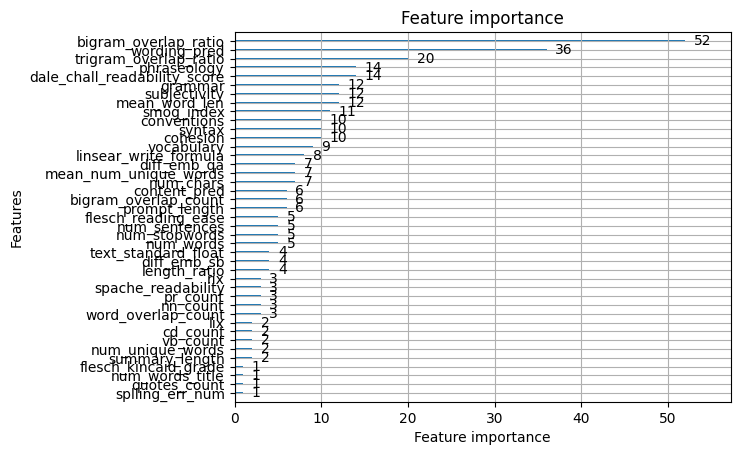

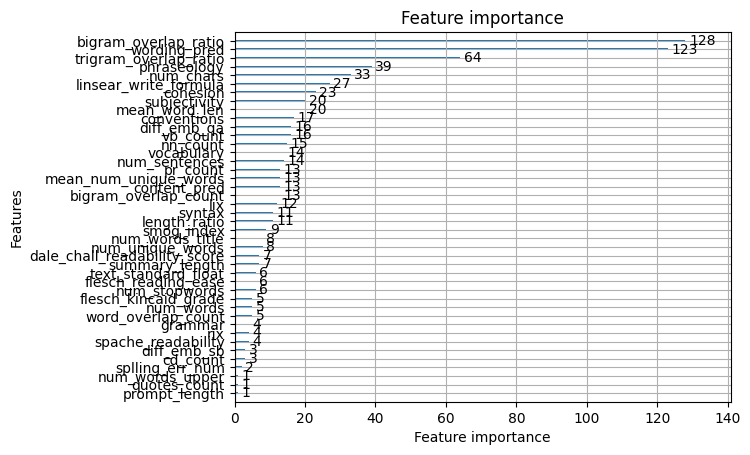

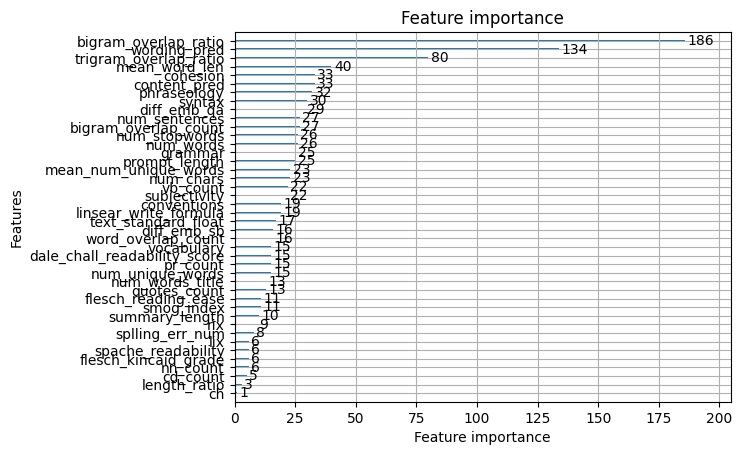

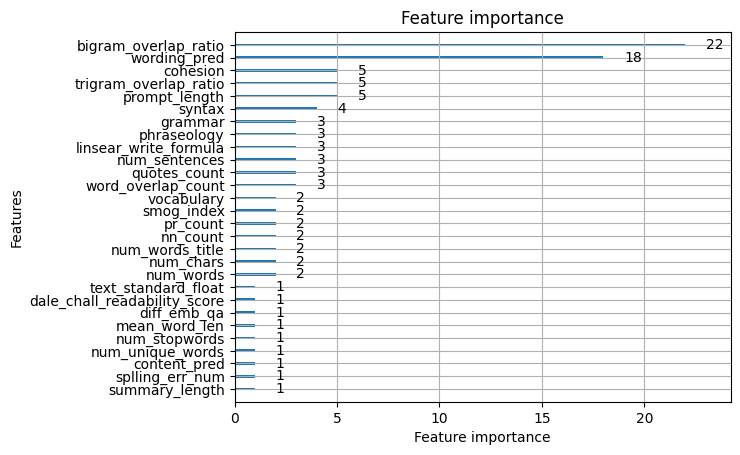

In [254]:
param_dic={}
param_dic['0']=param0
param_dic['1']=param1
param_dic['2']=param2
param_dic['3']=param3


models = []

for fold in range(4):
    
    params=param_dic['%s'%str(fold)]
    print(params)

    X_train_cv = train[train["fold"] != fold][fe_columns]
    y_train_cv = train[train["fold"] != fold][target]

    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
    dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

    evaluation_results = {}
    model = lgb.train(params,
                      num_boost_round=10000,
                      valid_names=['train', 'valid'],
                      train_set=dtrain,
                      valid_sets=dval,
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=30, verbose=True),
                           lgb.log_evaluation(100),
                          lgb.callback.record_evaluation(evaluation_results)
                        ],
                      )
    print(lgb.plot_importance(model))
    models.append(model)

In [255]:
rmses = []
preds = []
trues = []
for fold, model in enumerate(models):
    print(fold)
    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    pred = model.predict(X_eval_cv)

    trues.extend(y_eval_cv.values)
    preds.extend(pred)

rmse = np.sqrt(mean_squared_error(trues, preds))
print(rmse)

0
1
2
3
0.5589209147474825


In [256]:
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "n_estimators": trial.suggest_int("n_estimators", 10, 4000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 2000),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        'feature_fraction_bynode': trial.suggest_float("feature_fraction_bynode", 0.4, 1.0),
        'min_sum_hessian_in_leaf':trial.suggest_int("min_sum_hessian_in_leaf", 10, 100),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [0,1,2,3]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()

In [257]:
study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True) 

[I 2023-09-11 11:12:43,816] A new study created in memory with name: no-name-3a22e749-24b2-4c42-b28d-4bb9aa16c6c7


[LightGBM] [Warning] feature_fraction is set=0.7354084870160067, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7354084870160067
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=263
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=37, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=37
[LightGBM] [Warning] lambda_l2 is set=6.903969927410305e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.903969927410305e-08
[LightGBM] [Warning] bagging_fraction is set=0.867989216428071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.867989216428071
[LightGBM] [Warning] lambda_l1 is set=7.871418168789627e-06, reg_alpha=0.0 will be 

[I 2023-09-11 11:12:46,290] Trial 0 finished with value: 0.5877487735232708 and parameters: {'learning_rate': 0.13657976795477694, 'max_depth': 2, 'lambda_l1': 7.871418168789627e-06, 'lambda_l2': 6.903969927410305e-08, 'num_leaves': 381, 'n_estimators': 2114, 'min_data_in_leaf': 263, 'feature_fraction': 0.7354084870160067, 'feature_fraction_bynode': 0.986824521289757, 'min_sum_hessian_in_leaf': 37, 'bagging_fraction': 0.867989216428071, 'bagging_freq': 4}. Best is trial 0 with value: 0.5877487735232708.


Fold 3 | RMSE: 0.6265088902424617
[LightGBM] [Warning] feature_fraction is set=0.627929087426428, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.627929087426428
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=1549, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1549
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=58, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=58
[LightGBM] [Warning] lambda_l2 is set=2.708219757789585, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.708219757789585
[LightGBM] [Warning] bagging_fraction is set=0.9270849177330792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9270849177330792
[LightGBM] [Warning] lambda_l1 is set=2.234788789438342

[I 2023-09-11 11:12:49,283] Trial 1 finished with value: 0.6950957636100797 and parameters: {'learning_rate': 0.11471188732460111, 'max_depth': 7, 'lambda_l1': 2.2347887894383425e-05, 'lambda_l2': 2.708219757789585, 'num_leaves': 793, 'n_estimators': 780, 'min_data_in_leaf': 1549, 'feature_fraction': 0.627929087426428, 'feature_fraction_bynode': 0.4211189614563037, 'min_sum_hessian_in_leaf': 58, 'bagging_fraction': 0.9270849177330792, 'bagging_freq': 5}. Best is trial 0 with value: 0.5877487735232708.


Fold 3 | RMSE: 0.7799694067760558
[LightGBM] [Warning] feature_fraction is set=0.5407529431047371, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5407529431047371
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1122, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1122
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=13, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=13
[LightGBM] [Warning] lambda_l2 is set=2.957387817875559e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.957387817875559e-07
[LightGBM] [Warning] bagging_fraction is set=0.4348760988550592, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4348760988550592
[LightGBM] [Warning] lambda_l1 is set=6.81021

[I 2023-09-11 11:12:51,708] Trial 2 finished with value: 0.8123545693110819 and parameters: {'learning_rate': 0.00837225027831006, 'max_depth': 17, 'lambda_l1': 6.810219834501488e-07, 'lambda_l2': 2.957387817875559e-07, 'num_leaves': 481, 'n_estimators': 376, 'min_data_in_leaf': 1122, 'feature_fraction': 0.5407529431047371, 'feature_fraction_bynode': 0.5290313509487617, 'min_sum_hessian_in_leaf': 13, 'bagging_fraction': 0.4348760988550592, 'bagging_freq': 7}. Best is trial 0 with value: 0.5877487735232708.


Fold 3 | RMSE: 0.9458584626386437
[LightGBM] [Warning] feature_fraction is set=0.7613211662552042, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7613211662552042
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=399, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=399
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=40, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=40
[LightGBM] [Warning] lambda_l2 is set=4.073432259605994e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.073432259605994e-08
[LightGBM] [Warning] bagging_fraction is set=0.5420778519365703, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5420778519365703
[LightGBM] [Warning] lambda_l1 is set=0.0664375

[I 2023-09-11 11:12:57,132] Trial 3 finished with value: 0.6244142463308304 and parameters: {'learning_rate': 0.03205206202159359, 'max_depth': 16, 'lambda_l1': 0.06643757813036852, 'lambda_l2': 4.073432259605994e-08, 'num_leaves': 586, 'n_estimators': 750, 'min_data_in_leaf': 399, 'feature_fraction': 0.7613211662552042, 'feature_fraction_bynode': 0.5958364466092078, 'min_sum_hessian_in_leaf': 40, 'bagging_fraction': 0.5420778519365703, 'bagging_freq': 5}. Best is trial 0 with value: 0.5877487735232708.


Fold 3 | RMSE: 0.6735817671526949
[LightGBM] [Warning] feature_fraction is set=0.6609357621529468, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6609357621529468
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=556, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=556
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=45, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=0.0623891881011169, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0623891881011169
[LightGBM] [Warning] bagging_fraction is set=0.8036497721470753, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8036497721470753
[LightGBM] [Warning] lambda_l1 is set=0.0383499484720

[I 2023-09-11 11:13:09,479] Trial 4 finished with value: 0.6231975074702806 and parameters: {'learning_rate': 0.004562540255874567, 'max_depth': 2, 'lambda_l1': 0.038349948472017094, 'lambda_l2': 0.0623891881011169, 'num_leaves': 838, 'n_estimators': 2057, 'min_data_in_leaf': 556, 'feature_fraction': 0.6609357621529468, 'feature_fraction_bynode': 0.9975327657628567, 'min_sum_hessian_in_leaf': 45, 'bagging_fraction': 0.8036497721470753, 'bagging_freq': 4}. Best is trial 0 with value: 0.5877487735232708.


Fold 3 | RMSE: 0.6793327134333725


[I 2023-09-11 11:13:09,900] Trial 5 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.9970931185271519, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9970931185271519
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=1907, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1907
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=93, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=93
[LightGBM] [Warning] lambda_l2 is set=6.350520879291508e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.350520879291508e-07
[LightGBM] [Warning] bagging_fraction is set=0.9383791170931449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9383791170931449
[LightGBM] [Warning] lambda_l1 is set=6.851993970014746e-05, reg_alpha=0.0 will

[I 2023-09-11 11:13:13,973] Trial 6 finished with value: 0.582972313456998 and parameters: {'learning_rate': 0.2311905926815652, 'max_depth': 8, 'lambda_l1': 8.247046459315323, 'lambda_l2': 3.4371698312162557, 'num_leaves': 883, 'n_estimators': 1257, 'min_data_in_leaf': 115, 'feature_fraction': 0.5379916304389282, 'feature_fraction_bynode': 0.7280839681898269, 'min_sum_hessian_in_leaf': 51, 'bagging_fraction': 0.7104581634275924, 'bagging_freq': 7}. Best is trial 6 with value: 0.582972313456998.


Fold 3 | RMSE: 0.6227301013817128


[I 2023-09-11 11:13:14,416] Trial 7 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.5663158653851923, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5663158653851923
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1273, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1273
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=64, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=64
[LightGBM] [Warning] lambda_l2 is set=4.5401633410994045e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5401633410994045e-06
[LightGBM] [Warning] bagging_fraction is set=0.8237682581267726, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8237682581267726
[LightGBM] [Warning] lambda_l1 is set=0.03283350415943756, reg_alpha=0.0 will

[I 2023-09-11 11:13:14,944] Trial 8 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:13:15,380] Trial 9 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:13:16,013] Trial 10 pruned. Trial was pruned at iteration 40.
[I 2023-09-11 11:13:16,566] Trial 11 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.5633935716678802
[LightGBM] [Warning] feature_fraction is set=0.5184705140368351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5184705140368351
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=316, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=316
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=36, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=36
[LightGBM] [Warning] lambda_l2 is set=1.6458871944661875, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6458871944661875
[LightGBM] [Warning] bagging_fraction is set=0.9946454924089452, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9946454924089452
[LightGBM] [Warning] lambda_l1 is set=4.6596353475519

[I 2023-09-11 11:13:20,671] Trial 12 finished with value: 0.5966804969451911 and parameters: {'learning_rate': 0.2512553366852199, 'max_depth': 6, 'lambda_l1': 4.659635347551947, 'lambda_l2': 1.6458871944661875, 'num_leaves': 385, 'n_estimators': 1515, 'min_data_in_leaf': 316, 'feature_fraction': 0.5184705140368351, 'feature_fraction_bynode': 0.8599579721316055, 'min_sum_hessian_in_leaf': 36, 'bagging_fraction': 0.9946454924089452, 'bagging_freq': 5}. Best is trial 6 with value: 0.582972313456998.


Fold 3 | RMSE: 0.6360902092124128
[LightGBM] [Warning] feature_fraction is set=0.6127307216185583, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6127307216185583
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=810, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=810
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=79, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=79
[LightGBM] [Warning] lambda_l2 is set=0.015449420295511752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015449420295511752
[LightGBM] [Warning] bagging_fraction is set=0.7483839897014716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7483839897014716
[LightGBM] [Warning] lambda_l1 is set=0.000766567

[I 2023-09-11 11:13:21,359] Trial 13 pruned. Trial was pruned at iteration 54.


Fold 0 | RMSE: 0.5450538891681181
[LightGBM] [Warning] feature_fraction is set=0.6790551017168761, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6790551017168761
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=222, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=222
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=25, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=25
[LightGBM] [Warning] lambda_l2 is set=4.850928371387174e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.850928371387174e-05
[LightGBM] [Warning] bagging_fraction is set=0.6269543282360014, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6269543282360014
[LightGBM] [Warning] lambda_l1 is set=1.3723035

[I 2023-09-11 11:13:26,092] Trial 14 finished with value: 0.5933218885709126 and parameters: {'learning_rate': 0.09234919387635988, 'max_depth': 20, 'lambda_l1': 1.3723035215562158e-06, 'lambda_l2': 4.850928371387174e-05, 'num_leaves': 269, 'n_estimators': 2039, 'min_data_in_leaf': 222, 'feature_fraction': 0.6790551017168761, 'feature_fraction_bynode': 0.734444659130583, 'min_sum_hessian_in_leaf': 25, 'bagging_fraction': 0.6269543282360014, 'bagging_freq': 6}. Best is trial 6 with value: 0.582972313456998.


Fold 3 | RMSE: 0.6349395489797107
[LightGBM] [Warning] feature_fraction is set=0.4787584228855884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4787584228855884
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=635, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=635
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=49, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=49
[LightGBM] [Warning] lambda_l2 is set=9.323936525236252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.323936525236252
[LightGBM] [Warning] bagging_fraction is set=0.7389887993608827, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7389887993608827
[LightGBM] [Warning] lambda_l1 is set=0.565200479320317

[I 2023-09-11 11:13:26,799] Trial 15 pruned. Trial was pruned at iteration 62.


Fold 0 | RMSE: 0.5376515412765196
[LightGBM] [Warning] feature_fraction is set=0.5842938712229502, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5842938712229502
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=214, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=214
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=26, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=26
[LightGBM] [Warning] lambda_l2 is set=0.1836666712339416, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1836666712339416
[LightGBM] [Warning] bagging_fraction is set=0.8678523784362397, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8678523784362397
[LightGBM] [Warning] lambda_l1 is set=0.0046866791287

[I 2023-09-11 11:13:31,037] Trial 16 finished with value: 0.5942576108186193 and parameters: {'learning_rate': 0.24351337664194994, 'max_depth': 9, 'lambda_l1': 0.00468667912876783, 'lambda_l2': 0.1836666712339416, 'num_leaves': 996, 'n_estimators': 2522, 'min_data_in_leaf': 214, 'feature_fraction': 0.5842938712229502, 'feature_fraction_bynode': 0.9372995589786549, 'min_sum_hessian_in_leaf': 26, 'bagging_fraction': 0.8678523784362397, 'bagging_freq': 6}. Best is trial 6 with value: 0.582972313456998.


Fold 3 | RMSE: 0.6460349593668315


[I 2023-09-11 11:13:31,566] Trial 17 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.7316090314501438, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7316090314501438
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=419, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=419
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=98, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=98
[LightGBM] [Warning] lambda_l2 is set=0.0024118080417896578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024118080417896578
[LightGBM] [Warning] bagging_fraction is set=0.5949645761550963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5949645761550963
[LightGBM] [Warning] lambda_l1 is set=7.7815052315487785, reg_alpha=0.0 will be i

[I 2023-09-11 11:13:32,106] Trial 18 pruned. Trial was pruned at iteration 10.
[I 2023-09-11 11:13:32,632] Trial 19 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.5376659314011036
[LightGBM] [Warning] feature_fraction is set=0.6875556909063353, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6875556909063353
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=135, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=135
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=23, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=23
[LightGBM] [Warning] lambda_l2 is set=0.00022510346104297435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022510346104297435
[LightGBM] [Warning] bagging_fraction is set=0.7705109972901365, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7705109972901365
[LightGBM] [Warning] lambda_l1 is set=0.53961

[I 2023-09-11 11:13:37,949] Trial 20 finished with value: 0.5826867198419219 and parameters: {'learning_rate': 0.16540918818367056, 'max_depth': 14, 'lambda_l1': 0.5396150103955288, 'lambda_l2': 0.00022510346104297435, 'num_leaves': 215, 'n_estimators': 2174, 'min_data_in_leaf': 135, 'feature_fraction': 0.6875556909063353, 'feature_fraction_bynode': 0.7867443730621713, 'min_sum_hessian_in_leaf': 23, 'bagging_fraction': 0.7705109972901365, 'bagging_freq': 7}. Best is trial 20 with value: 0.5826867198419219.


Fold 3 | RMSE: 0.6204288439746017
[LightGBM] [Warning] feature_fraction is set=0.6865063947846134, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6865063947846134
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=134, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=134
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=23, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=23
[LightGBM] [Warning] lambda_l2 is set=0.00037763223000088155, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00037763223000088155
[LightGBM] [Warning] bagging_fraction is set=0.7795098646195431, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7795098646195431
[LightGBM] [Warning] lambda_l1 is set=1.00108

[I 2023-09-11 11:13:43,017] Trial 21 finished with value: 0.5844559635624242 and parameters: {'learning_rate': 0.15580495914595022, 'max_depth': 14, 'lambda_l1': 1.0010897311969547, 'lambda_l2': 0.00037763223000088155, 'num_leaves': 183, 'n_estimators': 2155, 'min_data_in_leaf': 134, 'feature_fraction': 0.6865063947846134, 'feature_fraction_bynode': 0.8030431697477001, 'min_sum_hessian_in_leaf': 23, 'bagging_fraction': 0.7795098646195431, 'bagging_freq': 7}. Best is trial 20 with value: 0.5826867198419219.


Fold 3 | RMSE: 0.6229170265798134
[LightGBM] [Warning] feature_fraction is set=0.6014517230269592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6014517230269592
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=19, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=19
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=21, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=21
[LightGBM] [Warning] lambda_l2 is set=0.00035212761587078843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00035212761587078843
[LightGBM] [Warning] bagging_fraction is set=0.7725498884679451, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7725498884679451
[LightGBM] [Warning] lambda_l1 is set=0.6357135

[I 2023-09-11 11:13:44,300] Trial 22 pruned. Trial was pruned at iteration 27.


Fold 0 | RMSE: 0.539761969210979
[LightGBM] [Warning] feature_fraction is set=0.6846070416266544, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6846070416266544
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=107, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=107
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=0.025369217165073392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025369217165073392
[LightGBM] [Warning] bagging_fraction is set=0.6814974947380851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6814974947380851
[LightGBM] [Warning] lambda_l1 is set=0.8761655864

[I 2023-09-11 11:13:49,161] Trial 23 finished with value: 0.5887639893265453 and parameters: {'learning_rate': 0.17189049968859207, 'max_depth': 14, 'lambda_l1': 0.8761655864791161, 'lambda_l2': 0.025369217165073392, 'num_leaves': 156, 'n_estimators': 3039, 'min_data_in_leaf': 107, 'feature_fraction': 0.6846070416266544, 'feature_fraction_bynode': 0.7092303820883216, 'min_sum_hessian_in_leaf': 10, 'bagging_fraction': 0.6814974947380851, 'bagging_freq': 7}. Best is trial 20 with value: 0.5826867198419219.


Fold 3 | RMSE: 0.6301640378137872


[I 2023-09-11 11:13:49,735] Trial 24 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] feature_fraction is set=0.5410680562467193, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5410680562467193
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=463, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=463
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=29, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=29
[LightGBM] [Warning] lambda_l2 is set=0.3071981104887866, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3071981104887866
[LightGBM] [Warning] bagging_fraction is set=0.7269760110794806, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7269760110794806
[LightGBM] [Warning] lambda_l1 is set=3.940734850582747, reg_alpha=0.0 will be ignored.

[I 2023-09-11 11:13:50,287] Trial 25 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:13:50,822] Trial 26 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:13:51,379] Trial 27 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:13:51,958] Trial 28 pruned. Trial was pruned at iteration 11.
[I 2023-09-11 11:13:52,507] Trial 29 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.547777984166755
[LightGBM] [Warning] feature_fraction is set=0.4386897487327439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4386897487327439
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=169, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=169
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] lambda_l2 is set=3.7281340738770172e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.7281340738770172e-06
[LightGBM] [Warning] bagging_fraction is set=0.708713020181334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.708713020181334
[LightGBM] [Warning] lambda_l1 is set=8.06452005

[I 2023-09-11 11:13:57,528] Trial 30 finished with value: 0.5944196202884382 and parameters: {'learning_rate': 0.3432895822062453, 'max_depth': 8, 'lambda_l1': 8.064520059051176, 'lambda_l2': 3.7281340738770172e-06, 'num_leaves': 92, 'n_estimators': 1882, 'min_data_in_leaf': 169, 'feature_fraction': 0.4386897487327439, 'feature_fraction_bynode': 0.6728321920297536, 'min_sum_hessian_in_leaf': 68, 'bagging_fraction': 0.708713020181334, 'bagging_freq': 7}. Best is trial 20 with value: 0.5826867198419219.


Fold 3 | RMSE: 0.6166546386906553


[I 2023-09-11 11:13:58,078] Trial 31 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.6225954082849019, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6225954082849019
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=291, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=291
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=55, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=55
[LightGBM] [Warning] lambda_l2 is set=1.002488898084258, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.002488898084258
[LightGBM] [Warning] bagging_fraction is set=0.8925272269859077, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8925272269859077
[LightGBM] [Warning] lambda_l1 is set=0.34222189424941407, reg_alpha=0.0 will be ignored.

[I 2023-09-11 11:13:59,137] Trial 32 finished with value: 0.6020130313276897 and parameters: {'learning_rate': 0.17044181410719422, 'max_depth': 7, 'lambda_l1': 2.2208254117295514, 'lambda_l2': 9.606805892769149, 'num_leaves': 419, 'n_estimators': 12, 'min_data_in_leaf': 127, 'feature_fraction': 0.779811416337033, 'feature_fraction_bynode': 0.9429481197395075, 'min_sum_hessian_in_leaf': 50, 'bagging_fraction': 0.844582580402517, 'bagging_freq': 5}. Best is trial 20 with value: 0.5826867198419219.


Fold 2 | RMSE: 0.5172071367424113
[LightGBM] [Warning] feature_fraction is set=0.779811416337033, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.779811416337033
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=127, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=127
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=9.606805892769149, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.606805892769149
[LightGBM] [Warning] bagging_fraction is set=0.844582580402517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.844582580402517
[LightGBM] [Warning] lambda_l1 is set=2.2208254117295514, r

[I 2023-09-11 11:13:59,697] Trial 33 pruned. Trial was pruned at iteration 7.


[LightGBM] [Warning] feature_fraction is set=0.7067450424780792, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7067450424780792
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=428, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=428
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=38, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=38
[LightGBM] [Warning] lambda_l2 is set=8.925711113732478e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.925711113732478e-08
[LightGBM] [Warning] bagging_fraction is set=0.7801189024250403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7801189024250403
[LightGBM] [Warning] lambda_l1 is set=0.06357971516419407, reg_alpha=0.0 will be 

[I 2023-09-11 11:14:00,267] Trial 34 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:14:00,813] Trial 35 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:14:01,363] Trial 36 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:14:02,065] Trial 37 pruned. Trial was pruned at iteration 9.
[I 2023-09-11 11:14:02,621] Trial 38 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:14:03,164] Trial 39 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:14:03,715] Trial 40 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:14:04,302] Trial 41 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:14:05,826] Trial 42 pruned. Trial was pruned at iteration 21.
[I 2023-09-11 11:14:06,407] Trial 43 pruned. Trial was pruned at iteration 7.
[I 2023-09-11 11:14:07,000] Trial 44 pruned. Trial was pruned at iteration 5.


Fold 0 | RMSE: 0.5331684226041359
[LightGBM] [Warning] feature_fraction is set=0.7915775071392515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7915775071392515
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.00015788256340489926, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00015788256340489926
[LightGBM] [Warning] bagging_fraction is set=0.6716246715678453, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6716246715678453
[LightGBM] [Warning] lambda_l1 is set=8.91156

[I 2023-09-11 11:14:12,009] Trial 45 finished with value: 0.5775978974128196 and parameters: {'learning_rate': 0.22697195879617496, 'max_depth': 17, 'lambda_l1': 8.911566909128656, 'lambda_l2': 0.00015788256340489926, 'num_leaves': 296, 'n_estimators': 3138, 'min_data_in_leaf': 100, 'feature_fraction': 0.7915775071392515, 'feature_fraction_bynode': 0.6835887499558416, 'min_sum_hessian_in_leaf': 20, 'bagging_fraction': 0.6716246715678453, 'bagging_freq': 6}. Best is trial 45 with value: 0.5775978974128196.


Fold 3 | RMSE: 0.6195753148127181


[I 2023-09-11 11:14:12,576] Trial 46 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.807151541311984, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.807151541311984
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=371, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=371
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=63, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=63
[LightGBM] [Warning] lambda_l2 is set=0.0001142124385416488, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001142124385416488
[LightGBM] [Warning] bagging_fraction is set=0.7212014466181598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7212014466181598
[LightGBM] [Warning] lambda_l1 is set=9.51006305282135, reg_alpha=0.0 will be ignor

[I 2023-09-11 11:14:13,155] Trial 47 pruned. Trial was pruned at iteration 9.
[I 2023-09-11 11:14:13,825] Trial 48 pruned. Trial was pruned at iteration 23.
[I 2023-09-11 11:14:14,599] Trial 49 pruned. Trial was pruned at iteration 26.


In [258]:
optuna.visualization.plot_optimization_history(study)

In [259]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.22697195879617496,
 'max_depth': 17,
 'lambda_l1': 8.911566909128656,
 'lambda_l2': 0.00015788256340489926,
 'num_leaves': 296,
 'n_estimators': 3138,
 'min_data_in_leaf': 100,
 'feature_fraction': 0.7915775071392515,
 'feature_fraction_bynode': 0.6835887499558416,
 'min_sum_hessian_in_leaf': 20,
 'bagging_fraction': 0.6716246715678453,
 'bagging_freq': 6}

In [260]:
params = {
    'boosting': 'gbdt',
    "metric": "rmse",
    "verbosity": -1,
    'seed':42,
    'feature_fraction_seed': 42,
    'bagging_seed': 42,
    'drop_seed': 42,
    'data_random_seed': 42}
params['learning_rate']=best_lgbmparams['learning_rate']
params['max_depth']=best_lgbmparams['max_depth']
params['lambda_l1']=best_lgbmparams['lambda_l1']
params['lambda_l2']=best_lgbmparams['lambda_l2']
params['num_leaves']=best_lgbmparams['num_leaves']
params['min_data_in_leaf']=best_lgbmparams['min_data_in_leaf']
params['feature_fraction']=best_lgbmparams['feature_fraction']
params['feature_fraction_bynode']=best_lgbmparams['feature_fraction_bynode']
params['min_sum_hessian_in_leaf']=best_lgbmparams['min_sum_hessian_in_leaf']
params['bagging_fraction']=best_lgbmparams['bagging_fraction']
params['bagging_freq']=best_lgbmparams['bagging_freq']

In [261]:
models = []

for fold in range(4):

    X_train_cv = train[train["fold"] != fold][fe_columns]
    y_train_cv = train[train["fold"] != fold][target]

    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
    dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

    evaluation_results = {}
    model = lgb.train(params,
                      num_boost_round=10000,
                      valid_names=['train', 'valid'],
                      train_set=dtrain,
                      valid_sets=dval,
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=30, verbose=True),
                           lgb.log_evaluation(100),
                          lgb.callback.record_evaluation(evaluation_results)
                        ],
                      )
    models.append(model)

Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[13]	train's rmse: 0.533168
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[11]	train's rmse: 0.659532
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[23]	train's rmse: 0.500084
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[41]	train's rmse: 0.619575


In [262]:
rmses = []
preds = []
trues = []
for fold, model in enumerate(models):
    print(fold)
    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    pred = model.predict(X_eval_cv)

    trues.extend(y_eval_cv.values)
    preds.extend(pred)

rmse = np.sqrt(mean_squared_error(trues, preds))
print(rmse)

0
1
2
3
0.5764873969916389


In [264]:
# fold:0
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "n_estimators": trial.suggest_int("n_estimators", 10, 4000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 2000),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        'feature_fraction_bynode': trial.suggest_float("feature_fraction_bynode", 0.4, 1.0),
        'min_sum_hessian_in_leaf':trial.suggest_int("min_sum_hessian_in_leaf", 10, 100),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [0]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()


study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True) 

[I 2023-09-11 11:17:04,514] A new study created in memory with name: no-name-2c0d69d4-1f27-4eef-92eb-502d5cf9ac03


[LightGBM] [Warning] feature_fraction is set=0.4263845896261258, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4263845896261258
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=454, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=454
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=12, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=12
[LightGBM] [Warning] lambda_l2 is set=0.21188232667589943, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.21188232667589943
[LightGBM] [Warning] bagging_fraction is set=0.906027561508091, subsample=1.0 will be ignored. Current value: bagging_fraction=0.906027561508091
[LightGBM] [Warning] lambda_l1 is set=4.319917231806417e-06, reg_alpha=0.0 will be igno

[I 2023-09-11 11:17:05,430] Trial 0 finished with value: 0.5632301870478991 and parameters: {'learning_rate': 0.10667455576922275, 'max_depth': 16, 'lambda_l1': 4.319917231806417e-06, 'lambda_l2': 0.21188232667589943, 'num_leaves': 687, 'n_estimators': 1730, 'min_data_in_leaf': 454, 'feature_fraction': 0.4263845896261258, 'feature_fraction_bynode': 0.43712640792286905, 'min_sum_hessian_in_leaf': 12, 'bagging_fraction': 0.906027561508091, 'bagging_freq': 7}. Best is trial 0 with value: 0.5632301870478991.


Fold 0 | RMSE: 0.5632301870478991


[I 2023-09-11 11:17:05,967] Trial 1 finished with value: 1.0610476565489233 and parameters: {'learning_rate': 0.07586259790170245, 'max_depth': 16, 'lambda_l1': 2.023794240241043, 'lambda_l2': 0.03564014715760361, 'num_leaves': 234, 'n_estimators': 1877, 'min_data_in_leaf': 1919, 'feature_fraction': 0.5172995621697158, 'feature_fraction_bynode': 0.8186115670375762, 'min_sum_hessian_in_leaf': 51, 'bagging_fraction': 0.5804923877634782, 'bagging_freq': 2}. Best is trial 0 with value: 0.5632301870478991.


[LightGBM] [Warning] feature_fraction is set=0.5172995621697158, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5172995621697158
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=1919, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1919
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=51, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=51
[LightGBM] [Warning] lambda_l2 is set=0.03564014715760361, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03564014715760361
[LightGBM] [Warning] bagging_fraction is set=0.5804923877634782, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5804923877634782
[LightGBM] [Warning] lambda_l1 is set=2.023794240241043, reg_alpha=0.0 will be igno

[I 2023-09-11 11:17:09,350] Trial 2 finished with value: 0.5991751384657992 and parameters: {'learning_rate': 0.004314949151066364, 'max_depth': 0, 'lambda_l1': 8.335649214903588e-06, 'lambda_l2': 0.00013215877847344744, 'num_leaves': 385, 'n_estimators': 3468, 'min_data_in_leaf': 529, 'feature_fraction': 0.4611059579622161, 'feature_fraction_bynode': 0.5563703586410775, 'min_sum_hessian_in_leaf': 64, 'bagging_fraction': 0.5960863553184879, 'bagging_freq': 1}. Best is trial 0 with value: 0.5632301870478991.


Fold 0 | RMSE: 0.5991751384657992


[I 2023-09-11 11:17:09,875] Trial 3 finished with value: 1.0610476565489233 and parameters: {'learning_rate': 0.019061368730936768, 'max_depth': 19, 'lambda_l1': 2.3134085129970814e-08, 'lambda_l2': 6.758379374808426e-05, 'num_leaves': 674, 'n_estimators': 251, 'min_data_in_leaf': 1276, 'feature_fraction': 0.5472469713680674, 'feature_fraction_bynode': 0.5637081590308857, 'min_sum_hessian_in_leaf': 17, 'bagging_fraction': 0.4125724588066023, 'bagging_freq': 7}. Best is trial 0 with value: 0.5632301870478991.


[LightGBM] [Warning] feature_fraction is set=0.5472469713680674, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5472469713680674
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1276, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1276
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=17, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=17
[LightGBM] [Warning] lambda_l2 is set=6.758379374808426e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.758379374808426e-05
[LightGBM] [Warning] bagging_fraction is set=0.4125724588066023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4125724588066023
[LightGBM] [Warning] lambda_l1 is set=2.3134085129970814e-08, reg_alpha=0.0 wil

[I 2023-09-11 11:17:10,566] Trial 4 finished with value: 0.5668732847533415 and parameters: {'learning_rate': 0.03224496715879135, 'max_depth': 13, 'lambda_l1': 0.00443661257982245, 'lambda_l2': 4.1265840861832154e-05, 'num_leaves': 537, 'n_estimators': 54, 'min_data_in_leaf': 214, 'feature_fraction': 0.8206106937777753, 'feature_fraction_bynode': 0.9570424381665689, 'min_sum_hessian_in_leaf': 65, 'bagging_fraction': 0.5703480586125664, 'bagging_freq': 4}. Best is trial 0 with value: 0.5632301870478991.


Fold 0 | RMSE: 0.5668732847533415


[I 2023-09-11 11:17:11,012] Trial 5 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.6785506525000891, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6785506525000891
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=652, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=652
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=14, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=14
[LightGBM] [Warning] lambda_l2 is set=1.0014225611661116e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0014225611661116e-08
[LightGBM] [Warning] bagging_fraction is set=0.8784539928571287, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8784539928571287
[LightGBM] [Warning] lambda_l1 is set=1.963815607619974e-06, reg_alpha=0.0 will

[I 2023-09-11 11:17:11,450] Trial 6 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:13,704] Trial 7 finished with value: 0.5768912883969686 and parameters: {'learning_rate': 0.025068805899008652, 'max_depth': 1, 'lambda_l1': 0.03720775202720343, 'lambda_l2': 0.04044857769434967, 'num_leaves': 932, 'n_estimators': 817, 'min_data_in_leaf': 567, 'feature_fraction': 0.6685986307363594, 'feature_fraction_bynode': 0.5604595168147801, 'min_sum_hessian_in_leaf': 47, 'bagging_fraction': 0.8732996456277617, 'bagging_freq': 7}. Best is trial 0 with value: 0.5632301870478991.


Fold 0 | RMSE: 0.5768912883969686
[LightGBM] [Warning] feature_fraction is set=0.6707627726274628, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6707627726274628
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=1431, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1431
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=79, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=79
[LightGBM] [Warning] lambda_l2 is set=2.0936089438698794e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.0936089438698794e-07
[LightGBM] [Warning] bagging_fraction is set=0.9521985416097385, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9521985416097385
[LightGBM] [Warning] lambda_l1 is set=4.584

[I 2023-09-11 11:17:14,468] Trial 8 pruned. Trial was pruned at iteration 160.
[I 2023-09-11 11:17:16,155] Trial 9 finished with value: 0.5916287891290571 and parameters: {'learning_rate': 0.1755345910590035, 'max_depth': 10, 'lambda_l1': 0.01804153927913513, 'lambda_l2': 1.1747479018982195e-07, 'num_leaves': 441, 'n_estimators': 2916, 'min_data_in_leaf': 667, 'feature_fraction': 0.5055310939605743, 'feature_fraction_bynode': 0.7159765325295377, 'min_sum_hessian_in_leaf': 54, 'bagging_fraction': 0.7060343000422402, 'bagging_freq': 1}. Best is trial 0 with value: 0.5632301870478991.


Fold 0 | RMSE: 0.5916287891290571
[LightGBM] [Warning] feature_fraction is set=0.40680368140994955, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40680368140994955
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=31, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=31
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=96, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=96
[LightGBM] [Warning] lambda_l2 is set=1.5136244579882303, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5136244579882303
[LightGBM] [Warning] bagging_fraction is set=0.9936961494591184, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9936961494591184
[LightGBM] [Warning] lambda_l1 is set=1.6382953423378

[I 2023-09-11 11:17:17,328] Trial 10 finished with value: 0.5651292082415322 and parameters: {'learning_rate': 0.4374798279241593, 'max_depth': 6, 'lambda_l1': 1.6382953423378787e-05, 'lambda_l2': 1.5136244579882303, 'num_leaves': 837, 'n_estimators': 1281, 'min_data_in_leaf': 31, 'feature_fraction': 0.40680368140994955, 'feature_fraction_bynode': 0.4039194612913044, 'min_sum_hessian_in_leaf': 96, 'bagging_fraction': 0.9936961494591184, 'bagging_freq': 6}. Best is trial 0 with value: 0.5632301870478991.


Fold 0 | RMSE: 0.5651292082415322
[LightGBM] [Warning] feature_fraction is set=0.42248239901704526, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42248239901704526
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=36, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=36
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=91, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=91
[LightGBM] [Warning] lambda_l2 is set=3.1617915840762056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1617915840762056
[LightGBM] [Warning] bagging_fraction is set=0.9996411780016625, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996411780016625
[LightGBM] [Warning] lambda_l1 is set=2.8049809820140

[I 2023-09-11 11:17:18,577] Trial 11 finished with value: 0.5587737475936706 and parameters: {'learning_rate': 0.4653275173150903, 'max_depth': 6, 'lambda_l1': 2.8049809820140964e-06, 'lambda_l2': 3.1617915840762056, 'num_leaves': 838, 'n_estimators': 1230, 'min_data_in_leaf': 36, 'feature_fraction': 0.42248239901704526, 'feature_fraction_bynode': 0.40475844744474715, 'min_sum_hessian_in_leaf': 91, 'bagging_fraction': 0.9996411780016625, 'bagging_freq': 6}. Best is trial 11 with value: 0.5587737475936706.


Fold 0 | RMSE: 0.5587737475936706
[LightGBM] [Warning] feature_fraction is set=0.4131395451384449, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4131395451384449
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=252, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=252
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=30, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=2.469939570688339, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.469939570688339
[LightGBM] [Warning] bagging_fraction is set=0.99693306508234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99693306508234
[LightGBM] [Warning] lambda_l1 is set=3.204252655811228e-07

[I 2023-09-11 11:17:20,078] Trial 12 finished with value: 0.5717776483845477 and parameters: {'learning_rate': 0.1726840184392136, 'max_depth': 7, 'lambda_l1': 3.204252655811228e-07, 'lambda_l2': 2.469939570688339, 'num_leaves': 753, 'n_estimators': 1374, 'min_data_in_leaf': 252, 'feature_fraction': 0.4131395451384449, 'feature_fraction_bynode': 0.462291651134781, 'min_sum_hessian_in_leaf': 30, 'bagging_fraction': 0.99693306508234, 'bagging_freq': 6}. Best is trial 11 with value: 0.5587737475936706.


Fold 0 | RMSE: 0.5717776483845477
[LightGBM] [Warning] feature_fraction is set=0.5778814633685208, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5778814633685208
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=15, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=15
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=93, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=93
[LightGBM] [Warning] lambda_l2 is set=2.6866046455966637, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6866046455966637
[LightGBM] [Warning] bagging_fraction is set=0.8283334493989108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8283334493989108
[LightGBM] [Warning] lambda_l1 is set=7.57071100155721e

[I 2023-09-11 11:17:21,764] Trial 13 finished with value: 0.5664534809448135 and parameters: {'learning_rate': 0.49083301147724956, 'max_depth': 10, 'lambda_l1': 7.57071100155721e-05, 'lambda_l2': 2.6866046455966637, 'num_leaves': 628, 'n_estimators': 1512, 'min_data_in_leaf': 15, 'feature_fraction': 0.5778814633685208, 'feature_fraction_bynode': 0.4111035437643445, 'min_sum_hessian_in_leaf': 93, 'bagging_fraction': 0.8283334493989108, 'bagging_freq': 5}. Best is trial 11 with value: 0.5587737475936706.


Fold 0 | RMSE: 0.5664534809448135
[LightGBM] [Warning] feature_fraction is set=0.41736640135233904, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.41736640135233904
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=346, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=346
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=31, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=31
[LightGBM] [Warning] lambda_l2 is set=9.204243673633355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.204243673633355
[LightGBM] [Warning] bagging_fraction is set=0.8068697716872373, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8068697716872373
[LightGBM] [Warning] lambda_l1 is set=1.6178853347227

[I 2023-09-11 11:17:23,163] Trial 14 finished with value: 0.5560490052067765 and parameters: {'learning_rate': 0.13268591676452002, 'max_depth': 5, 'lambda_l1': 1.617885334722703e-07, 'lambda_l2': 9.204243673633355, 'num_leaves': 923, 'n_estimators': 923, 'min_data_in_leaf': 346, 'feature_fraction': 0.41736640135233904, 'feature_fraction_bynode': 0.6490752994194967, 'min_sum_hessian_in_leaf': 31, 'bagging_fraction': 0.8068697716872373, 'bagging_freq': 6}. Best is trial 14 with value: 0.5560490052067765.


Fold 0 | RMSE: 0.5560490052067765


[I 2023-09-11 11:17:23,731] Trial 15 pruned. Trial was pruned at iteration 15.


[LightGBM] [Warning] feature_fraction is set=0.9770748546024, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9770748546024
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=938, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=938
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=37, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=37
[LightGBM] [Warning] lambda_l2 is set=8.27067901061005, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.27067901061005
[LightGBM] [Warning] bagging_fraction is set=0.8023991627436793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8023991627436793
[LightGBM] [Warning] lambda_l1 is set=1.108882341893491e-08, reg_alpha=0.0 will be ignored. Curre

[I 2023-09-11 11:17:24,283] Trial 16 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:24,819] Trial 17 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:25,356] Trial 18 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:26,443] Trial 19 finished with value: 0.5681737121310988 and parameters: {'learning_rate': 0.2689832189125542, 'max_depth': 12, 'lambda_l1': 1.0279038991663289e-06, 'lambda_l2': 0.00354523586693516, 'num_leaves': 831, 'n_estimators': 536, 'min_data_in_leaf': 338, 'feature_fraction': 0.4134205496862586, 'feature_fraction_bynode': 0.6153286328637345, 'min_sum_hessian_in_leaf': 23, 'bagging_fraction': 0.9249012593135902, 'bagging_freq': 6}. Best is trial 14 with value: 0.5560490052067765.


Fold 0 | RMSE: 0.5681737121310988


[I 2023-09-11 11:17:26,969] Trial 20 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.4729022065680217, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4729022065680217
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=2000, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=2000
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=39, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=39
[LightGBM] [Warning] lambda_l2 is set=0.41045306383614083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.41045306383614083
[LightGBM] [Warning] bagging_fraction is set=0.9535811783239883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9535811783239883
[LightGBM] [Warning] lambda_l1 is set=6.142267947674011e-08, reg_alpha=0.0 will be 

[I 2023-09-11 11:17:27,500] Trial 21 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:28,851] Trial 22 finished with value: 0.5522178143129665 and parameters: {'learning_rate': 0.13809221877923694, 'max_depth': 8, 'lambda_l1': 7.1879179780223964e-06, 'lambda_l2': 0.9053648950812216, 'num_leaves': 874, 'n_estimators': 1569, 'min_data_in_leaf': 149, 'feature_fraction': 0.4573586243114344, 'feature_fraction_bynode': 0.4028798749616383, 'min_sum_hessian_in_leaf': 24, 'bagging_fraction': 0.9423149939527268, 'bagging_freq': 6}. Best is trial 22 with value: 0.5522178143129665.


Fold 0 | RMSE: 0.5522178143129665


[I 2023-09-11 11:17:29,538] Trial 23 pruned. Trial was pruned at iteration 14.


[LightGBM] [Warning] feature_fraction is set=0.462756780668401, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.462756780668401
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=91, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=91
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=24, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=24
[LightGBM] [Warning] lambda_l2 is set=7.230673323404775, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.230673323404775
[LightGBM] [Warning] bagging_fraction is set=0.9996525231859498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996525231859498
[LightGBM] [Warning] lambda_l1 is set=1.2613850671979692e-07, reg_alpha=0.0 will be ignored. 

[I 2023-09-11 11:17:30,651] Trial 24 finished with value: 0.5418735414149395 and parameters: {'learning_rate': 0.1704502630649362, 'max_depth': 5, 'lambda_l1': 8.657274911493012e-07, 'lambda_l2': 1.2433123522384633, 'num_leaves': 778, 'n_estimators': 1109, 'min_data_in_leaf': 184, 'feature_fraction': 0.5449652079078259, 'feature_fraction_bynode': 0.45503972615057797, 'min_sum_hessian_in_leaf': 64, 'bagging_fraction': 0.951196239434277, 'bagging_freq': 5}. Best is trial 24 with value: 0.5418735414149395.


Fold 0 | RMSE: 0.5418735414149395


[I 2023-09-11 11:17:31,190] Trial 25 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.5501678641055651, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5501678641055651
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=759, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=759
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=63, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=63
[LightGBM] [Warning] lambda_l2 is set=1.0923803242094308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0923803242094308
[LightGBM] [Warning] bagging_fraction is set=0.8718555039640058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8718555039640058
[LightGBM] [Warning] lambda_l1 is set=4.213453810458491e-08, reg_alpha=0.0 will be igno

[I 2023-09-11 11:17:31,730] Trial 26 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:32,293] Trial 27 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:32,840] Trial 28 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:33,413] Trial 29 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:33,985] Trial 30 pruned. Trial was pruned at iteration 10.
[I 2023-09-11 11:17:35,671] Trial 31 finished with value: 0.5450312766250068 and parameters: {'learning_rate': 0.30929058032448153, 'max_depth': 6, 'lambda_l1': 4.6295716173199146e-06, 'lambda_l2': 8.106572339206757, 'num_leaves': 858, 'n_estimators': 1361, 'min_data_in_leaf': 110, 'feature_fraction': 0.42793393449141115, 'feature_fraction_bynode': 0.41832728811433983, 'min_sum_hessian_in_leaf': 87, 'bagging_fraction': 0.9703300151645025, 'bagging_freq': 6}. Best is trial 24 with value: 0.5418735414149395.


Fold 0 | RMSE: 0.5450312766250068
[LightGBM] [Warning] feature_fraction is set=0.4951169138640881, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4951169138640881
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=153, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=153
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=71, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=0.7993511727866408, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7993511727866408
[LightGBM] [Warning] bagging_fraction is set=0.958839039258178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.958839039258178
[LightGBM] [Warning] lambda_l1 is set=6.211008958160242

[I 2023-09-11 11:17:37,114] Trial 32 finished with value: 0.540962643479443 and parameters: {'learning_rate': 0.17624190397943998, 'max_depth': 8, 'lambda_l1': 6.211008958160242e-06, 'lambda_l2': 0.7993511727866408, 'num_leaves': 904, 'n_estimators': 2023, 'min_data_in_leaf': 153, 'feature_fraction': 0.4951169138640881, 'feature_fraction_bynode': 0.43250659566462846, 'min_sum_hessian_in_leaf': 71, 'bagging_fraction': 0.958839039258178, 'bagging_freq': 7}. Best is trial 32 with value: 0.540962643479443.


Fold 0 | RMSE: 0.540962643479443


[I 2023-09-11 11:17:37,652] Trial 33 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.5358586481345005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5358586481345005
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1756, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1756
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=86, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=86
[LightGBM] [Warning] lambda_l2 is set=0.6790753819593591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6790753819593591
[LightGBM] [Warning] bagging_fraction is set=0.9646055806212928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9646055806212928
[LightGBM] [Warning] lambda_l1 is set=6.456585580225549e-06, reg_alpha=0.0 will be ig

[I 2023-09-11 11:17:38,227] Trial 34 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:38,781] Trial 35 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:40,724] Trial 36 finished with value: 0.561400214971243 and parameters: {'learning_rate': 0.3184651825664439, 'max_depth': 11, 'lambda_l1': 5.522035634163268e-06, 'lambda_l2': 0.35433671504073344, 'num_leaves': 772, 'n_estimators': 1518, 'min_data_in_leaf': 145, 'feature_fraction': 0.5405444818696359, 'feature_fraction_bynode': 0.4844578630640546, 'min_sum_hessian_in_leaf': 86, 'bagging_fraction': 0.9194131925449887, 'bagging_freq': 5}. Best is trial 32 with value: 0.540962643479443.


Fold 0 | RMSE: 0.561400214971243


[I 2023-09-11 11:17:41,305] Trial 37 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.48858893584568397, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.48858893584568397
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=260, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=260
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=65, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=65
[LightGBM] [Warning] lambda_l2 is set=0.020407429202226938, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020407429202226938
[LightGBM] [Warning] bagging_fraction is set=0.9698406224984258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9698406224984258
[LightGBM] [Warning] lambda_l1 is set=2.6319545194190385e-05, reg_alpha=0.0 will 

[I 2023-09-11 11:17:41,871] Trial 38 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:42,445] Trial 39 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:43,022] Trial 40 pruned. Trial was pruned at iteration 9.
[I 2023-09-11 11:17:43,592] Trial 41 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:44,153] Trial 42 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:44,735] Trial 43 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:45,992] Trial 44 finished with value: 0.5572341689639584 and parameters: {'learning_rate': 0.3611215569422721, 'max_depth': 6, 'lambda_l1': 1.1514518756687442e-07, 'lambda_l2': 0.9862585309615902, 'num_leaves': 929, 'n_estimators': 215, 'min_data_in_leaf': 86, 'feature_fraction': 0.5203112916491986, 'feature_fraction_bynode': 0.40101276016023174, 'min_sum_hessian_in_leaf': 19, 'bagging_fraction': 0.84949371279641, 'bagging_freq': 5}. Best is trial 32 with value: 0.540962643479443.


Fold 0 | RMSE: 0.5572341689639584
[LightGBM] [Warning] feature_fraction is set=0.42860066556826326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42860066556826326
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=372, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=372
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=2.327697850857429, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.327697850857429
[LightGBM] [Warning] bagging_fraction is set=0.9697456993415271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9697456993415271
[LightGBM] [Warning] lambda_l1 is set=2.7944785736767

[I 2023-09-11 11:17:47,451] Trial 45 finished with value: 0.5649361655745738 and parameters: {'learning_rate': 0.2305305335428874, 'max_depth': 8, 'lambda_l1': 2.7944785736767965e-06, 'lambda_l2': 2.327697850857429, 'num_leaves': 856, 'n_estimators': 1621, 'min_data_in_leaf': 372, 'feature_fraction': 0.42860066556826326, 'feature_fraction_bynode': 0.45996739388696917, 'min_sum_hessian_in_leaf': 50, 'bagging_fraction': 0.9697456993415271, 'bagging_freq': 7}. Best is trial 32 with value: 0.540962643479443.


Fold 0 | RMSE: 0.5649361655745738


[I 2023-09-11 11:17:48,021] Trial 46 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.40558719557031053, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40558719557031053
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=29, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=29
[LightGBM] [Warning] lambda_l2 is set=0.2087987345118268, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2087987345118268
[LightGBM] [Warning] bagging_fraction is set=0.899361926231853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.899361926231853
[LightGBM] [Warning] lambda_l1 is set=1.053111589625952e-05, reg_alpha=0.0 will be ignore

[I 2023-09-11 11:17:48,606] Trial 47 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:17:49,307] Trial 48 pruned. Trial was pruned at iteration 24.
[I 2023-09-11 11:17:49,870] Trial 49 pruned. Trial was pruned at iteration 5.


In [265]:
optuna.visualization.plot_optimization_history(study)

In [267]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.17624190397943998,
 'max_depth': 8,
 'lambda_l1': 6.211008958160242e-06,
 'lambda_l2': 0.7993511727866408,
 'num_leaves': 904,
 'n_estimators': 2023,
 'min_data_in_leaf': 153,
 'feature_fraction': 0.4951169138640881,
 'feature_fraction_bynode': 0.43250659566462846,
 'min_sum_hessian_in_leaf': 71,
 'bagging_fraction': 0.958839039258178,
 'bagging_freq': 7}

In [268]:
param0= {'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}
param0['learning_rate']=best_lgbmparams['learning_rate']
param0['max_depth']=best_lgbmparams['max_depth']
param0['lambda_l1']=best_lgbmparams['lambda_l1']
param0['lambda_l2']=best_lgbmparams['lambda_l2']
param0['num_leaves']=best_lgbmparams['num_leaves']
param0['min_data_in_leaf']=best_lgbmparams['min_data_in_leaf']
param0['feature_fraction']=best_lgbmparams['feature_fraction']
param0['feature_fraction_bynode']=best_lgbmparams['feature_fraction_bynode']
param0['min_sum_hessian_in_leaf']=best_lgbmparams['min_sum_hessian_in_leaf']
param0['bagging_fraction']=best_lgbmparams['bagging_fraction']
param0['bagging_freq']=best_lgbmparams['bagging_freq']

In [269]:
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "n_estimators": trial.suggest_int("n_estimators", 10, 4000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 2000),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        'feature_fraction_bynode': trial.suggest_float("feature_fraction_bynode", 0.4, 1.0),
        'min_sum_hessian_in_leaf':trial.suggest_int("min_sum_hessian_in_leaf", 10, 100),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [1]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()


study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True) 

[I 2023-09-11 11:20:12,854] A new study created in memory with name: no-name-41ee8eaf-b1a0-481a-a187-585e4f52433b
[I 2023-09-11 11:20:13,400] Trial 0 finished with value: 0.7425144111421121 and parameters: {'learning_rate': 0.013426987217516997, 'max_depth': 8, 'lambda_l1': 1.541391282474909e-06, 'lambda_l2': 1.0202507091677649e-06, 'num_leaves': 737, 'n_estimators': 3634, 'min_data_in_leaf': 1042, 'feature_fraction': 0.5930833389284847, 'feature_fraction_bynode': 0.7697149035853436, 'min_sum_hessian_in_leaf': 46, 'bagging_fraction': 0.6356023390230413, 'bagging_freq': 4}. Best is trial 0 with value: 0.7425144111421121.


Fold 1 | RMSE: 0.7425144111421121
[LightGBM] [Warning] feature_fraction is set=0.899790843819531, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.899790843819531
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=1263, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1263
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=30, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=30
[LightGBM] [Warning] lambda_l2 is set=0.07070104679338499, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07070104679338499
[LightGBM] [Warning] bagging_fraction is set=0.5845668222967058, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5845668222967058
[LightGBM] [Warning] lambda_l1 is set=0.51163688477

[I 2023-09-11 11:20:14,422] Trial 1 finished with value: 0.7795572690147953 and parameters: {'learning_rate': 0.010539220986566155, 'max_depth': 6, 'lambda_l1': 0.5116368847759524, 'lambda_l2': 0.07070104679338499, 'num_leaves': 445, 'n_estimators': 1135, 'min_data_in_leaf': 1263, 'feature_fraction': 0.899790843819531, 'feature_fraction_bynode': 0.6328519381587414, 'min_sum_hessian_in_leaf': 30, 'bagging_fraction': 0.5845668222967058, 'bagging_freq': 3}. Best is trial 0 with value: 0.7425144111421121.


Fold 1 | RMSE: 0.7795572690147953
[LightGBM] [Warning] feature_fraction is set=0.4083666236092273, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4083666236092273
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=58, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=58
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=39, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=39
[LightGBM] [Warning] lambda_l2 is set=1.4901566076684317e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4901566076684317e-07
[LightGBM] [Warning] bagging_fraction is set=0.4050375524376367, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4050375524376367
[LightGBM] [Warning] lambda_l1 is set=1.2447059

[I 2023-09-11 11:20:17,600] Trial 2 finished with value: 0.6726476594933679 and parameters: {'learning_rate': 0.003480310227624741, 'max_depth': 3, 'lambda_l1': 1.2447059620450998e-08, 'lambda_l2': 1.4901566076684317e-07, 'num_leaves': 457, 'n_estimators': 3373, 'min_data_in_leaf': 58, 'feature_fraction': 0.4083666236092273, 'feature_fraction_bynode': 0.7864041275191069, 'min_sum_hessian_in_leaf': 39, 'bagging_fraction': 0.4050375524376367, 'bagging_freq': 5}. Best is trial 2 with value: 0.6726476594933679.


Fold 1 | RMSE: 0.6726476594933679
[LightGBM] [Warning] feature_fraction is set=0.476055831724766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.476055831724766
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=271, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=271
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=87, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=87
[LightGBM] [Warning] lambda_l2 is set=2.8629954423236976e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8629954423236976e-05
[LightGBM] [Warning] bagging_fraction is set=0.9166940980138997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9166940980138997
[LightGBM] [Warning] lambda_l1 is set=4.0442440

[I 2023-09-11 11:20:18,930] Trial 3 finished with value: 0.6769815001157926 and parameters: {'learning_rate': 0.05218688071291051, 'max_depth': -1, 'lambda_l1': 4.044244014244175e-05, 'lambda_l2': 2.8629954423236976e-05, 'num_leaves': 367, 'n_estimators': 3062, 'min_data_in_leaf': 271, 'feature_fraction': 0.476055831724766, 'feature_fraction_bynode': 0.7047070640566258, 'min_sum_hessian_in_leaf': 87, 'bagging_fraction': 0.9166940980138997, 'bagging_freq': 1}. Best is trial 2 with value: 0.6726476594933679.


Fold 1 | RMSE: 0.6769815001157926


[I 2023-09-11 11:20:19,421] Trial 4 finished with value: 0.8728045705565495 and parameters: {'learning_rate': 0.00725094450851746, 'max_depth': 14, 'lambda_l1': 0.5977015477853824, 'lambda_l2': 3.17309374242314e-08, 'num_leaves': 145, 'n_estimators': 44, 'min_data_in_leaf': 1751, 'feature_fraction': 0.5207998259179234, 'feature_fraction_bynode': 0.9781341246351279, 'min_sum_hessian_in_leaf': 42, 'bagging_fraction': 0.8215904539282116, 'bagging_freq': 2}. Best is trial 2 with value: 0.6726476594933679.


[LightGBM] [Warning] feature_fraction is set=0.5207998259179234, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5207998259179234
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=1751, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1751
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=42, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=42
[LightGBM] [Warning] lambda_l2 is set=3.17309374242314e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.17309374242314e-08
[LightGBM] [Warning] bagging_fraction is set=0.8215904539282116, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8215904539282116
[LightGBM] [Warning] lambda_l1 is set=0.5977015477853824, reg_alpha=0.0 will be i

[I 2023-09-11 11:20:19,850] Trial 5 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.43664855996663104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43664855996663104
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=822, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=822
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=39, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=39
[LightGBM] [Warning] lambda_l2 is set=5.525679089450621e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.525679089450621e-07
[LightGBM] [Warning] bagging_fraction is set=0.6834850774957233, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6834850774957233
[LightGBM] [Warning] lambda_l1 is set=1.0192379542940717e-08, reg_alpha=0.0 wil

[I 2023-09-11 11:20:20,303] Trial 6 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:20:20,999] Trial 7 finished with value: 0.7350030408078123 and parameters: {'learning_rate': 0.06672949503375772, 'max_depth': 12, 'lambda_l1': 0.00016945090627560843, 'lambda_l2': 2.266216906794461e-05, 'num_leaves': 174, 'n_estimators': 115, 'min_data_in_leaf': 963, 'feature_fraction': 0.6479000622443092, 'feature_fraction_bynode': 0.6780365579508034, 'min_sum_hessian_in_leaf': 27, 'bagging_fraction': 0.6899183767540753, 'bagging_freq': 5}. Best is trial 2 with value: 0.6726476594933679.


Fold 1 | RMSE: 0.7350030408078123


[I 2023-09-11 11:20:21,541] Trial 8 pruned. Trial was pruned at iteration 60.


[LightGBM] [Warning] feature_fraction is set=0.5456190579231367, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5456190579231367
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=1852, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1852
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=55, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=55
[LightGBM] [Warning] lambda_l2 is set=0.16417234985013396, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.16417234985013396
[LightGBM] [Warning] bagging_fraction is set=0.7774325347601112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7774325347601112
[LightGBM] [Warning] lambda_l1 is set=0.00011204667739523399, reg_alpha=0.0 will be

[I 2023-09-11 11:20:23,028] Trial 9 finished with value: 0.6625684608798488 and parameters: {'learning_rate': 0.11615580910317468, 'max_depth': 18, 'lambda_l1': 0.0007596751138335265, 'lambda_l2': 4.395824461510407, 'num_leaves': 19, 'n_estimators': 562, 'min_data_in_leaf': 177, 'feature_fraction': 0.8742732585436839, 'feature_fraction_bynode': 0.8659299019952786, 'min_sum_hessian_in_leaf': 63, 'bagging_fraction': 0.9706820582035959, 'bagging_freq': 5}. Best is trial 9 with value: 0.6625684608798488.


Fold 1 | RMSE: 0.6625684608798488


[I 2023-09-11 11:20:23,563] Trial 10 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.7649980698686392, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7649980698686392
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=466, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=466
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=78, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=78
[LightGBM] [Warning] lambda_l2 is set=5.286673308136025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.286673308136025
[LightGBM] [Warning] bagging_fraction is set=0.9912026534529651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9912026534529651
[LightGBM] [Warning] lambda_l1 is set=0.01407860501317666, reg_alpha=0.0 will be ignored.

[I 2023-09-11 11:20:24,981] Trial 11 finished with value: 0.6862728575302566 and parameters: {'learning_rate': 0.40628274983901463, 'max_depth': 4, 'lambda_l1': 1.3201223391727306e-08, 'lambda_l2': 0.0009562828467566057, 'num_leaves': 306, 'n_estimators': 2534, 'min_data_in_leaf': 144, 'feature_fraction': 0.7617925553655193, 'feature_fraction_bynode': 0.8633556539226934, 'min_sum_hessian_in_leaf': 12, 'bagging_fraction': 0.4244008734551039, 'bagging_freq': 7}. Best is trial 9 with value: 0.6625684608798488.


Fold 1 | RMSE: 0.6862728575302566


[I 2023-09-11 11:20:25,564] Trial 12 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.9923633108720087, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9923633108720087
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=478, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=478
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=71, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=2.4123924648220855e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4123924648220855e-08
[LightGBM] [Warning] bagging_fraction is set=0.5424760037320526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5424760037320526
[LightGBM] [Warning] lambda_l1 is set=8.940597956850042e-07, reg_alpha=0.0 will

[I 2023-09-11 11:20:26,594] Trial 13 finished with value: 0.6494079749784955 and parameters: {'learning_rate': 0.061829846687623924, 'max_depth': 3, 'lambda_l1': 0.005400063566655883, 'lambda_l2': 0.026232741691647306, 'num_leaves': 257, 'n_estimators': 675, 'min_data_in_leaf': 37, 'feature_fraction': 0.42631124110819973, 'feature_fraction_bynode': 0.9760693516356297, 'min_sum_hessian_in_leaf': 67, 'bagging_fraction': 0.7729260791799748, 'bagging_freq': 4}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6494079749784955


[I 2023-09-11 11:20:27,137] Trial 14 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.6698259088297356, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6698259088297356
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=550, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=550
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=67, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=67
[LightGBM] [Warning] lambda_l2 is set=6.7058456261307615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.7058456261307615
[LightGBM] [Warning] bagging_fraction is set=0.83345269480722, subsample=1.0 will be ignored. Current value: bagging_fraction=0.83345269480722
[LightGBM] [Warning] lambda_l1 is set=0.03354164760120623, reg_alpha=0.0 will be ignored. C

[I 2023-09-11 11:20:27,725] Trial 15 pruned. Trial was pruned at iteration 34.
[I 2023-09-11 11:20:28,259] Trial 16 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:20:29,460] Trial 17 finished with value: 0.6824321538909565 and parameters: {'learning_rate': 0.11210590177347475, 'max_depth': 17, 'lambda_l1': 0.00293116793506991, 'lambda_l2': 0.9192957407617951, 'num_leaves': 271, 'n_estimators': 1890, 'min_data_in_leaf': 285, 'feature_fraction': 0.7256049608725154, 'feature_fraction_bynode': 0.9266461390421794, 'min_sum_hessian_in_leaf': 83, 'bagging_fraction': 0.7365008635514693, 'bagging_freq': 6}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6824321538909565


[I 2023-09-11 11:20:30,028] Trial 18 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.40342745241854766, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40342745241854766
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=94, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=94
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=58, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=58
[LightGBM] [Warning] lambda_l2 is set=0.01717340047424465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01717340047424465
[LightGBM] [Warning] bagging_fraction is set=0.8910428720275377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8910428720275377
[LightGBM] [Warning] lambda_l1 is set=0.03333248496265522, reg_alpha=0.0 will be igno

[I 2023-09-11 11:20:31,174] Trial 19 finished with value: 0.6519821240253333 and parameters: {'learning_rate': 0.4747369819493614, 'max_depth': 5, 'lambda_l1': 1.8668681274096793e-05, 'lambda_l2': 0.5811154502454635, 'num_leaves': 310, 'n_estimators': 1275, 'min_data_in_leaf': 33, 'feature_fraction': 0.8138277491821958, 'feature_fraction_bynode': 0.8177849963553618, 'min_sum_hessian_in_leaf': 94, 'bagging_fraction': 0.7492048139352754, 'bagging_freq': 2}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6519821240253333


[I 2023-09-11 11:20:31,770] Trial 20 pruned. Trial was pruned at iteration 19.


[LightGBM] [Warning] feature_fraction is set=0.5281274902948055, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5281274902948055
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=320, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=320
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=96, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=96
[LightGBM] [Warning] lambda_l2 is set=0.6390412081097452, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6390412081097452
[LightGBM] [Warning] bagging_fraction is set=0.7491299914029018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7491299914029018
[LightGBM] [Warning] lambda_l1 is set=1.7703739977272924e-05, reg_alpha=0.0 will be ign

[I 2023-09-11 11:20:32,790] Trial 21 finished with value: 0.6554147870984435 and parameters: {'learning_rate': 0.22932790006976822, 'max_depth': 2, 'lambda_l1': 0.0004983435149441701, 'lambda_l2': 1.3321876213015456, 'num_leaves': 223, 'n_estimators': 1063, 'min_data_in_leaf': 16, 'feature_fraction': 0.8148715619414025, 'feature_fraction_bynode': 0.8643143808990134, 'min_sum_hessian_in_leaf': 72, 'bagging_fraction': 0.8304789942907193, 'bagging_freq': 2}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6554147870984435
[LightGBM] [Warning] feature_fraction is set=0.7954845642179075, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7954845642179075
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=76, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=76
[LightGBM] [Warning] lambda_l2 is set=0.5903045642163456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5903045642163456
[LightGBM] [Warning] bagging_fraction is set=0.8116229854136, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8116229854136
[LightGBM] [Warning] lambda_l1 is set=0.0002208182274868766, 

[I 2023-09-11 11:20:33,954] Trial 22 finished with value: 0.6514574213246588 and parameters: {'learning_rate': 0.22813256104271473, 'max_depth': 2, 'lambda_l1': 0.0002208182274868766, 'lambda_l2': 0.5903045642163456, 'num_leaves': 526, 'n_estimators': 1143, 'min_data_in_leaf': 20, 'feature_fraction': 0.7954845642179075, 'feature_fraction_bynode': 0.900757276989966, 'min_sum_hessian_in_leaf': 76, 'bagging_fraction': 0.8116229854136, 'bagging_freq': 2}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6514574213246588


[I 2023-09-11 11:20:34,587] Trial 23 pruned. Trial was pruned at iteration 21.


[LightGBM] [Warning] feature_fraction is set=0.701230148655968, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.701230148655968
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=418, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=418
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=90, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=90
[LightGBM] [Warning] lambda_l2 is set=0.009236556665544935, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009236556665544935
[LightGBM] [Warning] bagging_fraction is set=0.7836722259475357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7836722259475357
[LightGBM] [Warning] lambda_l1 is set=1.3816324637357045e-05, reg_alpha=0.0 will be i

[I 2023-09-11 11:20:36,253] Trial 24 finished with value: 0.66909420746217 and parameters: {'learning_rate': 0.43417963677406857, 'max_depth': 7, 'lambda_l1': 0.0002085650439368907, 'lambda_l2': 0.4155496659667395, 'num_leaves': 526, 'n_estimators': 2258, 'min_data_in_leaf': 12, 'feature_fraction': 0.8106258160695051, 'feature_fraction_bynode': 0.9999672950981819, 'min_sum_hessian_in_leaf': 78, 'bagging_fraction': 0.72253692768288, 'bagging_freq': 2}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.66909420746217


[I 2023-09-11 11:20:36,823] Trial 25 pruned. Trial was pruned at iteration 6.


[LightGBM] [Warning] feature_fraction is set=0.689530054700131, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.689530054700131
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=612, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=612
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=92, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=92
[LightGBM] [Warning] lambda_l2 is set=0.06851500716457294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06851500716457294
[LightGBM] [Warning] bagging_fraction is set=0.6594795005965733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6594795005965733
[LightGBM] [Warning] lambda_l1 is set=6.948842658919399e-06, reg_alpha=0.0 will be igno

[I 2023-09-11 11:20:39,110] Trial 26 finished with value: 0.6685026477604994 and parameters: {'learning_rate': 0.08534084804059722, 'max_depth': 4, 'lambda_l1': 4.2881035248618374e-05, 'lambda_l2': 0.30143414812842695, 'num_leaves': 709, 'n_estimators': 1531, 'min_data_in_leaf': 259, 'feature_fraction': 0.6131868199114417, 'feature_fraction_bynode': 0.898677326918669, 'min_sum_hessian_in_leaf': 78, 'bagging_fraction': 0.7945709736619142, 'bagging_freq': 3}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6685026477604994


[I 2023-09-11 11:20:39,665] Trial 27 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.7292736279110765, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7292736279110765
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=780, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=780
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=83, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=83
[LightGBM] [Warning] lambda_l2 is set=0.026371828279679176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026371828279679176
[LightGBM] [Warning] bagging_fraction is set=0.7371379284827413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7371379284827413
[LightGBM] [Warning] lambda_l1 is set=0.004525614221558373, reg_alpha=0.0 will be i

[I 2023-09-11 11:20:40,278] Trial 28 pruned. Trial was pruned at iteration 14.
[I 2023-09-11 11:20:40,840] Trial 29 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:20:41,404] Trial 30 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:20:42,754] Trial 31 finished with value: 0.6498616581328129 and parameters: {'learning_rate': 0.49803060808488103, 'max_depth': 2, 'lambda_l1': 0.0006240992438127116, 'lambda_l2': 9.201929427985075, 'num_leaves': 212, 'n_estimators': 1246, 'min_data_in_leaf': 18, 'feature_fraction': 0.8226554791382577, 'feature_fraction_bynode': 0.8703902355453136, 'min_sum_hessian_in_leaf': 72, 'bagging_fraction': 0.8154532735864244, 'bagging_freq': 2}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6498616581328129
[LightGBM] [Warning] feature_fraction is set=0.8207626979423649, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8207626979423649
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=164, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=164
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=60, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=60
[LightGBM] [Warning] lambda_l2 is set=4.769686662419419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.769686662419419
[LightGBM] [Warning] bagging_fraction is set=0.8552859793537455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8552859793537455
[LightGBM] [Warning] lambda_l1 is set=0.000106276428564

[I 2023-09-11 11:20:44,786] Trial 32 finished with value: 0.6735900873726228 and parameters: {'learning_rate': 0.3453974768760012, 'max_depth': 0, 'lambda_l1': 0.0001062764285648475, 'lambda_l2': 4.769686662419419, 'num_leaves': 407, 'n_estimators': 1290, 'min_data_in_leaf': 164, 'feature_fraction': 0.8207626979423649, 'feature_fraction_bynode': 0.9614586265068579, 'min_sum_hessian_in_leaf': 60, 'bagging_fraction': 0.8552859793537455, 'bagging_freq': 2}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6735900873726228
[LightGBM] [Warning] feature_fraction is set=0.8523036371465135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8523036371465135
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=217, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=217
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.2828656117771475, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2828656117771475
[LightGBM] [Warning] bagging_fraction is set=0.7128023433691336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7128023433691336
[LightGBM] [Warning] lambda_l1 is set=0.0006922138121

[I 2023-09-11 11:20:45,966] Trial 33 finished with value: 0.6689069233467767 and parameters: {'learning_rate': 0.4529820026424171, 'max_depth': 5, 'lambda_l1': 0.0006922138121211185, 'lambda_l2': 0.2828656117771475, 'num_leaves': 100, 'n_estimators': 910, 'min_data_in_leaf': 217, 'feature_fraction': 0.8523036371465135, 'feature_fraction_bynode': 0.8957777599236757, 'min_sum_hessian_in_leaf': 50, 'bagging_fraction': 0.7128023433691336, 'bagging_freq': 3}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6689069233467767
[LightGBM] [Warning] feature_fraction is set=0.7634450275306368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7634450275306368
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=82, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=82
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=68, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=68
[LightGBM] [Warning] lambda_l2 is set=1.9432718381800778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9432718381800778
[LightGBM] [Warning] bagging_fraction is set=0.7971374517131997, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7971374517131997
[LightGBM] [Warning] lambda_l1 is set=0.009475726514778

[I 2023-09-11 11:20:46,947] Trial 34 finished with value: 0.6603081627482942 and parameters: {'learning_rate': 0.4976234922657904, 'max_depth': 3, 'lambda_l1': 0.00947572651477854, 'lambda_l2': 1.9432718381800778, 'num_leaves': 221, 'n_estimators': 1181, 'min_data_in_leaf': 82, 'feature_fraction': 0.7634450275306368, 'feature_fraction_bynode': 0.943378142769844, 'min_sum_hessian_in_leaf': 68, 'bagging_fraction': 0.7971374517131997, 'bagging_freq': 1}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.6603081627482942


[I 2023-09-11 11:20:47,508] Trial 35 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.9154584872121005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9154584872121005
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=324, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=324
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=83, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=83
[LightGBM] [Warning] lambda_l2 is set=0.07901683154893671, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07901683154893671
[LightGBM] [Warning] bagging_fraction is set=0.7689236791498268, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7689236791498268
[LightGBM] [Warning] lambda_l1 is set=0.0013903503636315782, reg_alpha=0.0 will be ig

[I 2023-09-11 11:20:48,846] Trial 36 finished with value: 0.664001683397168 and parameters: {'learning_rate': 0.32048429022769537, 'max_depth': 6, 'lambda_l1': 5.332716239366102e-05, 'lambda_l2': 9.517824713914598, 'num_leaves': 450, 'n_estimators': 1764, 'min_data_in_leaf': 128, 'feature_fraction': 0.7918078502276232, 'feature_fraction_bynode': 0.9595838455040854, 'min_sum_hessian_in_leaf': 78, 'bagging_fraction': 0.8222333280651338, 'bagging_freq': 2}. Best is trial 13 with value: 0.6494079749784955.


Fold 1 | RMSE: 0.664001683397168


[I 2023-09-11 11:20:49,395] Trial 37 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.8515915456032106, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8515915456032106
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=1095, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1095
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=100, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=100
[LightGBM] [Warning] lambda_l2 is set=0.6097779083864062, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6097779083864062
[LightGBM] [Warning] bagging_fraction is set=0.7488487747677879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7488487747677879
[LightGBM] [Warning] lambda_l1 is set=0.00035215729058641335, reg_alpha=0.0 will be

[I 2023-09-11 11:20:50,473] Trial 38 finished with value: 0.6493425546072169 and parameters: {'learning_rate': 0.20992197072066113, 'max_depth': 4, 'lambda_l1': 0.006616587989441001, 'lambda_l2': 0.2744683861505104, 'num_leaves': 266, 'n_estimators': 3133, 'min_data_in_leaf': 19, 'feature_fraction': 0.5807405820100551, 'feature_fraction_bynode': 0.8902892005613943, 'min_sum_hessian_in_leaf': 47, 'bagging_fraction': 0.6783278014844514, 'bagging_freq': 2}. Best is trial 38 with value: 0.6493425546072169.


Fold 1 | RMSE: 0.6493425546072169


[I 2023-09-11 11:20:51,093] Trial 39 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.49053281434228696, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49053281434228696
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=310, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=310
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=33, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=33
[LightGBM] [Warning] lambda_l2 is set=0.23412392787327632, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23412392787327632
[LightGBM] [Warning] bagging_fraction is set=0.695443103779659, subsample=1.0 will be ignored. Current value: bagging_fraction=0.695443103779659
[LightGBM] [Warning] lambda_l1 is set=0.10480615929757153, reg_alpha=0.0 will be igno

[I 2023-09-11 11:20:51,652] Trial 40 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:20:53,060] Trial 41 finished with value: 0.6390299045382667 and parameters: {'learning_rate': 0.32223767289001787, 'max_depth': 4, 'lambda_l1': 0.0010992381314624956, 'lambda_l2': 0.6239420056474143, 'num_leaves': 266, 'n_estimators': 3978, 'min_data_in_leaf': 18, 'feature_fraction': 0.5724827222293598, 'feature_fraction_bynode': 0.910595610298709, 'min_sum_hessian_in_leaf': 51, 'bagging_fraction': 0.8010616687607587, 'bagging_freq': 2}. Best is trial 41 with value: 0.6390299045382667.


Fold 1 | RMSE: 0.6390299045382667


[I 2023-09-11 11:20:53,632] Trial 42 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.4399522253515092, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4399522253515092
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=199, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=199
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=51, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=51
[LightGBM] [Warning] lambda_l2 is set=9.927005486188541, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.927005486188541
[LightGBM] [Warning] bagging_fraction is set=0.8063958535652155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8063958535652155
[LightGBM] [Warning] lambda_l1 is set=0.0011989174010290096, reg_alpha=0.0 will be ignore

[I 2023-09-11 11:20:54,757] Trial 43 finished with value: 0.6577860281034154 and parameters: {'learning_rate': 0.2683108986505594, 'max_depth': 3, 'lambda_l1': 0.0052586371665993, 'lambda_l2': 0.13803010445072533, 'num_leaves': 262, 'n_estimators': 3646, 'min_data_in_leaf': 11, 'feature_fraction': 0.5572520796950422, 'feature_fraction_bynode': 0.8885538210415336, 'min_sum_hessian_in_leaf': 40, 'bagging_fraction': 0.8690728219288905, 'bagging_freq': 1}. Best is trial 41 with value: 0.6390299045382667.


Fold 1 | RMSE: 0.6577860281034154
[LightGBM] [Warning] feature_fraction is set=0.49119887110903326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49119887110903326
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=141, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=141
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=56, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=56
[LightGBM] [Warning] lambda_l2 is set=2.215151836026679, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.215151836026679
[LightGBM] [Warning] bagging_fraction is set=0.7067152541820745, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7067152541820745
[LightGBM] [Warning] lambda_l1 is set=0.0021326636517

[I 2023-09-11 11:20:56,110] Trial 44 finished with value: 0.6616769498604305 and parameters: {'learning_rate': 0.3408824743022075, 'max_depth': 8, 'lambda_l1': 0.0021326636517594822, 'lambda_l2': 2.215151836026679, 'num_leaves': 387, 'n_estimators': 3004, 'min_data_in_leaf': 141, 'feature_fraction': 0.49119887110903326, 'feature_fraction_bynode': 0.8477239226336812, 'min_sum_hessian_in_leaf': 56, 'bagging_fraction': 0.7067152541820745, 'bagging_freq': 2}. Best is trial 41 with value: 0.6390299045382667.


Fold 1 | RMSE: 0.6616769498604305


[I 2023-09-11 11:20:56,714] Trial 45 pruned. Trial was pruned at iteration 7.


[LightGBM] [Warning] feature_fraction is set=0.56559982645239, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.56559982645239
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=233, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=233
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=62, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=62
[LightGBM] [Warning] lambda_l2 is set=0.0627270207162255, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0627270207162255
[LightGBM] [Warning] bagging_fraction is set=0.8102216433925691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8102216433925691
[LightGBM] [Warning] lambda_l1 is set=0.013599804376130953, reg_alpha=0.0 will be ignored. 

[I 2023-09-11 11:20:57,286] Trial 46 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:20:57,851] Trial 47 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:20:58,441] Trial 48 pruned. Trial was pruned at iteration 6.
[I 2023-09-11 11:20:59,005] Trial 49 pruned. Trial was pruned at iteration 5.


In [270]:
optuna.visualization.plot_optimization_history(study)

In [271]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.32223767289001787,
 'max_depth': 4,
 'lambda_l1': 0.0010992381314624956,
 'lambda_l2': 0.6239420056474143,
 'num_leaves': 266,
 'n_estimators': 3978,
 'min_data_in_leaf': 18,
 'feature_fraction': 0.5724827222293598,
 'feature_fraction_bynode': 0.910595610298709,
 'min_sum_hessian_in_leaf': 51,
 'bagging_fraction': 0.8010616687607587,
 'bagging_freq': 2}

In [272]:
param1= {'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        "bagging_freq":7,
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}
param1['learning_rate']=best_lgbmparams['learning_rate']
param1['max_depth']=best_lgbmparams['max_depth']
param1['lambda_l1']=best_lgbmparams['lambda_l1']
param1['lambda_l2']=best_lgbmparams['lambda_l2']
param1['num_leaves']=best_lgbmparams['num_leaves']
param1['min_data_in_leaf']=best_lgbmparams['min_data_in_leaf']
param1['feature_fraction']=best_lgbmparams['feature_fraction']
param1['feature_fraction_bynode']=best_lgbmparams['feature_fraction_bynode']
param1['min_sum_hessian_in_leaf']=best_lgbmparams['min_sum_hessian_in_leaf']
param1['bagging_fraction']=best_lgbmparams['bagging_fraction']
param1['bagging_freq']=best_lgbmparams['bagging_freq']

In [274]:
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "n_estimators": trial.suggest_int("n_estimators", 10, 4000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 2000),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        'feature_fraction_bynode': trial.suggest_float("feature_fraction_bynode", 0.4, 1.0),
        'min_sum_hessian_in_leaf':trial.suggest_int("min_sum_hessian_in_leaf", 10, 100),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [2]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()

In [275]:
study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True) 

[I 2023-09-11 11:23:58,499] A new study created in memory with name: no-name-7f5e97d4-b934-4514-b014-9adfd8cbabe0
[I 2023-09-11 11:23:59,523] Trial 0 finished with value: 0.49850694682215224 and parameters: {'learning_rate': 0.0345271622820407, 'max_depth': 4, 'lambda_l1': 1.7454655599608758e-06, 'lambda_l2': 0.0030619831652619286, 'num_leaves': 388, 'n_estimators': 1232, 'min_data_in_leaf': 232, 'feature_fraction': 0.9712258914219523, 'feature_fraction_bynode': 0.5374144824090813, 'min_sum_hessian_in_leaf': 93, 'bagging_fraction': 0.9432412886656232, 'bagging_freq': 4}. Best is trial 0 with value: 0.49850694682215224.


Fold 2 | RMSE: 0.49850694682215224
[LightGBM] [Warning] feature_fraction is set=0.46481028968913435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46481028968913435
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=942, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=942
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=16, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=16
[LightGBM] [Warning] lambda_l2 is set=0.010402649978205603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010402649978205603
[LightGBM] [Warning] bagging_fraction is set=0.5089670333294257, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5089670333294257
[LightGBM] [Warning] lambda_l1 is set=0.000713

[I 2023-09-11 11:24:00,979] Trial 1 finished with value: 0.6306941757874447 and parameters: {'learning_rate': 0.10349455259895445, 'max_depth': 8, 'lambda_l1': 0.0007137551477160945, 'lambda_l2': 0.010402649978205603, 'num_leaves': 498, 'n_estimators': 3406, 'min_data_in_leaf': 942, 'feature_fraction': 0.46481028968913435, 'feature_fraction_bynode': 0.4327371038330269, 'min_sum_hessian_in_leaf': 16, 'bagging_fraction': 0.5089670333294257, 'bagging_freq': 5}. Best is trial 0 with value: 0.49850694682215224.


Fold 2 | RMSE: 0.6306941757874447
[LightGBM] [Warning] feature_fraction is set=0.7420826967690264, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7420826967690264
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=209, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=209
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=72, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=72
[LightGBM] [Warning] lambda_l2 is set=0.33887443551589214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.33887443551589214
[LightGBM] [Warning] bagging_fraction is set=0.718608285134908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.718608285134908
[LightGBM] [Warning] lambda_l1 is set=4.5057038129836

[I 2023-09-11 11:24:02,553] Trial 2 finished with value: 0.5069628718958787 and parameters: {'learning_rate': 0.04557878917845216, 'max_depth': 11, 'lambda_l1': 4.5057038129836195e-07, 'lambda_l2': 0.33887443551589214, 'num_leaves': 182, 'n_estimators': 3072, 'min_data_in_leaf': 209, 'feature_fraction': 0.7420826967690264, 'feature_fraction_bynode': 0.9210548828359919, 'min_sum_hessian_in_leaf': 72, 'bagging_fraction': 0.718608285134908, 'bagging_freq': 4}. Best is trial 0 with value: 0.49850694682215224.


Fold 2 | RMSE: 0.5069628718958787
[LightGBM] [Warning] feature_fraction is set=0.498008228732906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.498008228732906
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=18, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=18
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=98, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=98
[LightGBM] [Warning] lambda_l2 is set=4.404912220114496e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.404912220114496e-08
[LightGBM] [Warning] bagging_fraction is set=0.9252205468743371, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9252205468743371
[LightGBM] [Warning] lambda_l1 is set=0.01291647434

[I 2023-09-11 11:24:07,239] Trial 3 finished with value: 0.4985011134941933 and parameters: {'learning_rate': 0.0035538724660826144, 'max_depth': 2, 'lambda_l1': 0.012916474340545598, 'lambda_l2': 4.404912220114496e-08, 'num_leaves': 138, 'n_estimators': 1642, 'min_data_in_leaf': 18, 'feature_fraction': 0.498008228732906, 'feature_fraction_bynode': 0.6548925581166618, 'min_sum_hessian_in_leaf': 98, 'bagging_fraction': 0.9252205468743371, 'bagging_freq': 2}. Best is trial 3 with value: 0.4985011134941933.


Fold 2 | RMSE: 0.4985011134941933
[LightGBM] [Warning] feature_fraction is set=0.42061349129540393, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42061349129540393
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=146, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=146
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=0.1049809815851594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.1049809815851594
[LightGBM] [Warning] bagging_fraction is set=0.633131844125443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.633131844125443
[LightGBM] [Warning] lambda_l1 is set=0.0076211421502

[I 2023-09-11 11:24:08,443] Trial 4 finished with value: 0.5200962935480413 and parameters: {'learning_rate': 0.391274377414382, 'max_depth': 17, 'lambda_l1': 0.0076211421502936525, 'lambda_l2': 0.1049809815851594, 'num_leaves': 848, 'n_estimators': 3804, 'min_data_in_leaf': 146, 'feature_fraction': 0.42061349129540393, 'feature_fraction_bynode': 0.6046043693953391, 'min_sum_hessian_in_leaf': 10, 'bagging_fraction': 0.633131844125443, 'bagging_freq': 5}. Best is trial 3 with value: 0.4985011134941933.


Fold 2 | RMSE: 0.5200962935480413
[LightGBM] [Warning] feature_fraction is set=0.659427290987753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.659427290987753
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=223, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=223
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=23, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=23
[LightGBM] [Warning] lambda_l2 is set=0.019321279855587774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.019321279855587774
[LightGBM] [Warning] bagging_fraction is set=0.6028867623293822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6028867623293822
[LightGBM] [Warning] lambda_l1 is set=0.00160941103

[I 2023-09-11 11:24:09,762] Trial 5 finished with value: 0.5327555805783988 and parameters: {'learning_rate': 0.13517479604434335, 'max_depth': 10, 'lambda_l1': 0.0016094110321176536, 'lambda_l2': 0.019321279855587774, 'num_leaves': 684, 'n_estimators': 3363, 'min_data_in_leaf': 223, 'feature_fraction': 0.659427290987753, 'feature_fraction_bynode': 0.9393881805752861, 'min_sum_hessian_in_leaf': 23, 'bagging_fraction': 0.6028867623293822, 'bagging_freq': 6}. Best is trial 3 with value: 0.4985011134941933.


Fold 2 | RMSE: 0.5327555805783988


[I 2023-09-11 11:24:10,184] Trial 6 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.6765044257479471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6765044257479471
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=1598, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1598
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=24, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=24
[LightGBM] [Warning] lambda_l2 is set=1.3728341719324159e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3728341719324159e-08
[LightGBM] [Warning] bagging_fraction is set=0.7601632909336113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7601632909336113
[LightGBM] [Warning] lambda_l1 is set=1.4789295723418938, reg_alpha=0.0 will 

[I 2023-09-11 11:24:10,608] Trial 7 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:11,038] Trial 8 pruned. Trial was pruned at iteration 15.
[I 2023-09-11 11:24:11,523] Trial 9 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:12,064] Trial 10 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:12,601] Trial 11 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:13,166] Trial 12 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:13,749] Trial 13 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:14,265] Trial 14 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:14,806] Trial 15 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:15,337] Trial 16 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:15,958] Trial 17 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:16,503] Trial 18 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:17,031] Trial 19 pruned. Trial was pruned at i

Fold 2 | RMSE: 0.48517070528601003


[I 2023-09-11 11:24:23,332] Trial 23 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.9261424983025885, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9261424983025885
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=50, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=50
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=59, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=59
[LightGBM] [Warning] lambda_l2 is set=3.138210281119405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.138210281119405
[LightGBM] [Warning] bagging_fraction is set=0.8851242552365118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8851242552365118
[LightGBM] [Warning] lambda_l1 is set=3.9882148359111465e-06, reg_alpha=0.0 will be ignored

[I 2023-09-11 11:24:23,874] Trial 24 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:24,480] Trial 25 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:25,135] Trial 26 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:25,760] Trial 27 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:26,427] Trial 28 pruned. Trial was pruned at iteration 34.
[I 2023-09-11 11:24:27,008] Trial 29 pruned. Trial was pruned at iteration 23.
[I 2023-09-11 11:24:27,543] Trial 30 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:28,101] Trial 31 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:29,811] Trial 32 finished with value: 0.49731293961998335 and parameters: {'learning_rate': 0.07693680199815686, 'max_depth': 10, 'lambda_l1': 2.1859048521525806e-06, 'lambda_l2': 0.4149495171027503, 'num_leaves': 201, 'n_estimators': 1621, 'min_data_in_leaf': 149, 'feature_fraction': 0.7886663338154484, 'feature_fraction_bynode': 0.8798545253172438, '

Fold 2 | RMSE: 0.49731293961998335
[LightGBM] [Warning] feature_fraction is set=0.9019175488887249, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9019175488887249
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=13, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=13
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=58, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=58
[LightGBM] [Warning] lambda_l2 is set=0.021814785212950962, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021814785212950962
[LightGBM] [Warning] bagging_fraction is set=0.8456752299627237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8456752299627237
[LightGBM] [Warning] lambda_l1 is set=3.1346853296

[I 2023-09-11 11:24:32,218] Trial 33 finished with value: 0.4902353750043724 and parameters: {'learning_rate': 0.08104564943656525, 'max_depth': 9, 'lambda_l1': 3.134685329652325e-06, 'lambda_l2': 0.021814785212950962, 'num_leaves': 326, 'n_estimators': 1554, 'min_data_in_leaf': 13, 'feature_fraction': 0.9019175488887249, 'feature_fraction_bynode': 0.8727143522994577, 'min_sum_hessian_in_leaf': 58, 'bagging_fraction': 0.8456752299627237, 'bagging_freq': 6}. Best is trial 22 with value: 0.48517070528601003.


Fold 2 | RMSE: 0.4902353750043724
[LightGBM] [Warning] feature_fraction is set=0.788376271118268, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.788376271118268
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=12, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=12
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] lambda_l2 is set=0.040212059002679885, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.040212059002679885
[LightGBM] [Warning] bagging_fraction is set=0.8343479811641538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8343479811641538
[LightGBM] [Warning] lambda_l1 is set=2.2749219142099

[I 2023-09-11 11:24:35,196] Trial 34 finished with value: 0.4914340459719151 and parameters: {'learning_rate': 0.07503127909726104, 'max_depth': 11, 'lambda_l1': 2.2749219142099758e-06, 'lambda_l2': 0.040212059002679885, 'num_leaves': 305, 'n_estimators': 1528, 'min_data_in_leaf': 12, 'feature_fraction': 0.788376271118268, 'feature_fraction_bynode': 0.876083485458682, 'min_sum_hessian_in_leaf': 47, 'bagging_fraction': 0.8343479811641538, 'bagging_freq': 6}. Best is trial 22 with value: 0.48517070528601003.


Fold 2 | RMSE: 0.4914340459719151
[LightGBM] [Warning] feature_fraction is set=0.7959783982550284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7959783982550284
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=123, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=123
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=46, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=46
[LightGBM] [Warning] lambda_l2 is set=0.024594248599443848, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024594248599443848
[LightGBM] [Warning] bagging_fraction is set=0.8448391830935157, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8448391830935157
[LightGBM] [Warning] lambda_l1 is set=3.908206767

[I 2023-09-11 11:24:37,236] Trial 35 finished with value: 0.49378182152901773 and parameters: {'learning_rate': 0.07406086420807591, 'max_depth': 11, 'lambda_l1': 3.908206767187256e-06, 'lambda_l2': 0.024594248599443848, 'num_leaves': 330, 'n_estimators': 1570, 'min_data_in_leaf': 123, 'feature_fraction': 0.7959783982550284, 'feature_fraction_bynode': 0.8827852604072821, 'min_sum_hessian_in_leaf': 46, 'bagging_fraction': 0.8448391830935157, 'bagging_freq': 6}. Best is trial 22 with value: 0.48517070528601003.


Fold 2 | RMSE: 0.49378182152901773
[LightGBM] [Warning] feature_fraction is set=0.843470351262471, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.843470351262471
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=264, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=264
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=39, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=39
[LightGBM] [Warning] lambda_l2 is set=0.02324731896528654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02324731896528654
[LightGBM] [Warning] bagging_fraction is set=0.7736084547291732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7736084547291732
[LightGBM] [Warning] lambda_l1 is set=1.753231850793

[I 2023-09-11 11:24:38,091] Trial 36 pruned. Trial was pruned at iteration 45.
[I 2023-09-11 11:24:38,850] Trial 37 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:40,283] Trial 38 pruned. Trial was pruned at iteration 107.
[I 2023-09-11 11:24:40,914] Trial 39 pruned. Trial was pruned at iteration 22.
[I 2023-09-11 11:24:43,637] Trial 40 finished with value: 0.49680894999071423 and parameters: {'learning_rate': 0.09480936365497548, 'max_depth': 14, 'lambda_l1': 9.144416478994034e-06, 'lambda_l2': 0.012676214705962313, 'num_leaves': 585, 'n_estimators': 1737, 'min_data_in_leaf': 126, 'feature_fraction': 0.8667412365067383, 'feature_fraction_bynode': 0.9647485266128859, 'min_sum_hessian_in_leaf': 31, 'bagging_fraction': 0.8653300702367942, 'bagging_freq': 7}. Best is trial 22 with value: 0.48517070528601003.


Fold 2 | RMSE: 0.49680894999071423
[LightGBM] [Warning] feature_fraction is set=0.8706160674191737, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8706160674191737
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=138, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=138
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=32, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=32
[LightGBM] [Warning] lambda_l2 is set=0.01386961110978223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01386961110978223
[LightGBM] [Warning] bagging_fraction is set=0.8794421950213817, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8794421950213817
[LightGBM] [Warning] lambda_l1 is set=7.4199884074

[I 2023-09-11 11:24:45,070] Trial 41 pruned. Trial was pruned at iteration 78.
[I 2023-09-11 11:24:45,702] Trial 42 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:48,085] Trial 43 finished with value: 0.49535324139011494 and parameters: {'learning_rate': 0.09151865582097703, 'max_depth': 11, 'lambda_l1': 4.350865972290253e-06, 'lambda_l2': 0.06301247163220937, 'num_leaves': 580, 'n_estimators': 1037, 'min_data_in_leaf': 83, 'feature_fraction': 0.8608068843452414, 'feature_fraction_bynode': 0.8918475903990526, 'min_sum_hessian_in_leaf': 27, 'bagging_fraction': 0.8173464508161858, 'bagging_freq': 6}. Best is trial 22 with value: 0.48517070528601003.


Fold 2 | RMSE: 0.49535324139011494


[I 2023-09-11 11:24:48,706] Trial 44 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.9621746189320005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9621746189320005
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=268, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=268
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=10, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=10
[LightGBM] [Warning] lambda_l2 is set=0.056277838086546544, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.056277838086546544
[LightGBM] [Warning] bagging_fraction is set=0.8143590515617083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8143590515617083
[LightGBM] [Warning] lambda_l1 is set=6.010850388082664e-07, reg_alpha=0.0 will be 

[I 2023-09-11 11:24:51,204] Trial 45 finished with value: 0.49337386675233375 and parameters: {'learning_rate': 0.07616753844391963, 'max_depth': 9, 'lambda_l1': 2.869748133293827e-06, 'lambda_l2': 1.5248078542983219, 'num_leaves': 758, 'n_estimators': 625, 'min_data_in_leaf': 86, 'feature_fraction': 0.832759723773345, 'feature_fraction_bynode': 0.8604775691200635, 'min_sum_hessian_in_leaf': 54, 'bagging_fraction': 0.7338764335709453, 'bagging_freq': 6}. Best is trial 22 with value: 0.48517070528601003.


Fold 2 | RMSE: 0.49337386675233375


[I 2023-09-11 11:24:51,788] Trial 46 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.9184570252223437, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9184570252223437
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=473, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=473
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=54, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=54
[LightGBM] [Warning] lambda_l2 is set=1.9830114231784208, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9830114231784208
[LightGBM] [Warning] bagging_fraction is set=0.7283680060229253, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7283680060229253
[LightGBM] [Warning] lambda_l1 is set=2.9764365784252603e-05, reg_alpha=0.0 will be ign

[I 2023-09-11 11:24:52,611] Trial 47 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:24:54,866] Trial 48 finished with value: 0.4903980413772447 and parameters: {'learning_rate': 0.11523498759519007, 'max_depth': 7, 'lambda_l1': 2.3917755470886725e-06, 'lambda_l2': 0.21582909271645268, 'num_leaves': 994, 'n_estimators': 247, 'min_data_in_leaf': 12, 'feature_fraction': 0.7983688940249651, 'feature_fraction_bynode': 0.7998827675425547, 'min_sum_hessian_in_leaf': 60, 'bagging_fraction': 0.8534801440537271, 'bagging_freq': 6}. Best is trial 22 with value: 0.48517070528601003.


Fold 2 | RMSE: 0.4903980413772447


[I 2023-09-11 11:24:55,522] Trial 49 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.8190055465279775, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8190055465279775
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=1783, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1783
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=61, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=61
[LightGBM] [Warning] lambda_l2 is set=0.305570525908822, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.305570525908822
[LightGBM] [Warning] bagging_fraction is set=0.7860575381933899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7860575381933899
[LightGBM] [Warning] lambda_l1 is set=4.531087088726301e-08, reg_alpha=0.0 will be igno

In [276]:
optuna.visualization.plot_optimization_history(study)

In [277]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.04674614753045698,
 'max_depth': 10,
 'lambda_l1': 1.8655109780473921e-06,
 'lambda_l2': 0.5661621207018676,
 'num_leaves': 146,
 'n_estimators': 1753,
 'min_data_in_leaf': 16,
 'feature_fraction': 0.9157310389290061,
 'feature_fraction_bynode': 0.8227780219662377,
 'min_sum_hessian_in_leaf': 70,
 'bagging_fraction': 0.8915083058724276,
 'bagging_freq': 4}

In [278]:
param2= {'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}
param2['learning_rate']=best_lgbmparams['learning_rate']
param2['max_depth']=best_lgbmparams['max_depth']
param2['lambda_l1']=best_lgbmparams['lambda_l1']
param2['lambda_l2']=best_lgbmparams['lambda_l2']
param2['num_leaves']=best_lgbmparams['num_leaves']
param2['min_data_in_leaf']=best_lgbmparams['min_data_in_leaf']
param2['feature_fraction']=best_lgbmparams['feature_fraction']
param2['feature_fraction_bynode']=best_lgbmparams['feature_fraction_bynode']
param2['min_sum_hessian_in_leaf']=best_lgbmparams['min_sum_hessian_in_leaf']
param2['bagging_fraction']=best_lgbmparams['bagging_fraction']
param2['bagging_freq']=best_lgbmparams['bagging_freq']

In [279]:
def objective(trial):
    
    param = {
        'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        'learning_rate':trial.suggest_loguniform('learning_rate', 0.001, 0.5),
        "max_depth": trial.suggest_int("max_depth", -1, 20),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1000),
        "n_estimators": trial.suggest_int("n_estimators", 10, 4000),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 2000),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        'feature_fraction_bynode': trial.suggest_float("feature_fraction_bynode", 0.4, 1.0),
        'min_sum_hessian_in_leaf':trial.suggest_int("min_sum_hessian_in_leaf", 10, 100),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}

    pruning_callback = optuna.integration.LightGBMPruningCallback(trial, "rmse")
    model = LGBMRegressor(**param)
    scores = []
    
    for fold in [3]:

        x_train = train[train["fold"] != fold][fe_columns]
        y_train= train[train["fold"] != fold][target]

        x_val= train[train["fold"] == fold][fe_columns]
        y_val = train[train["fold"] == fold][target]

        
        valid = [(x_val, y_val)]

        model.fit(x_train, y_train, eval_set=valid, verbose=False, callbacks=[pruning_callback], early_stopping_rounds=100)

        
        tr_preds = model.predict(x_train)
        
        tr_score = np.sqrt(mean_squared_error(y_train, tr_preds))
        
        val_preds = model.predict(x_val)

        val_score =np.sqrt(mean_squared_error(y_val, val_preds))

        scores.append((tr_score, val_score))
        
        print(f"Fold {fold} | RMSE: {val_score}")
        
        
    scores = pd.DataFrame(scores, columns = ['train score', 'validation score'])
    
    return scores['validation score'].mean()

In [280]:
study = optuna.create_study(sampler=TPESampler(), direction='minimize', pruner=optuna.pruners.MedianPruner(n_warmup_steps=5))
study.optimize(objective, n_trials=50, gc_after_trial=True)

[I 2023-09-11 11:24:56,053] A new study created in memory with name: no-name-9c41a046-4c7f-443a-a176-d44ebc31b12a
[I 2023-09-11 11:24:56,226] Trial 0 finished with value: 1.3034589497184592 and parameters: {'learning_rate': 0.009167714026897032, 'max_depth': 5, 'lambda_l1': 0.0002443453428060393, 'lambda_l2': 2.107259496785295e-06, 'num_leaves': 567, 'n_estimators': 1660, 'min_data_in_leaf': 1458, 'feature_fraction': 0.9321919032951147, 'feature_fraction_bynode': 0.5367339041864188, 'min_sum_hessian_in_leaf': 10, 'bagging_fraction': 0.45162474036945266, 'bagging_freq': 1}. Best is trial 0 with value: 1.3034589497184592.


Fold 3 | RMSE: 1.3034589497184592
[LightGBM] [Warning] feature_fraction is set=0.9968066908891645, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9968066908891645
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=530, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=530
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=35, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=35
[LightGBM] [Warning] lambda_l2 is set=3.6493967660951914e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.6493967660951914e-08
[LightGBM] [Warning] bagging_fraction is set=0.6150692334881487, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6150692334881487
[LightGBM] [Warning] lambda_l1 is set=4.81639

[I 2023-09-11 11:24:59,790] Trial 1 finished with value: 0.6961852913919936 and parameters: {'learning_rate': 0.011521987910641029, 'max_depth': 9, 'lambda_l1': 4.8163919253142895, 'lambda_l2': 3.6493967660951914e-08, 'num_leaves': 934, 'n_estimators': 1258, 'min_data_in_leaf': 530, 'feature_fraction': 0.9968066908891645, 'feature_fraction_bynode': 0.4519301149346525, 'min_sum_hessian_in_leaf': 35, 'bagging_fraction': 0.6150692334881487, 'bagging_freq': 4}. Best is trial 1 with value: 0.6961852913919936.


Fold 3 | RMSE: 0.6961852913919936
[LightGBM] [Warning] feature_fraction is set=0.8166416045992497, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8166416045992497
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=1814, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1814
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=20, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=20
[LightGBM] [Warning] lambda_l2 is set=0.001953238625377316, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001953238625377316
[LightGBM] [Warning] bagging_fraction is set=0.7618301581759046, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7618301581759046
[LightGBM] [Warning] lambda_l1 is set=5.4404474

[I 2023-09-11 11:25:03,678] Trial 2 finished with value: 0.8918648881204256 and parameters: {'learning_rate': 0.0020871431824707677, 'max_depth': 12, 'lambda_l1': 5.4404474472303216e-08, 'lambda_l2': 0.001953238625377316, 'num_leaves': 146, 'n_estimators': 1900, 'min_data_in_leaf': 1814, 'feature_fraction': 0.8166416045992497, 'feature_fraction_bynode': 0.5452693242218519, 'min_sum_hessian_in_leaf': 20, 'bagging_fraction': 0.7618301581759046, 'bagging_freq': 3}. Best is trial 1 with value: 0.6961852913919936.


Fold 3 | RMSE: 0.8918648881204256


[I 2023-09-11 11:25:04,196] Trial 3 finished with value: 1.3034589497184592 and parameters: {'learning_rate': 0.002884856555504218, 'max_depth': 9, 'lambda_l1': 0.03596420677167149, 'lambda_l2': 0.012281312744194577, 'num_leaves': 521, 'n_estimators': 3307, 'min_data_in_leaf': 1698, 'feature_fraction': 0.6040772010377439, 'feature_fraction_bynode': 0.5341291146397512, 'min_sum_hessian_in_leaf': 66, 'bagging_fraction': 0.5354320743368851, 'bagging_freq': 7}. Best is trial 1 with value: 0.6961852913919936.


[LightGBM] [Warning] feature_fraction is set=0.6040772010377439, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6040772010377439
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1698, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1698
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=66, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=66
[LightGBM] [Warning] lambda_l2 is set=0.012281312744194577, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012281312744194577
[LightGBM] [Warning] bagging_fraction is set=0.5354320743368851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5354320743368851
[LightGBM] [Warning] lambda_l1 is set=0.03596420677167149, reg_alpha=0.0 will be 

[I 2023-09-11 11:25:06,680] Trial 4 finished with value: 0.8504422206403517 and parameters: {'learning_rate': 0.034694490696528815, 'max_depth': 10, 'lambda_l1': 0.0003234688796674539, 'lambda_l2': 5.207571529599384e-06, 'num_leaves': 194, 'n_estimators': 2093, 'min_data_in_leaf': 1572, 'feature_fraction': 0.7088080493270814, 'feature_fraction_bynode': 0.49704752803811536, 'min_sum_hessian_in_leaf': 97, 'bagging_fraction': 0.5770850195663386, 'bagging_freq': 7}. Best is trial 1 with value: 0.6961852913919936.


Fold 3 | RMSE: 0.8504422206403517
[LightGBM] [Warning] feature_fraction is set=0.53947237165675, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.53947237165675
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] min_data_in_leaf is set=1679, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1679
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=29, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=29
[LightGBM] [Warning] lambda_l2 is set=7.788889084474399e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.788889084474399e-07
[LightGBM] [Warning] bagging_fraction is set=0.6659110713651286, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6659110713651286
[LightGBM] [Warning] lambda_l1 is set=1.813876602

[I 2023-09-11 11:25:08,070] Trial 5 finished with value: 0.816816121363727 and parameters: {'learning_rate': 0.1088719860470583, 'max_depth': 3, 'lambda_l1': 1.813876602577633e-05, 'lambda_l2': 7.788889084474399e-07, 'num_leaves': 786, 'n_estimators': 2476, 'min_data_in_leaf': 1679, 'feature_fraction': 0.53947237165675, 'feature_fraction_bynode': 0.9224119289710143, 'min_sum_hessian_in_leaf': 29, 'bagging_fraction': 0.6659110713651286, 'bagging_freq': 7}. Best is trial 1 with value: 0.6961852913919936.


Fold 3 | RMSE: 0.816816121363727
[LightGBM] [Warning] feature_fraction is set=0.9117989604102047, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9117989604102047
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=908, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=908
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=47, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=47
[LightGBM] [Warning] lambda_l2 is set=2.2837544404028234e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2837544404028234e-05
[LightGBM] [Warning] bagging_fraction is set=0.5560671815626125, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5560671815626125
[LightGBM] [Warning] lambda_l1 is set=0.000304

[I 2023-09-11 11:25:08,767] Trial 6 finished with value: 0.7708513491115914 and parameters: {'learning_rate': 0.4283995527362469, 'max_depth': 12, 'lambda_l1': 0.00030416498123300056, 'lambda_l2': 2.2837544404028234e-05, 'num_leaves': 17, 'n_estimators': 734, 'min_data_in_leaf': 908, 'feature_fraction': 0.9117989604102047, 'feature_fraction_bynode': 0.5924500989730195, 'min_sum_hessian_in_leaf': 47, 'bagging_fraction': 0.5560671815626125, 'bagging_freq': 6}. Best is trial 1 with value: 0.6961852913919936.


Fold 3 | RMSE: 0.7708513491115914
[LightGBM] [Warning] feature_fraction is set=0.5118398812723358, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5118398812723358
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=244, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=244
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=60, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=60
[LightGBM] [Warning] lambda_l2 is set=0.03271250062925222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03271250062925222
[LightGBM] [Warning] bagging_fraction is set=0.6659090380523907, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6659090380523907
[LightGBM] [Warning] lambda_l1 is set=2.55247298209

[I 2023-09-11 11:25:11,092] Trial 7 finished with value: 0.6505167119924777 and parameters: {'learning_rate': 0.033876674217465756, 'max_depth': 7, 'lambda_l1': 2.5524729820918735, 'lambda_l2': 0.03271250062925222, 'num_leaves': 226, 'n_estimators': 2418, 'min_data_in_leaf': 244, 'feature_fraction': 0.5118398812723358, 'feature_fraction_bynode': 0.8540221032152244, 'min_sum_hessian_in_leaf': 60, 'bagging_fraction': 0.6659090380523907, 'bagging_freq': 5}. Best is trial 7 with value: 0.6505167119924777.


Fold 3 | RMSE: 0.6505167119924777
[LightGBM] [Warning] feature_fraction is set=0.4438208339993964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4438208339993964
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] min_data_in_leaf is set=336, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=336
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=81, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=81
[LightGBM] [Warning] lambda_l2 is set=2.395428773354286e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.395428773354286e-08
[LightGBM] [Warning] bagging_fraction is set=0.7471580956467341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7471580956467341
[LightGBM] [Warning] lambda_l1 is set=2.9003529

[I 2023-09-11 11:25:13,466] Trial 8 finished with value: 0.6488259191709815 and parameters: {'learning_rate': 0.08038405005729038, 'max_depth': 0, 'lambda_l1': 2.900352958295264e-06, 'lambda_l2': 2.395428773354286e-08, 'num_leaves': 4, 'n_estimators': 3645, 'min_data_in_leaf': 336, 'feature_fraction': 0.4438208339993964, 'feature_fraction_bynode': 0.8719110217180132, 'min_sum_hessian_in_leaf': 81, 'bagging_fraction': 0.7471580956467341, 'bagging_freq': 6}. Best is trial 8 with value: 0.6488259191709815.


Fold 3 | RMSE: 0.6488259191709815


[I 2023-09-11 11:25:13,902] Trial 9 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.9256039769421779, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9256039769421779
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=1443, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1443
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=89, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=89
[LightGBM] [Warning] lambda_l2 is set=7.884629316131178e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.884629316131178e-07
[LightGBM] [Warning] bagging_fraction is set=0.9695116754395098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9695116754395098
[LightGBM] [Warning] lambda_l1 is set=1.0340243004271712, reg_alpha=0.0 will be

[I 2023-09-11 11:25:16,986] Trial 10 finished with value: 0.6360144740272574 and parameters: {'learning_rate': 0.13683289652082845, 'max_depth': 19, 'lambda_l1': 1.66292688431546e-08, 'lambda_l2': 3.4119352999531674, 'num_leaves': 342, 'n_estimators': 244, 'min_data_in_leaf': 67, 'feature_fraction': 0.40655072928315256, 'feature_fraction_bynode': 0.7693761052177881, 'min_sum_hessian_in_leaf': 75, 'bagging_fraction': 0.789068470885641, 'bagging_freq': 2}. Best is trial 10 with value: 0.6360144740272574.


Fold 3 | RMSE: 0.6360144740272574
[LightGBM] [Warning] feature_fraction is set=0.43362481652586266, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43362481652586266
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=43, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=43
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=78, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=78
[LightGBM] [Warning] lambda_l2 is set=2.490589257675201, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.490589257675201
[LightGBM] [Warning] bagging_fraction is set=0.8008019205530892, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8008019205530892
[LightGBM] [Warning] lambda_l1 is set=2.384399649002561

[I 2023-09-11 11:25:18,320] Trial 11 finished with value: 0.6303097843707925 and parameters: {'learning_rate': 0.13087473800534816, 'max_depth': 16, 'lambda_l1': 2.3843996490025617e-08, 'lambda_l2': 2.490589257675201, 'num_leaves': 343, 'n_estimators': 59, 'min_data_in_leaf': 43, 'feature_fraction': 0.43362481652586266, 'feature_fraction_bynode': 0.7861740218511469, 'min_sum_hessian_in_leaf': 78, 'bagging_fraction': 0.8008019205530892, 'bagging_freq': 2}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6303097843707925
[LightGBM] [Warning] feature_fraction is set=0.42004618641446506, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.42004618641446506
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=16, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=16
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=75, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=75
[LightGBM] [Warning] lambda_l2 is set=6.239284370364247, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.239284370364247
[LightGBM] [Warning] bagging_fraction is set=0.833181351897992, subsample=1.0 will be ignored. Current value: bagging_fraction=0.833181351897992
[LightGBM] [Warning] lambda_l1 is set=2.397320030335696e-

[I 2023-09-11 11:25:19,091] Trial 12 finished with value: 0.6539279308386199 and parameters: {'learning_rate': 0.3107025019147883, 'max_depth': 19, 'lambda_l1': 2.397320030335696e-08, 'lambda_l2': 6.239284370364247, 'num_leaves': 379, 'n_estimators': 14, 'min_data_in_leaf': 16, 'feature_fraction': 0.42004618641446506, 'feature_fraction_bynode': 0.7655959837505637, 'min_sum_hessian_in_leaf': 75, 'bagging_fraction': 0.833181351897992, 'bagging_freq': 1}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6539279308386199
[LightGBM] [Warning] feature_fraction is set=0.4049698287217658, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4049698287217658
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=744, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=744
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=71, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=71
[LightGBM] [Warning] lambda_l2 is set=9.690115725518552, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.690115725518552
[LightGBM] [Warning] bagging_fraction is set=0.8416732246999876, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8416732246999876
[LightGBM] [Warning] lambda_l1 is set=2.362072581992868

[I 2023-09-11 11:25:19,848] Trial 13 finished with value: 0.7059803906576023 and parameters: {'learning_rate': 0.15387609252045126, 'max_depth': 20, 'lambda_l1': 2.3620725819928682e-08, 'lambda_l2': 9.690115725518552, 'num_leaves': 385, 'n_estimators': 63, 'min_data_in_leaf': 744, 'feature_fraction': 0.4049698287217658, 'feature_fraction_bynode': 0.7303640884142913, 'min_sum_hessian_in_leaf': 71, 'bagging_fraction': 0.8416732246999876, 'bagging_freq': 2}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.7059803906576023
[LightGBM] [Warning] feature_fraction is set=0.4860431035688498, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4860431035688498
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=14, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=14
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=50, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=50
[LightGBM] [Warning] lambda_l2 is set=0.46291862366980535, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46291862366980535
[LightGBM] [Warning] bagging_fraction is set=0.8878619607662669, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8878619607662669
[LightGBM] [Warning] lambda_l1 is set=5.1915556311888

[I 2023-09-11 11:25:22,971] Trial 14 finished with value: 0.6626554970822639 and parameters: {'learning_rate': 0.1844344315755484, 'max_depth': 16, 'lambda_l1': 5.191555631188854e-07, 'lambda_l2': 0.46291862366980535, 'num_leaves': 670, 'n_estimators': 788, 'min_data_in_leaf': 14, 'feature_fraction': 0.4860431035688498, 'feature_fraction_bynode': 0.7804200295920211, 'min_sum_hessian_in_leaf': 50, 'bagging_fraction': 0.8878619607662669, 'bagging_freq': 3}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6626554970822639


[I 2023-09-11 11:25:23,576] Trial 15 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.5966009762575902, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5966009762575902
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=563, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=563
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=86, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=86
[LightGBM] [Warning] lambda_l2 is set=0.540335737488341, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.540335737488341
[LightGBM] [Warning] bagging_fraction is set=0.7795659512332864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7795659512332864
[LightGBM] [Warning] lambda_l1 is set=2.805063311924242e-07, reg_alpha=0.0 will be ignore

[I 2023-09-11 11:25:24,462] Trial 16 pruned. Trial was pruned at iteration 44.
[I 2023-09-11 11:25:26,016] Trial 17 finished with value: 0.6394559236878742 and parameters: {'learning_rate': 0.45425885289658674, 'max_depth': 14, 'lambda_l1': 3.1247812712643945e-07, 'lambda_l2': 0.24818802151109778, 'num_leaves': 470, 'n_estimators': 1316, 'min_data_in_leaf': 267, 'feature_fraction': 0.48412691532041785, 'feature_fraction_bynode': 0.804767221286096, 'min_sum_hessian_in_leaf': 59, 'bagging_fraction': 0.9327396313623171, 'bagging_freq': 3}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6394559236878742


[I 2023-09-11 11:25:26,552] Trial 18 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.5585464181882317, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5585464181882317
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=1170, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1170
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=79, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=79
[LightGBM] [Warning] lambda_l2 is set=0.039005628267449584, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039005628267449584
[LightGBM] [Warning] bagging_fraction is set=0.993643780712238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.993643780712238
[LightGBM] [Warning] lambda_l1 is set=1.020212422471908e-08, reg_alpha=0.0 will be 

[I 2023-09-11 11:25:28,342] Trial 19 finished with value: 0.6508102157442002 and parameters: {'learning_rate': 0.15152297834383807, 'max_depth': 14, 'lambda_l1': 4.3100821203041305e-06, 'lambda_l2': 2.176545619850055, 'num_leaves': 278, 'n_estimators': 305, 'min_data_in_leaf': 469, 'feature_fraction': 0.4682405664828015, 'feature_fraction_bynode': 0.6279703852284235, 'min_sum_hessian_in_leaf': 68, 'bagging_fraction': 0.8181671226717493, 'bagging_freq': 4}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6508102157442002


[I 2023-09-11 11:25:28,894] Trial 20 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.6745089046877368, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6745089046877368
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=752, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=752
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=91, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=91
[LightGBM] [Warning] lambda_l2 is set=1.6090389178366995, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6090389178366995
[LightGBM] [Warning] bagging_fraction is set=0.8790408189635281, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8790408189635281
[LightGBM] [Warning] lambda_l1 is set=1.0335942726780636e-07, reg_alpha=0.0 will be ign

[I 2023-09-11 11:25:30,444] Trial 21 finished with value: 0.6463298736269432 and parameters: {'learning_rate': 0.4788332361893555, 'max_depth': 14, 'lambda_l1': 2.4929697363485815e-07, 'lambda_l2': 0.1587380549381729, 'num_leaves': 496, 'n_estimators': 1431, 'min_data_in_leaf': 195, 'feature_fraction': 0.4725603337416653, 'feature_fraction_bynode': 0.7914808537505449, 'min_sum_hessian_in_leaf': 56, 'bagging_fraction': 0.9246451079161192, 'bagging_freq': 3}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6463298736269432
[LightGBM] [Warning] feature_fraction is set=0.46391501970796006, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.46391501970796006
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=220, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=220
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=61, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=61
[LightGBM] [Warning] lambda_l2 is set=0.25723219088788135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.25723219088788135
[LightGBM] [Warning] bagging_fraction is set=0.920280997477849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.920280997477849
[LightGBM] [Warning] lambda_l1 is set=9.95037163965

[I 2023-09-11 11:25:31,939] Trial 22 finished with value: 0.6411929763628301 and parameters: {'learning_rate': 0.27648922650597246, 'max_depth': 14, 'lambda_l1': 9.950371639651757e-08, 'lambda_l2': 0.25723219088788135, 'num_leaves': 616, 'n_estimators': 311, 'min_data_in_leaf': 220, 'feature_fraction': 0.46391501970796006, 'feature_fraction_bynode': 0.829220020093156, 'min_sum_hessian_in_leaf': 61, 'bagging_fraction': 0.920280997477849, 'bagging_freq': 3}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6411929763628301
[LightGBM] [Warning] feature_fraction is set=0.5152114161724701, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5152114161724701
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=89, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=89
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=42, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=42
[LightGBM] [Warning] lambda_l2 is set=9.21882882077147, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.21882882077147
[LightGBM] [Warning] bagging_fraction is set=0.7994123279988403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7994123279988403
[LightGBM] [Warning] lambda_l1 is set=8.865739237674042e-07

[I 2023-09-11 11:25:33,782] Trial 23 finished with value: 0.6358237221496434 and parameters: {'learning_rate': 0.4953765770847435, 'max_depth': 16, 'lambda_l1': 8.865739237674042e-07, 'lambda_l2': 9.21882882077147, 'num_leaves': 450, 'n_estimators': 880, 'min_data_in_leaf': 89, 'feature_fraction': 0.5152114161724701, 'feature_fraction_bynode': 0.7450649521417577, 'min_sum_hessian_in_leaf': 42, 'bagging_fraction': 0.7994123279988403, 'bagging_freq': 2}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6358237221496434
[LightGBM] [Warning] feature_fraction is set=0.40544961839661964, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.40544961839661964
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=45, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=45
[LightGBM] [Warning] lambda_l2 is set=8.480544028031565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.480544028031565
[LightGBM] [Warning] bagging_fraction is set=0.7912066242143209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7912066242143209
[LightGBM] [Warning] lambda_l1 is set=1.654800005576340

[I 2023-09-11 11:25:37,101] Trial 24 finished with value: 0.6489528509976099 and parameters: {'learning_rate': 0.2216603965665107, 'max_depth': 18, 'lambda_l1': 1.6548000055763402e-06, 'lambda_l2': 8.480544028031565, 'num_leaves': 418, 'n_estimators': 875, 'min_data_in_leaf': 10, 'feature_fraction': 0.40544961839661964, 'feature_fraction_bynode': 0.7351732609068927, 'min_sum_hessian_in_leaf': 45, 'bagging_fraction': 0.7912066242143209, 'bagging_freq': 2}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6489528509976099


[I 2023-09-11 11:25:37,661] Trial 25 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.516199756691326, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.516199756691326
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=378, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=378
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=39, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=39
[LightGBM] [Warning] lambda_l2 is set=2.2152461136563257, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2152461136563257
[LightGBM] [Warning] bagging_fraction is set=0.7232305869252215, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7232305869252215
[LightGBM] [Warning] lambda_l1 is set=2.6905058079320917e-08, reg_alpha=0.0 will be ignor

[I 2023-09-11 11:25:39,444] Trial 26 finished with value: 0.6349523409772825 and parameters: {'learning_rate': 0.27876494721282646, 'max_depth': 12, 'lambda_l1': 8.504173534719909e-08, 'lambda_l2': 1.3893304974417469, 'num_leaves': 272, 'n_estimators': 357, 'min_data_in_leaf': 140, 'feature_fraction': 0.4450042016374444, 'feature_fraction_bynode': 0.6917941301601951, 'min_sum_hessian_in_leaf': 79, 'bagging_fraction': 0.8063158726151509, 'bagging_freq': 2}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6349523409772825


[I 2023-09-11 11:25:40,141] Trial 27 pruned. Trial was pruned at iteration 39.


[LightGBM] [Warning] feature_fraction is set=0.5634936801860769, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5634936801860769
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=635, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=635
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=29, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=29
[LightGBM] [Warning] lambda_l2 is set=0.07090597693128159, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07090597693128159
[LightGBM] [Warning] bagging_fraction is set=0.8540553566731717, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8540553566731717
[LightGBM] [Warning] lambda_l1 is set=9.291881395444415e-07, reg_alpha=0.0 will be ig

[I 2023-09-11 11:25:41,760] Trial 28 finished with value: 0.6329313711737427 and parameters: {'learning_rate': 0.3146609745365502, 'max_depth': 11, 'lambda_l1': 1.1937521199109133e-07, 'lambda_l2': 0.010984484852046589, 'num_leaves': 259, 'n_estimators': 944, 'min_data_in_leaf': 153, 'feature_fraction': 0.5095568910176893, 'feature_fraction_bynode': 0.7098337379685102, 'min_sum_hessian_in_leaf': 84, 'bagging_fraction': 0.8126346796687728, 'bagging_freq': 4}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.6329313711737427
[LightGBM] [Warning] feature_fraction is set=0.45621329681246875, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45621329681246875
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=356, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=356
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=83, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=83
[LightGBM] [Warning] lambda_l2 is set=0.01545724637338279, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01545724637338279
[LightGBM] [Warning] bagging_fraction is set=0.7396485583100478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7396485583100478
[LightGBM] [Warning] lambda_l1 is set=1.547664064

[I 2023-09-11 11:25:43,398] Trial 29 finished with value: 0.653929297878074 and parameters: {'learning_rate': 0.22167934949872267, 'max_depth': 7, 'lambda_l1': 1.5476640644331522e-05, 'lambda_l2': 0.01545724637338279, 'num_leaves': 246, 'n_estimators': 1552, 'min_data_in_leaf': 356, 'feature_fraction': 0.45621329681246875, 'feature_fraction_bynode': 0.6838680525362691, 'min_sum_hessian_in_leaf': 83, 'bagging_fraction': 0.7396485583100478, 'bagging_freq': 5}. Best is trial 11 with value: 0.6303097843707925.


Fold 3 | RMSE: 0.653929297878074


[I 2023-09-11 11:25:43,967] Trial 30 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.44507969633918665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.44507969633918665
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=449, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=449
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=93, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=93
[LightGBM] [Warning] lambda_l2 is set=0.004355383135464614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004355383135464614
[LightGBM] [Warning] bagging_fraction is set=0.8711022740198677, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8711022740198677
[LightGBM] [Warning] lambda_l1 is set=9.167567901590695e-08, reg_alpha=0.0 will b

[I 2023-09-11 11:25:45,678] Trial 31 finished with value: 0.629420427335796 and parameters: {'learning_rate': 0.49636562977640686, 'max_depth': 15, 'lambda_l1': 7.369260329347434e-08, 'lambda_l2': 0.5700925501697358, 'num_leaves': 308, 'n_estimators': 1004, 'min_data_in_leaf': 173, 'feature_fraction': 0.5092225187181421, 'feature_fraction_bynode': 0.7207390188685323, 'min_sum_hessian_in_leaf': 75, 'bagging_fraction': 0.8252115808054191, 'bagging_freq': 3}. Best is trial 31 with value: 0.629420427335796.


Fold 3 | RMSE: 0.629420427335796
[LightGBM] [Warning] feature_fraction is set=0.4959412560638161, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4959412560638161
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=180, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=180
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=76, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=76
[LightGBM] [Warning] lambda_l2 is set=0.7762747282591642, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7762747282591642
[LightGBM] [Warning] bagging_fraction is set=0.8241562036156479, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8241562036156479
[LightGBM] [Warning] lambda_l1 is set=9.17939101129625

[I 2023-09-11 11:25:47,167] Trial 32 finished with value: 0.6367401825985585 and parameters: {'learning_rate': 0.3295432422090615, 'max_depth': 13, 'lambda_l1': 9.179391011296256e-08, 'lambda_l2': 0.7762747282591642, 'num_leaves': 293, 'n_estimators': 1117, 'min_data_in_leaf': 180, 'feature_fraction': 0.4959412560638161, 'feature_fraction_bynode': 0.6967788624686189, 'min_sum_hessian_in_leaf': 76, 'bagging_fraction': 0.8241562036156479, 'bagging_freq': 4}. Best is trial 31 with value: 0.629420427335796.


Fold 3 | RMSE: 0.6367401825985585
[LightGBM] [Warning] feature_fraction is set=0.5376235906972426, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5376235906972426
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Warning] min_data_in_leaf is set=159, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=159
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=85, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=85
[LightGBM] [Warning] lambda_l2 is set=0.10813649522568436, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10813649522568436
[LightGBM] [Warning] bagging_fraction is set=0.7637288390135359, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7637288390135359
[LightGBM] [Warning] lambda_l1 is set=5.22564208122

[I 2023-09-11 11:25:48,623] Trial 33 finished with value: 0.6467184151771653 and parameters: {'learning_rate': 0.299672509258245, 'max_depth': 8, 'lambda_l1': 5.225642081222123e-08, 'lambda_l2': 0.10813649522568436, 'num_leaves': 194, 'n_estimators': 430, 'min_data_in_leaf': 159, 'feature_fraction': 0.5376235906972426, 'feature_fraction_bynode': 0.710796080240331, 'min_sum_hessian_in_leaf': 85, 'bagging_fraction': 0.7637288390135359, 'bagging_freq': 3}. Best is trial 31 with value: 0.629420427335796.


Fold 3 | RMSE: 0.6467184151771653


[I 2023-09-11 11:25:49,248] Trial 34 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.4340125475553051, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4340125475553051
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=1948, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=1948
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=65, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=65
[LightGBM] [Warning] lambda_l2 is set=0.7819555569334453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.7819555569334453
[LightGBM] [Warning] bagging_fraction is set=0.8124067956760378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8124067956760378
[LightGBM] [Warning] lambda_l1 is set=2.439447824718866e-07, reg_alpha=0.0 will be ig

[I 2023-09-11 11:25:49,823] Trial 35 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:25:51,022] Trial 36 finished with value: 0.6576038958939874 and parameters: {'learning_rate': 0.3662649336136526, 'max_depth': 15, 'lambda_l1': 7.0147421645061005e-06, 'lambda_l2': 0.0073433671319701275, 'num_leaves': 263, 'n_estimators': 2159, 'min_data_in_leaf': 316, 'feature_fraction': 0.44904658424609145, 'feature_fraction_bynode': 0.8152810070725226, 'min_sum_hessian_in_leaf': 95, 'bagging_fraction': 0.694969668055276, 'bagging_freq': 3}. Best is trial 31 with value: 0.629420427335796.


Fold 3 | RMSE: 0.6576038958939874


[I 2023-09-11 11:25:51,594] Trial 37 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.6581436481962547, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6581436481962547
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=436, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=436
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] lambda_l2 is set=0.0023109710210957417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023109710210957417
[LightGBM] [Warning] bagging_fraction is set=0.8721996474393754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8721996474393754
[LightGBM] [Warning] lambda_l1 is set=5.626622926942283e-05, reg_alpha=0.0 will b

[I 2023-09-11 11:25:53,000] Trial 38 finished with value: 0.6289492387263669 and parameters: {'learning_rate': 0.19983475831929284, 'max_depth': 5, 'lambda_l1': 1.1550414161585644e-06, 'lambda_l2': 1.2292386572342409, 'num_leaves': 914, 'n_estimators': 1807, 'min_data_in_leaf': 121, 'feature_fraction': 0.5047209375682917, 'feature_fraction_bynode': 0.764933788190965, 'min_sum_hessian_in_leaf': 88, 'bagging_fraction': 0.8445000009979908, 'bagging_freq': 2}. Best is trial 38 with value: 0.6289492387263669.


Fold 3 | RMSE: 0.6289492387263669


[I 2023-09-11 11:25:53,562] Trial 39 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.5372309628575873, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5372309628575873
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] min_data_in_leaf is set=669, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=669
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=88, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=88
[LightGBM] [Warning] lambda_l2 is set=0.026220711450035426, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026220711450035426
[LightGBM] [Warning] bagging_fraction is set=0.41395911356297366, subsample=1.0 will be ignored. Current value: bagging_fraction=0.41395911356297366
[LightGBM] [Warning] lambda_l1 is set=1.5226657737748982e-06, reg_alpha=0.0 will 

[I 2023-09-11 11:25:54,142] Trial 40 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:25:56,469] Trial 41 finished with value: 0.6316010012460066 and parameters: {'learning_rate': 0.2530446941023202, 'max_depth': 5, 'lambda_l1': 1.9875335825286653e-07, 'lambda_l2': 1.245171914518075, 'num_leaves': 874, 'n_estimators': 1644, 'min_data_in_leaf': 133, 'feature_fraction': 0.4884773720206668, 'feature_fraction_bynode': 0.7165900938440555, 'min_sum_hessian_in_leaf': 80, 'bagging_fraction': 0.7804444033582277, 'bagging_freq': 2}. Best is trial 38 with value: 0.6289492387263669.


Fold 3 | RMSE: 0.6316010012460066


[I 2023-09-11 11:25:57,057] Trial 42 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.5019467204892543, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5019467204892543
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=111, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=111
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=83, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=83
[LightGBM] [Warning] lambda_l2 is set=0.787920830815374, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.787920830815374
[LightGBM] [Warning] bagging_fraction is set=0.7732205523757341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7732205523757341
[LightGBM] [Warning] lambda_l1 is set=3.0035055052722353e-07, reg_alpha=0.0 will be ignor

[I 2023-09-11 11:25:58,285] Trial 43 finished with value: 0.65023099860175 and parameters: {'learning_rate': 0.4984153463070354, 'max_depth': 6, 'lambda_l1': 3.450113237122224e-08, 'lambda_l2': 3.59727621846992, 'num_leaves': 841, 'n_estimators': 2292, 'min_data_in_leaf': 283, 'feature_fraction': 0.517039023283457, 'feature_fraction_bynode': 0.7964858826802932, 'min_sum_hessian_in_leaf': 73, 'bagging_fraction': 0.7398377307039058, 'bagging_freq': 3}. Best is trial 38 with value: 0.6289492387263669.


Fold 3 | RMSE: 0.65023099860175


[I 2023-09-11 11:25:58,869] Trial 44 pruned. Trial was pruned at iteration 5.


[LightGBM] [Warning] feature_fraction is set=0.5781590124888181, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5781590124888181
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=246, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=246
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=66, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=66
[LightGBM] [Warning] lambda_l2 is set=0.05499076507897745, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05499076507897745
[LightGBM] [Warning] bagging_fraction is set=0.8528721709503849, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8528721709503849
[LightGBM] [Warning] lambda_l1 is set=2.784054809837058e-06, reg_alpha=0.0 will be ig

[I 2023-09-11 11:25:59,527] Trial 45 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:26:00,105] Trial 46 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:26:00,689] Trial 47 pruned. Trial was pruned at iteration 5.
[I 2023-09-11 11:26:02,813] Trial 48 finished with value: 0.6485977160339105 and parameters: {'learning_rate': 0.2563035293770795, 'max_depth': 9, 'lambda_l1': 4.649469290336893e-07, 'lambda_l2': 0.017467315528595352, 'num_leaves': 353, 'n_estimators': 1454, 'min_data_in_leaf': 39, 'feature_fraction': 0.5304257958323019, 'feature_fraction_bynode': 0.7270084409769995, 'min_sum_hessian_in_leaf': 87, 'bagging_fraction': 0.6623839049937896, 'bagging_freq': 2}. Best is trial 38 with value: 0.6289492387263669.


Fold 3 | RMSE: 0.6485977160339105


[I 2023-09-11 11:26:03,413] Trial 49 pruned. Trial was pruned at iteration 6.


[LightGBM] [Warning] feature_fraction is set=0.43086121327109284, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.43086121327109284
[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] min_data_in_leaf is set=284, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=284
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=77, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=77
[LightGBM] [Warning] lambda_l2 is set=0.12320794595415131, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12320794595415131
[LightGBM] [Warning] bagging_fraction is set=0.75740686023165, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75740686023165
[LightGBM] [Warning] lambda_l1 is set=1.6327819354901788e-07, reg_alpha=0.0 will be ign

In [281]:
optuna.visualization.plot_optimization_history(study)

In [282]:
best_lgbmparams = study.best_params
best_lgbmparams

{'learning_rate': 0.19983475831929284,
 'max_depth': 5,
 'lambda_l1': 1.1550414161585644e-06,
 'lambda_l2': 1.2292386572342409,
 'num_leaves': 914,
 'n_estimators': 1807,
 'min_data_in_leaf': 121,
 'feature_fraction': 0.5047209375682917,
 'feature_fraction_bynode': 0.764933788190965,
 'min_sum_hessian_in_leaf': 88,
 'bagging_fraction': 0.8445000009979908,
 'bagging_freq': 2}

In [283]:
param3= {'boosting': 'gbdt',
        "metric": "rmse",
        "verbosity": -1,
        'seed':42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42}
param3['learning_rate']=best_lgbmparams['learning_rate']
param3['max_depth']=best_lgbmparams['max_depth']
param3['lambda_l1']=best_lgbmparams['lambda_l1']
param3['lambda_l2']=best_lgbmparams['lambda_l2']
param3['num_leaves']=best_lgbmparams['num_leaves']
param3['min_data_in_leaf']=best_lgbmparams['min_data_in_leaf']
param3['feature_fraction']=best_lgbmparams['feature_fraction']
param3['feature_fraction_bynode']=best_lgbmparams['feature_fraction_bynode']
param3['min_sum_hessian_in_leaf']=best_lgbmparams['min_sum_hessian_in_leaf']
param3['bagging_fraction']=best_lgbmparams['bagging_fraction']
param3['bagging_freq']=best_lgbmparams['bagging_freq']

In [284]:
param_dic={}
param_dic['0']=param0
param_dic['1']=param1
param_dic['2']=param2
param_dic['3']=param3

In [285]:
models = []

for fold in range(4):
    
    params=param_dic['%s'%str(fold)]
    print(params)

    X_train_cv = train[train["fold"] != fold][fe_columns]
    y_train_cv = train[train["fold"] != fold][target]

    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    dtrain = lgb.Dataset(X_train_cv, label=y_train_cv)
    dval = lgb.Dataset(X_eval_cv, label=y_eval_cv)

    evaluation_results = {}
    model = lgb.train(params,
                      num_boost_round=10000,
                      valid_names=['train', 'valid'],
                      train_set=dtrain,
                      valid_sets=dval,
                      callbacks=[
                          lgb.early_stopping(stopping_rounds=30, verbose=True),
                           lgb.log_evaluation(100),
                          lgb.callback.record_evaluation(evaluation_results)
                        ],
                      )
    models.append(model)

{'boosting': 'gbdt', 'metric': 'rmse', 'verbosity': -1, 'learning_rate': 0.17624190397943998, 'max_depth': 8, 'lambda_l1': 6.211008958160242e-06, 'lambda_l2': 0.7993511727866408, 'num_leaves': 904, 'min_data_in_leaf': 153, 'feature_fraction': 0.4951169138640881, 'feature_fraction_bynode': 0.43250659566462846, 'min_sum_hessian_in_leaf': 71, 'bagging_fraction': 0.958839039258178, 'bagging_freq': 7, 'seed': 42, 'feature_fraction_seed': 42, 'bagging_seed': 42, 'drop_seed': 42, 'data_random_seed': 42}
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[22]	train's rmse: 0.540963
{'boosting': 'gbdt', 'metric': 'rmse', 'verbosity': -1, 'bagging_freq': 2, 'seed': 42, 'feature_fraction_seed': 42, 'bagging_seed': 42, 'drop_seed': 42, 'data_random_seed': 42, 'learning_rate': 0.32223767289001787, 'max_depth': 4, 'lambda_l1': 0.0010992381314624956, 'lambda_l2': 0.6239420056474143, 'num_leaves': 266, 'min_data_in_leaf': 18, 'feature_fraction': 0.572482722

In [286]:
rmses = []
preds = []
trues = []
for fold, model in enumerate(models):
    print(fold)
    X_eval_cv = train[train["fold"] == fold][fe_columns]
    y_eval_cv = train[train["fold"] == fold][target]

    pred = model.predict(X_eval_cv)
    print(np.sqrt(mean_squared_error(y_eval_cv, pred)))

    trues.extend(y_eval_cv.values)
    preds.extend(pred)

rmse = np.sqrt(mean_squared_error(trues, preds))
print(rmse)

0
0.540962643479443
1
0.6390299045382667
2
0.48517070528601003
3
0.6289492387263669
0.570074443553107
